# Baseline experiments with Chebyshev Basis polynomials as basis functions for the *tfspline* Python module

In this Jupyter notebook we repeat the experiments performed for our paper "Ck-continuous Spline Approximation with TensorFlow Gradient Descent Optimizers", doi: https://doi.org/10.1007/978-3-031-25312-6_68
with Chebyshev polynomials as a basis. We compare performances of Power Basis and Chebyshev basis.

Version 1.0
Date: 2023-08-21
Current version: hannes.waclawek@fh-salzburg.ac.at
Initial Version: stefan.huber@fh-salzburg.ac.at

In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

from tfspline import model, parallel, plot, sampledata

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

# How is convergence influenced?


## Regularization of gradients according to coefficient degree:
**Rationale.** For a polynomial the higher-degree terms have larger impact. Hence, the gradients on
the higher-degree coefficients have larger impact, which might impair convergence. Hence, it makes
sense to regularizate them in a way to dampen gradients of higher degree. In other words, this
regularization shifts the optimization of the higher-degree coefficients to later epochs, where the
rough shape of the polynomial defined by the lower-degree coefficients brought the polynomial already
in a better shape.

**Result.** Regularization does not have that large of an impact with the new interval [0, 1] any longer.
We can now also have SGD with Nesterov momentum without regularization turned on.
Regularization doesn't have much of an effect with adaptive optimizers.

**For orthogonal bases the regularization in the old form makes no sense as it was designed to shift optimization of gradients of higher order monomials to later epochs and not Chebyshev polynomials.**
Would need to be reworked in order to investigate for orthogonal bases, but results show that regularization is not needed.

## Learning rate

With the interval [0, 1] we can now achieve higher learning rates.

**Reasonable choices for learning rates with interval [0,1] and no regularization:**
- Power Basis: <= 2
- Chebyshev Basis: <= 2.3
- Shifted Chebyshev Basis: <= 3.2

**Reasonable choices for learning rates with interval [0,1] and regularization:**
- Power Basis: <= 1.3
- Chebyshev Basis: <= 1.3
- Shifted Chebyshev Basis: <= 1.3


## Number of points to be approximted

Increasing the number of points to be approximated regulates the convergence.
However, the effect
is mild.


## Optimizer

With the interval [0, 1] we can now also have SGD with Nesterov momentum without regularization turned on.

**Optimizers with best results depending on basis:**
- Power Basis: SGD with Nesterov mmomentum, AMSGrad
- Chebyshev Basis: SGD with Nesterov mmomentum, AMSGrad
- Shifted Chebyshev Basis: Ftrl (!!!)


## Variation in dataset

When adding noise to the dataset SGD, ADAM and Ftrl are not impaired.


## Basis

Shifted Chebyshev Basis achieves outstanding and by far the best results of the three bases tested.

## Shifting of polynomial centers / Polynomial degrees with best results

Shifting to left boundary of segment:
- Power Basis: Degree 3
- Chebyshev Basis: Degree 2
- Shifted Chebyshev Basis: all

Shifting to mean of segment:
- Power Basis: Degrees 2, 3, 4 and possibly 5
- Chebyshev Basis: Degree 2, 3
- Shifted Chebyshev Basis: 1, 2

**For Power and Chebyshev Basis, shifting to the mean of the segment shows best results.
For Shifted Chebyshev Basis, shifting to the left boundary of the segment is the optimum.**

## Data

Input data of the original experiments have an x-range [0, 1.6].
This needs to be rescaled to the interval [0,1], as Chebyshev polynomials only provide a basis for polynomials in that range.
This is why results for Power Basis also are slightly different in this test run.

In [28]:
xss_ori = np.linspace(0, 0.5*np.pi, 100, dtype="double")

xss = sampledata.rescale_input_data(xss_ori, 1)

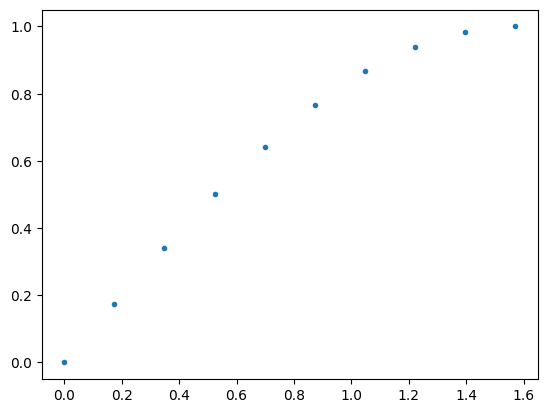

In [29]:
# The data set to approximate with x and y samples
xs_ori = np.linspace(xss_ori[0], xss_ori[-1], 10)
ys = np.array(np.sin(xs_ori))
plt.plot(xs_ori, ys, '.')

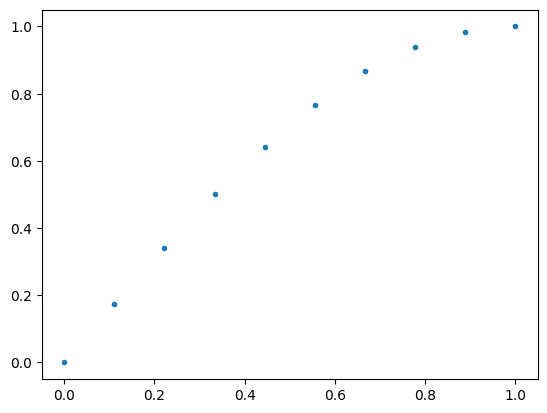

In [4]:
xs = sampledata.rescale_input_data(xs_ori, 1)
plt.plot(xs, ys, '.')

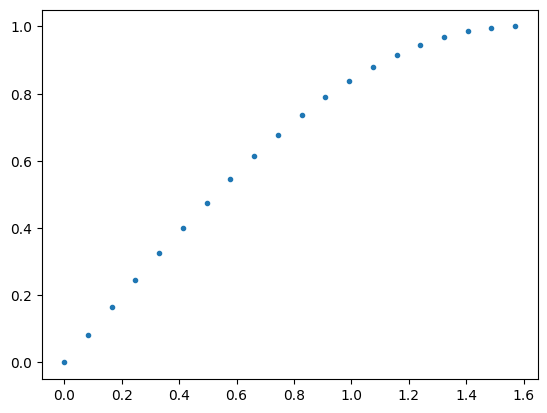

In [5]:
# The data set to approximate with x and y samples
xs2_ori = np.linspace(0, 0.5*np.pi, 20)
ys2 = np.sin(xs2_ori)
plt.plot(xs2_ori, ys2, '.')

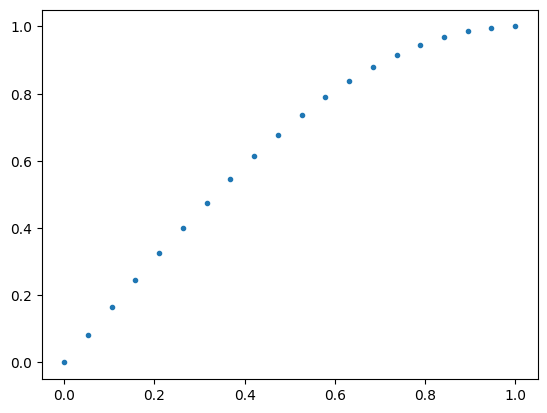

In [6]:
xs2 = sampledata.rescale_input_data(xs2_ori, 1)
plt.plot(xs2, ys2, '.')

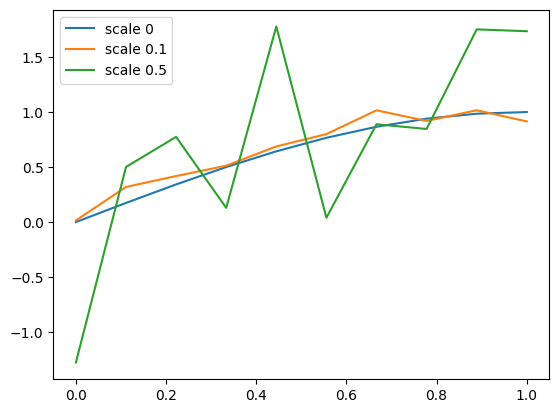

In [7]:
# Explicit seed to have reproducible testsets
np.random.seed(0)
ysgauss_scales = [0.0, 0.1, 0.5]
ysgauss = [ys + np.random.normal(scale=s, size=len(ys)) for s in ysgauss_scales]

for i, ysn in enumerate(ysgauss):
    plt.plot(xs, ysn, '-', label='scale %.2g' % ysgauss_scales[i])
plt.legend(loc="best")

## Investigating epochs, learning rates and regularization

In [8]:
epochs = 2000
degree = 6
lrs_ori = [10.0**e for e in np.arange(-2.0, 0.01, 0.25)]
lrs = [10.0**e for e in np.arange(-2.0, 1.25, 0.25)]

In [10]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'degree': degree, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'power', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with_ori = pool.starmap(parallel.job, zip(lrs_ori, repeat(kwargs)))

In [11]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'degree': degree, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'power', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without_ori = pool.starmap(parallel.job, zip(lrs_ori, repeat(kwargs)))

In [12]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'degree': degree, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'chebyshev', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with_chebyshev_ori = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [13]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'degree': degree, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'chebyshev', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without_chebyshev_ori = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [14]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'degree': degree, 'polynum': 1, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with_shifted_chebyshev_ori = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [15]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'degree': degree, 'polynum': 1, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without_shifted_chebyshev_ori = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [16]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'power', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [17]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'power', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [18]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'chebyshev', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with_chebyshev = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [19]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without_chebyshev = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [20]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': 1, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with_shifted_chebyshev = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [21]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': 1, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': 'off', 'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without_shifted_chebyshev = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [22]:
# get total loss values of every entry

losses_with_ori = [0.0] * len(results_with_ori)
losses_without_ori = [0.0] * len(results_with_ori)
losses_with_chebyshev_ori = [0.0] * len(results_with_ori)
losses_without_chebyshev_ori = [0.0] * len(results_with_ori)
losses_with_shifted_chebyshev_ori = [0.0] * len(results_with_ori)
losses_without_shifted_chebyshev_ori = [0.0] * len(results_with_ori)

losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)
losses_with_chebyshev = [0.0] * len(results_with)
losses_without_chebyshev  = [0.0] * len(results_with)
losses_with_shifted_chebyshev  = [0.0] * len(results_with)
losses_without_shifted_chebyshev  = [0.0] * len(results_with)

for i in range(len(results_with_ori)):
    losses_with_ori[i] = results_with_ori[i][1]
    losses_without_ori[i] = results_without_ori[i][1]
    losses_with_chebyshev_ori[i] = results_with_chebyshev_ori[i][1]
    losses_without_chebyshev_ori[i] = results_without_chebyshev_ori[i][1]
    losses_with_shifted_chebyshev_ori[i] = results_with_shifted_chebyshev_ori[i][1]
    losses_without_shifted_chebyshev_ori[i] = results_without_shifted_chebyshev_ori[i][1]

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_with_chebyshev[i] = results_with_chebyshev[i][1]
    losses_without_chebyshev[i] = results_without_chebyshev[i][1]
    losses_with_shifted_chebyshev[i] = results_with_shifted_chebyshev[i][1]
    losses_without_shifted_chebyshev[i] = results_without_shifted_chebyshev[i][1]

### Info: Inf vs. NaN
matplotlib handles inf and nan values differently. while inf values will still create a line in the plot, nan values will simply make the line "stop".
Some arithmetic operations with Infinity can lead to NaN values. For instance, subtracting Infinity from Infinity, multiplying Infinity by zero, or adding/subtracting Infinity to/from negative Infinity will yield NaN.

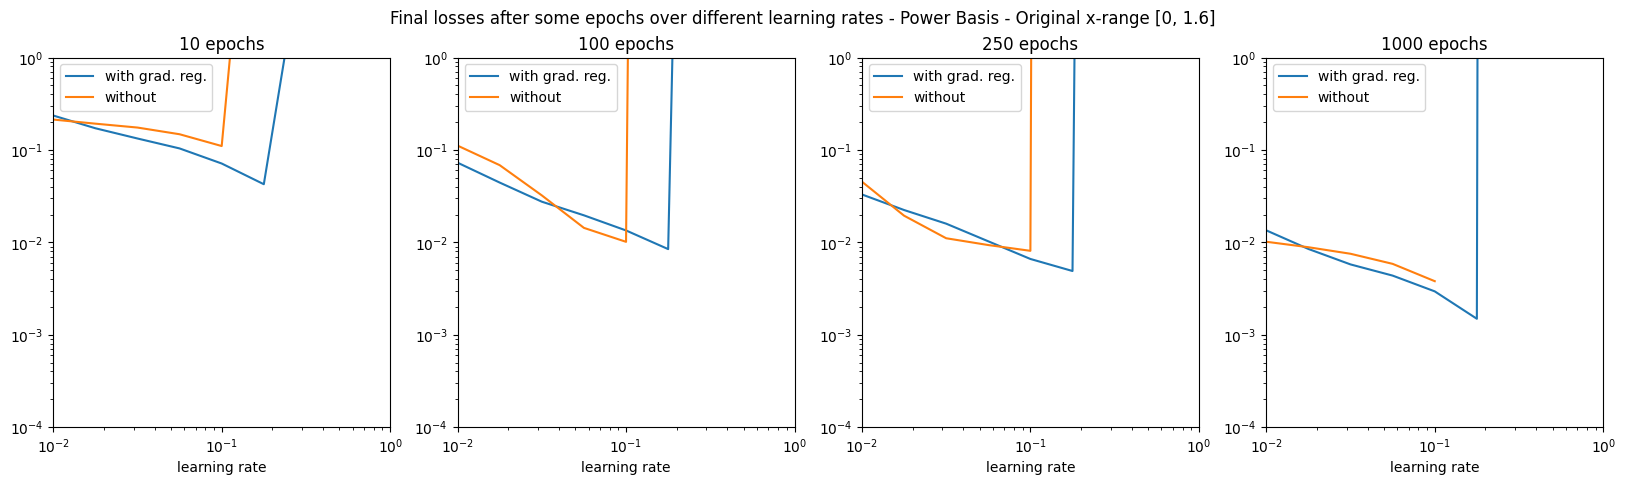

In [23]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Power Basis - Original x-range [0, 1.6]")

for i, epoch in enumerate([10, 100, 250, 1000]):
    ax = axes[i]

    ax.set_title("%d epochs" % epoch)

    ax.set_xlabel("learning rate")
    ax.loglog(lrs_ori, [row[epoch] for row in losses_with_ori], label="with grad. reg.")
    ax.loglog(lrs_ori, [row[epoch] for row in losses_without_ori], label="without")
    ax.set_xlim([1e-2, 1e-0])
    ax.set_ylim([1e-4, 1e-0])
    ax.legend(loc="best")

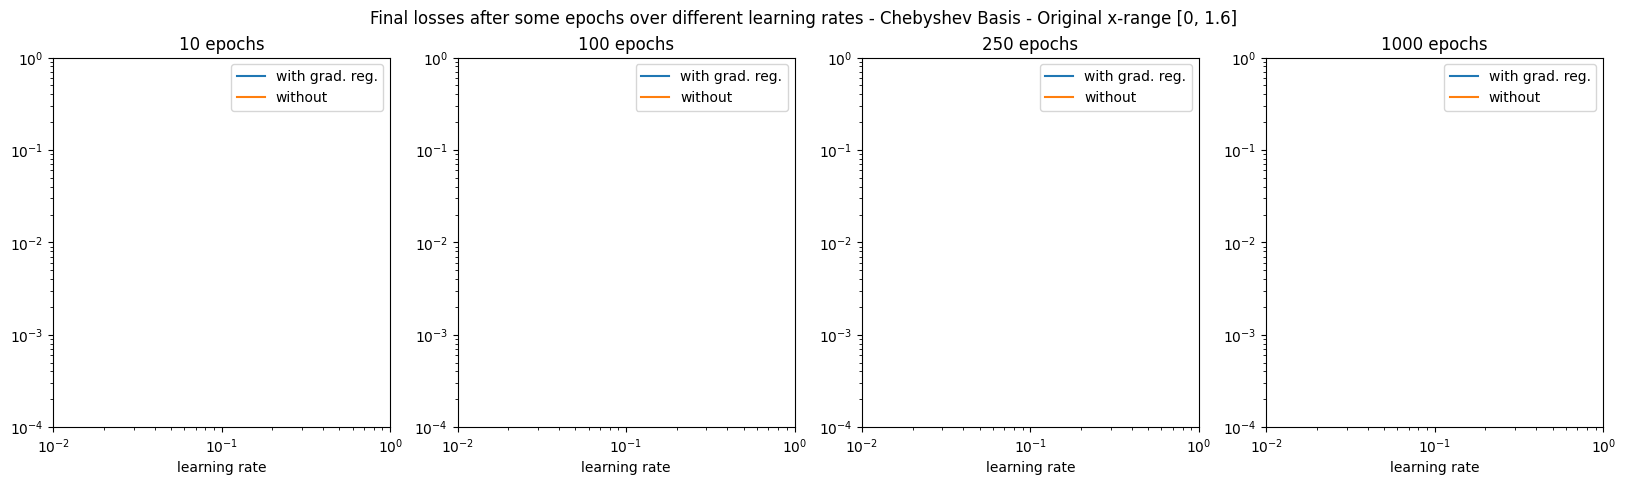

In [34]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Chebyshev Basis - Original x-range [0, 1.6]")

for i, epoch in enumerate([10, 100, 250, 1000]):
    ax = axes[i]

    ax.set_title("%d epochs" % epoch)

    ax.set_xlabel("learning rate")
    ax.loglog(lrs_ori, [row[epoch] for row in losses_with_chebyshev_ori], label="with grad. reg.")
    ax.loglog(lrs_ori, [row[epoch] for row in losses_without_chebyshev_ori], label="without")
    ax.set_xlim([1e-2, 1e-0])
    ax.set_ylim([1e-4, 1e-0])
    ax.legend(loc="best")

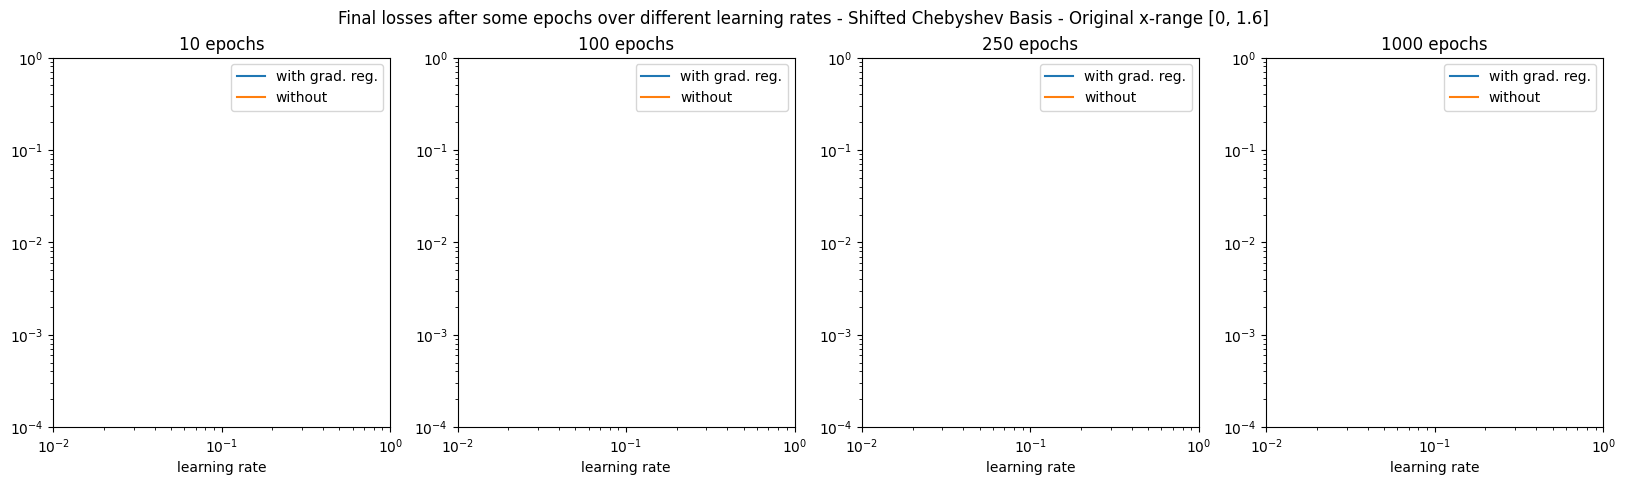

In [33]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Shifted Chebyshev Basis - Original x-range [0, 1.6]")

for i, epoch in enumerate([10, 100, 250, 1000]):
    ax = axes[i]

    ax.set_title("%d epochs" % epoch)

    ax.set_xlabel("learning rate")
    ax.loglog(lrs_ori, [row[epoch] for row in losses_with_shifted_chebyshev_ori], label="with grad. reg.")
    ax.loglog(lrs_ori, [row[epoch] for row in losses_without_shifted_chebyshev_ori], label="without")
    ax.set_xlim([1e-2, 1e-0])
    ax.set_ylim([1e-4, 1e-0])
    ax.legend(loc="best")

## Data x-range

Input data of the original experiments have an x-range [0, 1.6].
This needs to be rescaled to the interval [0,1], as Chebyshev polynomials only provide a basis for polynomials in that range.
This is why results for Power Basis also are slightly different in this test run.

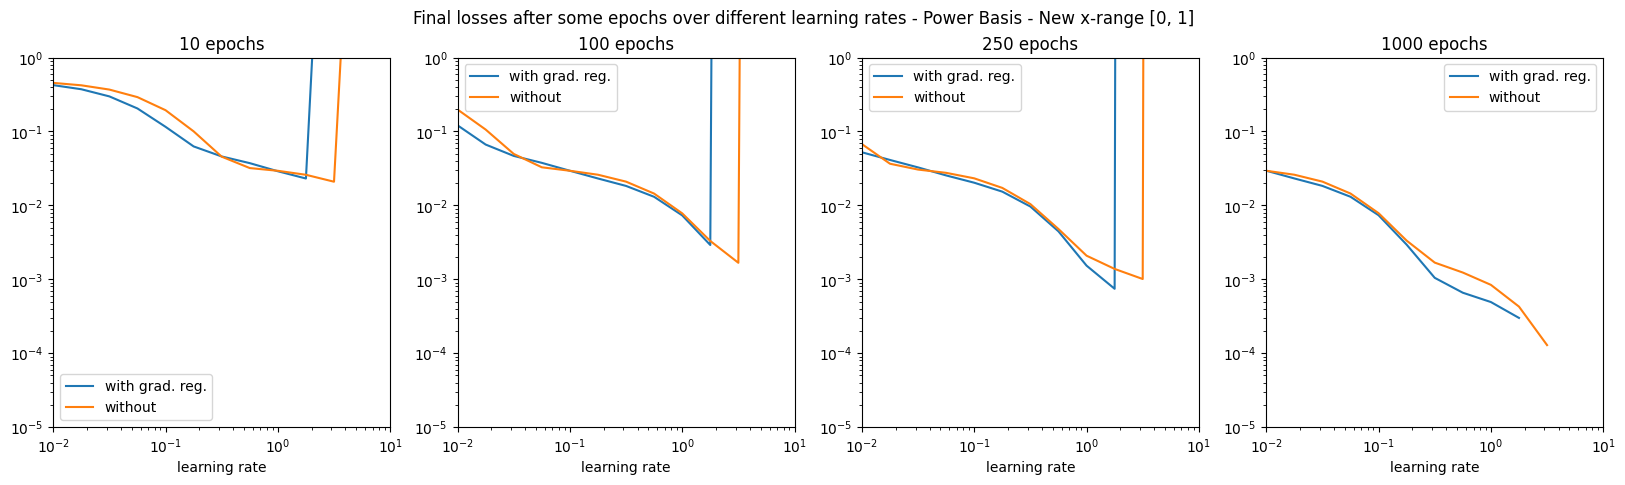

In [26]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Power Basis - New x-range [0, 1]")

for i, epochs in enumerate([10, 100, 250, 1000]):
    ax = axes[i]
    
    ax.set_title("%d epochs" % epochs)
    
    ax.set_xlabel("learning rate")
    ax.loglog(lrs, [row[epochs] for row in losses_with], label="with grad. reg.")
    ax.loglog(lrs, [row[epochs] for row in losses_without], label="without")
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-5, 1e-0])
    ax.legend(loc="best")

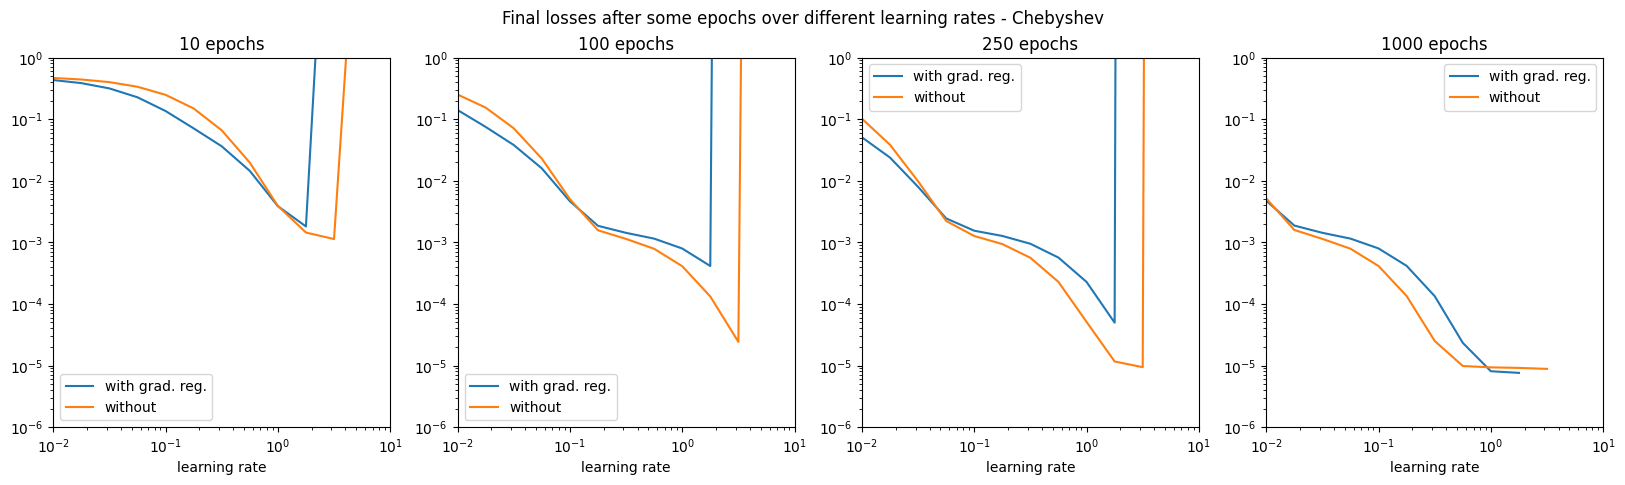

In [27]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Chebyshev")

for i, epochs in enumerate([10, 100, 250, 1000]):
    ax = axes[i]

    ax.set_title("%d epochs" % epochs)

    ax.set_xlabel("learning rate")
    ax.loglog(lrs, [row[epochs] for row in losses_with_chebyshev], label="with grad. reg.")
    ax.loglog(lrs, [row[epochs] for row in losses_without_chebyshev], label="without")
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-6, 1e-0])
    ax.legend(loc="best")

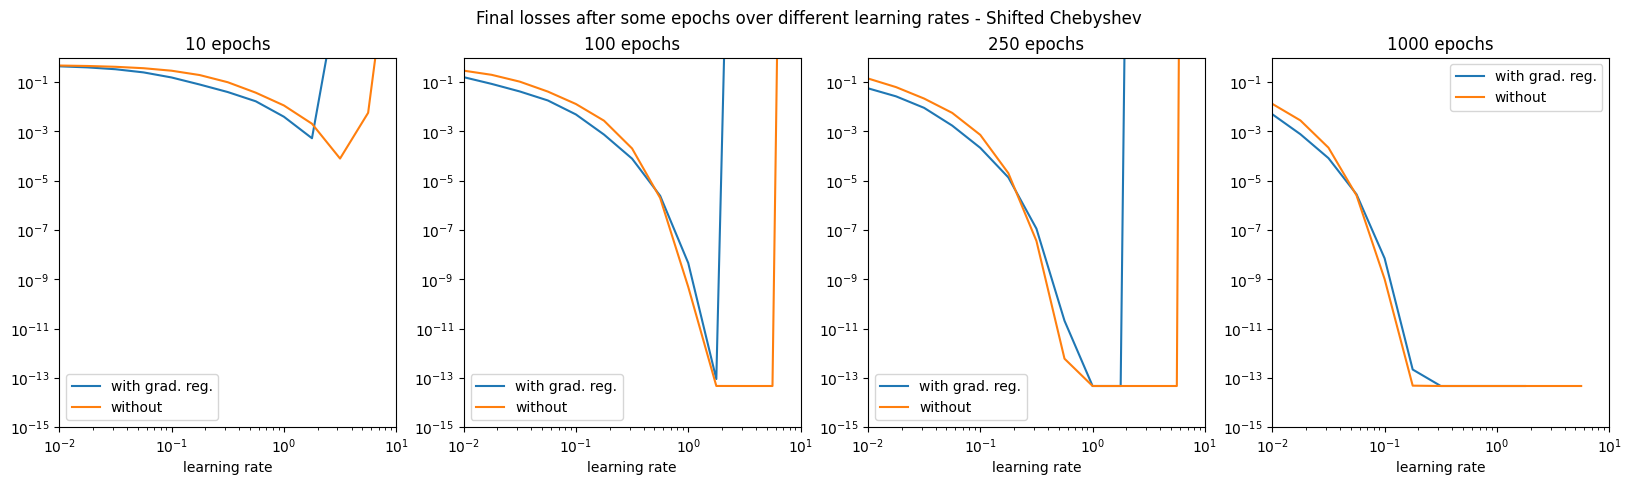

In [28]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Shifted Chebyshev")

for i, epochs in enumerate([10, 100, 250, 1000]):
    ax = axes[i]

    ax.set_title("%d epochs" % epochs)

    ax.set_xlabel("learning rate")
    ax.loglog(lrs, [row[epochs] for row in losses_with_shifted_chebyshev], label="with grad. reg.")
    ax.loglog(lrs, [row[epochs] for row in losses_without_shifted_chebyshev], label="without")
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-15, 1e-0])
    ax.legend(loc="best")

### Interpretation
- As we expect, at some point of the learning rate the final losses diverge. 
- Power Basis: At the original interval [0, 1.6], we can have larger learning rates with regularization.
With the interval [0, 1] the opposite is the case. **With an interval [0, 1], higher learning rates are possible.**
While the interval [0, 1.6] limits learning rates to ~0.1, with the interval [0, 1] learning rates up to ~2 are possible (without regularization).
- Chebyshev Basis: We can have larger learning rates. Without regularization, learning rates up to ~3 still converge.
Remaining losses are about two magnitudes lower compared to Power Basis.
- Shifted Chebyshev Basis: Outstanding Performance. Remaining losses are several magnitudes lower compared to Power Basis, in the realm of numerical noise.
- Without regularization, learning rates up to ~4 still converge.

**Reasonable choices for learning rates with interval [0,1] and no regularization:**
- Power Basis: 2
- Chebyshev Basis: 2.3
- Shifted Chebyshev Basis: 3.2

**Reasonable choices for learning rates with interval [0,1] and regularization:**
- Power Basis: 1.3
- Chebyshev Basis: 1.3
- Shifted Chebyshev Basis: 1.3

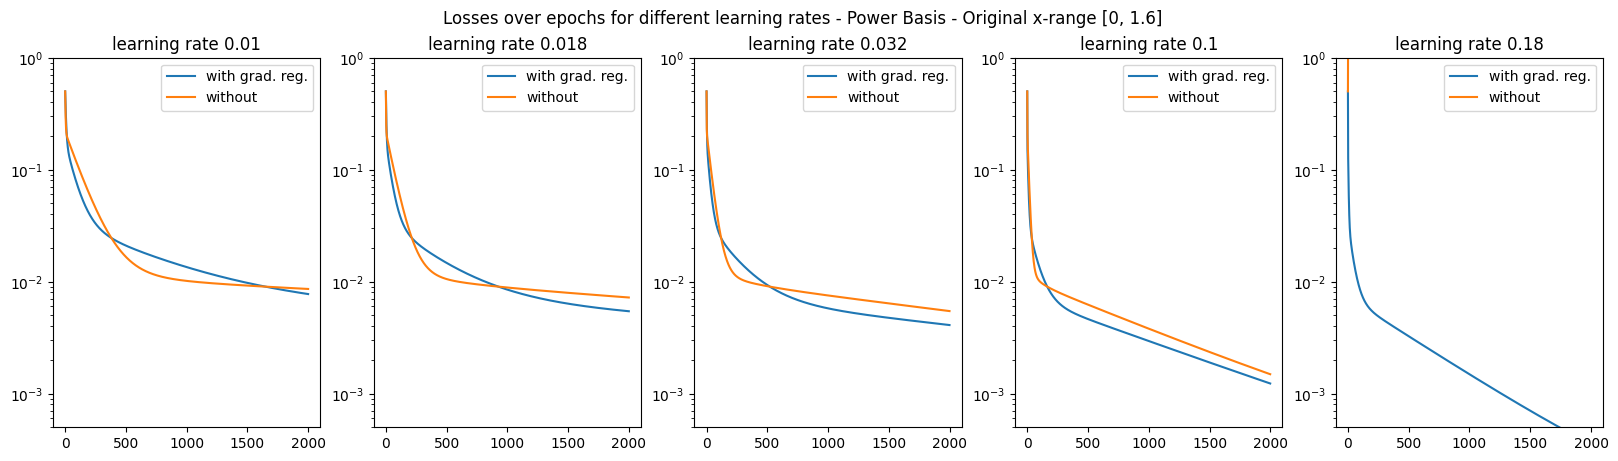

In [29]:
fig, axes = plt.subplots(1, 5)
fig.set_figwidth(20)
fig.suptitle(f"Losses over epochs for different learning rates - Power Basis - Original x-range [0, 1.6]")

for i, lri in enumerate([0, 1, 2, 4, 5]):
    ax = axes[i]
    lr = lrs_ori[lri]

    ax.set_title("learning rate %.2g" % lr)

    ax.semilogy(losses_with_ori[lri], label="with grad. reg.")
    ax.semilogy(losses_without_ori[lri], label="without")
    ax.set_ylim([5e-4, 1e-0])
    ax.legend(loc="best")

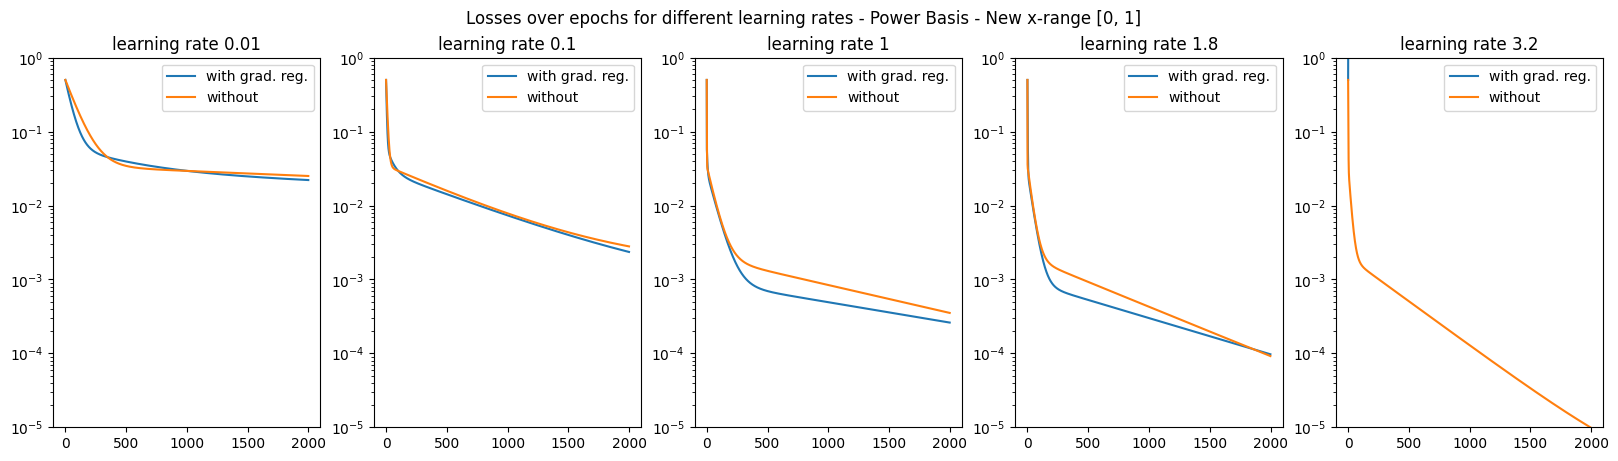

In [30]:
fig, axes = plt.subplots(1, 5)
fig.set_figwidth(20)
fig.suptitle(f"Losses over epochs for different learning rates - Power Basis - New x-range [0, 1]")

for i, lri in enumerate([0, 4, 8, 9, 10]):
    ax = axes[i]
    lr = lrs[lri]

    ax.set_title("learning rate %.2g" % lr)

    ax.semilogy(losses_with[lri], label="with grad. reg.")
    ax.semilogy(losses_without[lri], label="without")
    ax.set_ylim([1e-5, 1e-0])
    ax.legend(loc="best")

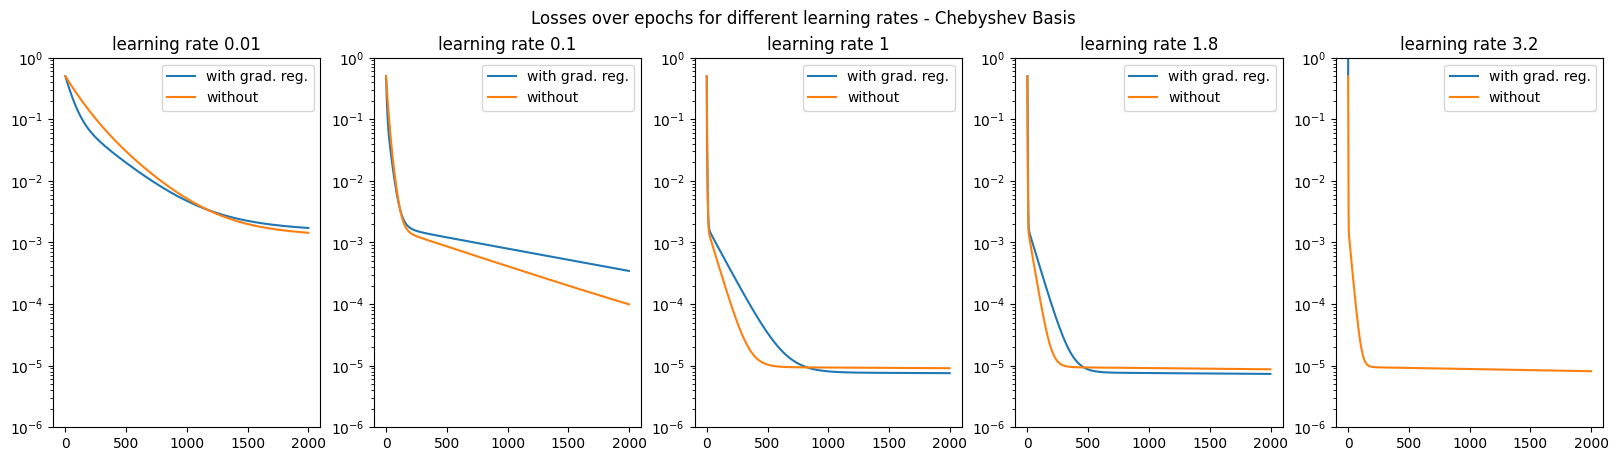

In [31]:
fig, axes = plt.subplots(1, 5)
fig.set_figwidth(20)
fig.suptitle(f"Losses over epochs for different learning rates - Chebyshev Basis")

for i, lri in enumerate([0, 4, 8, 9, 10]):
    ax = axes[i]
    lr = lrs[lri]

    ax.set_title("learning rate %.2g" % lr)

    ax.semilogy(losses_with_chebyshev[lri], label="with grad. reg.")
    ax.semilogy(losses_without_chebyshev[lri], label="without")
    ax.set_ylim([1e-6, 1e-0])
    ax.legend(loc="best")

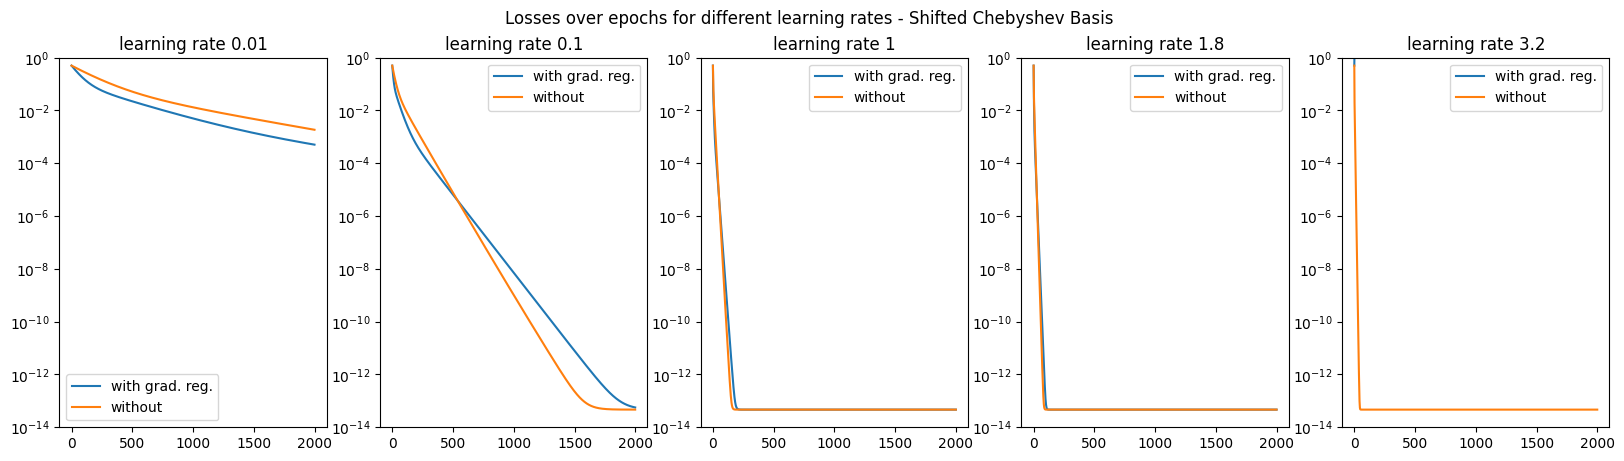

In [32]:
fig, axes = plt.subplots(1, 5)
fig.set_figwidth(20)
fig.suptitle(f"Losses over epochs for different learning rates - Shifted Chebyshev Basis")

for i, lri in enumerate([0, 4, 8, 9, 10]):
    ax = axes[i]
    lr = lrs[lri]

    ax.set_title("learning rate %.2g" % lr)

    ax.semilogy(losses_with_shifted_chebyshev[lri], label="with grad. reg.")
    ax.semilogy(losses_without_shifted_chebyshev[lri], label="without")
    ax.set_ylim([1e-14, 1e-0])
    ax.legend(loc="best")

### Interpretation
- The smaller the learning rate the more epochs we need such that regularization
  eventually outperforms without regularization. However, then again with large learning rates
  (0.18) and a very large number of epochs (2000) the version without regularization may again
  overtake at some point. This is probably also true for smaller learning rates and
  a correspondingly larger number of epochs. The reason is probably that the regularization only
  introduces some "priorization" of the gradients towards lower degrees. So it is only a question
  of number epochs until this effect vanishes again.
- A learning rate of 0.1, which has before been found to be reasonable, is clearly
  large enough such that regularization outperforms without regularization after
  already some 250 epochs.
- **Regularization is a good choice for Power Basis, but, since learning rates can be significantly higher for (shifted) Chebyshev basis,
regularization is not required there.**
- Having some 500 epochs gives already quite good results with Power Basis, and, with high enough learning rates, very good results with Chebyshev basis and outstanding results with shifted Chebyshev basis.

## Investigating polynomial degree

### Recreating original results with Interval [0, 1.6]

In [68]:
epochs = 1000
shift_polynomial_centers = 'off'
lr = 1.3
degrees = [d for d in range(1, 9)]

In [69]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': 0.1,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [70]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': 0.1,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [71]:
splines_with = [0.0] * len(results_with)
splines_without = [0.0] * len(results_with)

for i in range(len(results_with)):
    splines_with[i] = model.get_spline_from_coeffs(results_with[i][-1], xs_ori, ys, basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_with[i][1])
    splines_without[i] = model.get_spline_from_coeffs(results_without[i][-1], xs_ori, ys, basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_without[i][1])

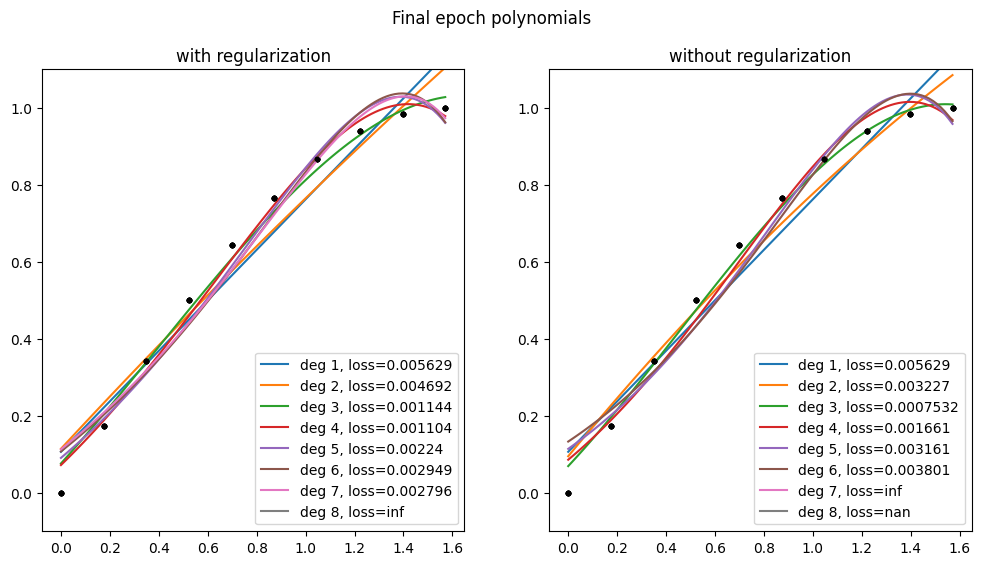

In [72]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines_with[i]
    swo = splines_without[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False)
    plot.plot_spline(swo, ax=ax2, label=f'deg {swo.polydegree}, loss={swo.total_loss_values[-1]:.4g}', segment_coloring=False)

fig.suptitle("Final epoch polynomials")
ax1.set_title("with regularization")
ax2.set_title("without regularization")
ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax2.legend(loc="best")

Results are identical to original ones.

### Results with Interval [0, 1]

In [73]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [74]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [75]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_with_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [76]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_without_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [77]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_with_shifted_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [78]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_without_shifted_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [79]:
splines_with = [0.0] * len(results_with)
splines_without = [0.0] * len(results_with)
splines_with_chebyshev = [0.0] * len(results_with)
splines_without_chebyshev  = [0.0] * len(results_with)
splines_with_shifted_chebyshev  = [0.0] * len(results_with)
splines_without_shifted_chebyshev  = [0.0] * len(results_with)

for i in range(len(results_with)):
    splines_with[i] = model.get_spline_from_coeffs(results_with[i][-1], xs, ys, basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_with[i][1])
    splines_without[i] = model.get_spline_from_coeffs(results_without[i][-1], xs, ys, basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_without[i][1])
    splines_with_chebyshev[i] = model.get_spline_from_coeffs(results_with_chebyshev[i][-1], xs, ys, basis='chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_with_chebyshev[i][1])
    splines_without_chebyshev[i] = model.get_spline_from_coeffs(results_without_chebyshev[i][-1], xs, ys, basis='chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_without_chebyshev[i][1])
    splines_with_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_with_shifted_chebyshev[i][-1], xs, ys, basis='shifted_chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_with_shifted_chebyshev[i][1])
    splines_without_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_without_shifted_chebyshev[i][-1], xs, ys, basis='shifted_chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_without_shifted_chebyshev[i][1])

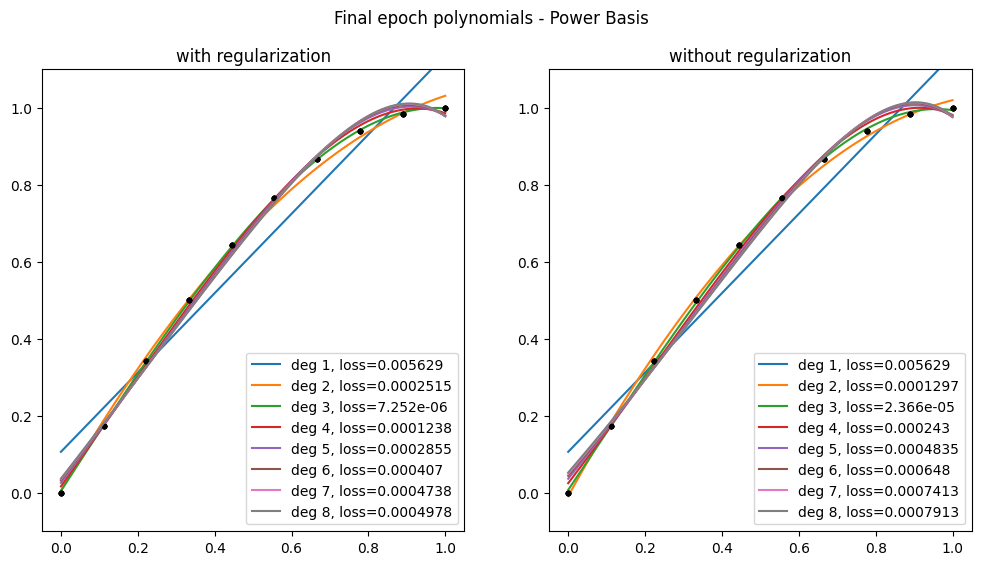

In [80]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines_with[i]
    swo = splines_without[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False)
    plot.plot_spline(swo, ax=ax2, label=f'deg {swo.polydegree}, loss={swo.total_loss_values[-1]:.4g}', segment_coloring=False)

fig.suptitle("Final epoch polynomials - Power Basis")
ax1.set_title("with regularization")
ax2.set_title("without regularization")
ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax2.legend(loc="best")

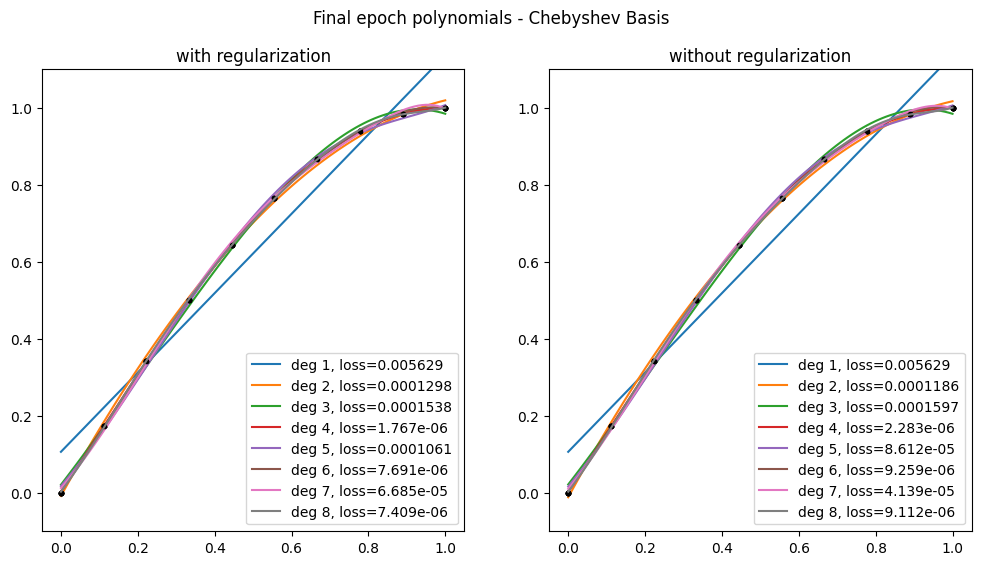

In [81]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines_with_chebyshev[i]
    swo = splines_without_chebyshev[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False)
    plot.plot_spline(swo, ax=ax2, label=f'deg {swo.polydegree}, loss={swo.total_loss_values[-1]:.4g}', segment_coloring=False)

fig.suptitle("Final epoch polynomials - Chebyshev Basis")
ax1.set_title("with regularization")
ax2.set_title("without regularization")
ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax2.legend(loc="best")

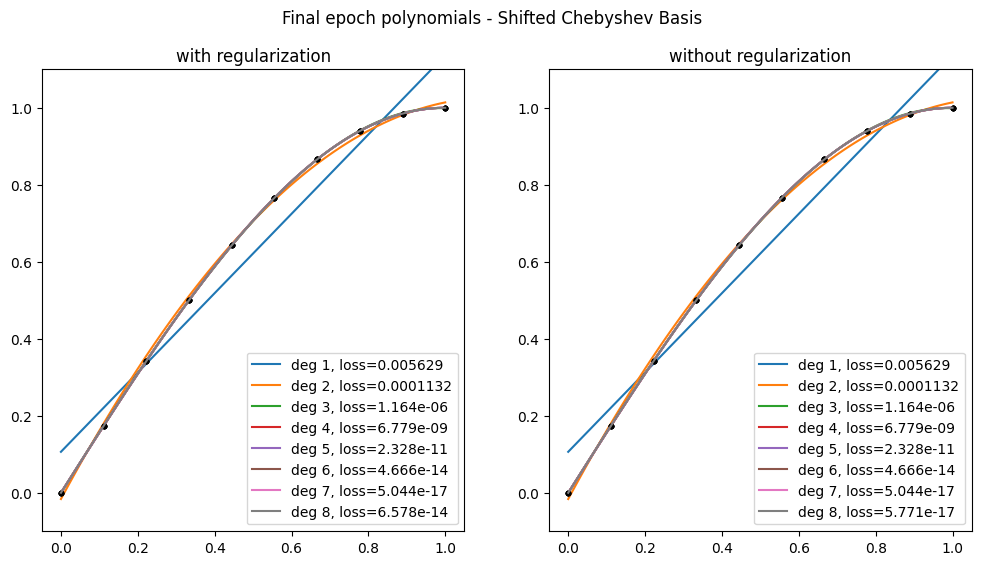

In [82]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines_with_shifted_chebyshev[i]
    swo = splines_without_shifted_chebyshev[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False)
    plot.plot_spline(swo, ax=ax2, label=f'deg {swo.polydegree}, loss={swo.total_loss_values[-1]:.4g}', segment_coloring=False)

fig.suptitle("Final epoch polynomials - Shifted Chebyshev Basis")
ax1.set_title("with regularization")
ax2.set_title("without regularization")
ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax2.legend(loc="best")

### Interpretation

**Power Basis:**
- Regularization only shows slight differences at this higher learning rate, however, with degree 3, no regularization performs better (one magnitude)
- As with the original experiment, the best result is obtained with a degree-3 polynomial. This comes at no surprise, because this data set displays **"low model complexity"**, so a lower degree polynomial will do better.
  Hence, we may need to look for more complex input data (like adding noise!) to showcase the usage of higher-degree polynomials. Or better: Later we will tune the optimizers that produce results closer to the optimum. And of course then we have: Higher degree is better.

**Chebyshev Basis:**
- Regularization only shows slight differences, however, with degree 5, no regularization performs better (two magnitudes)
- Best result is obtained with degree 4

**Shifted Chebyshev Basis:**
- Results are identical for Regularization and without it, except with degree 8, where no regularization performs better (three magnitudes)
- Best result is obtained with degree 7, but degree 5 is already at a negligible loss

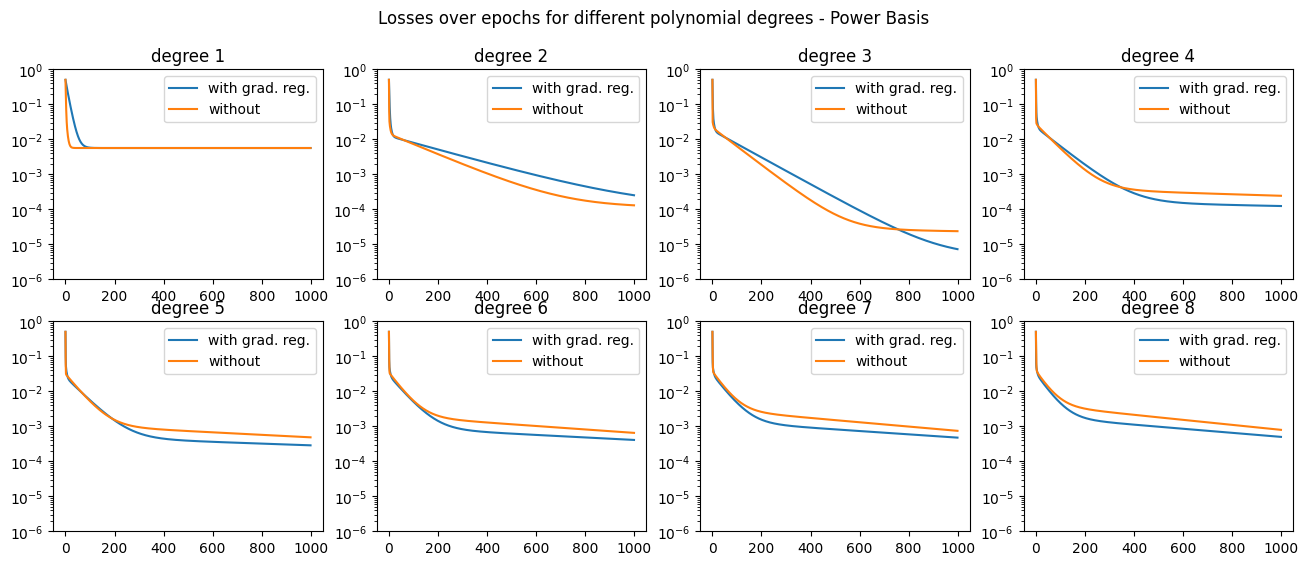

In [86]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees - Power Basis")

for i, d in enumerate(degrees):
    ax = axes[i]
    
    ax.set_title("degree %d" % d)
      
    ax.semilogy(splines_with[i].total_loss_values, label="with grad. reg.")
    ax.semilogy(splines_without[i].total_loss_values, label="without")
    ax.set_ylim([1e-6, 1e-0])
    ax.legend(loc="best")

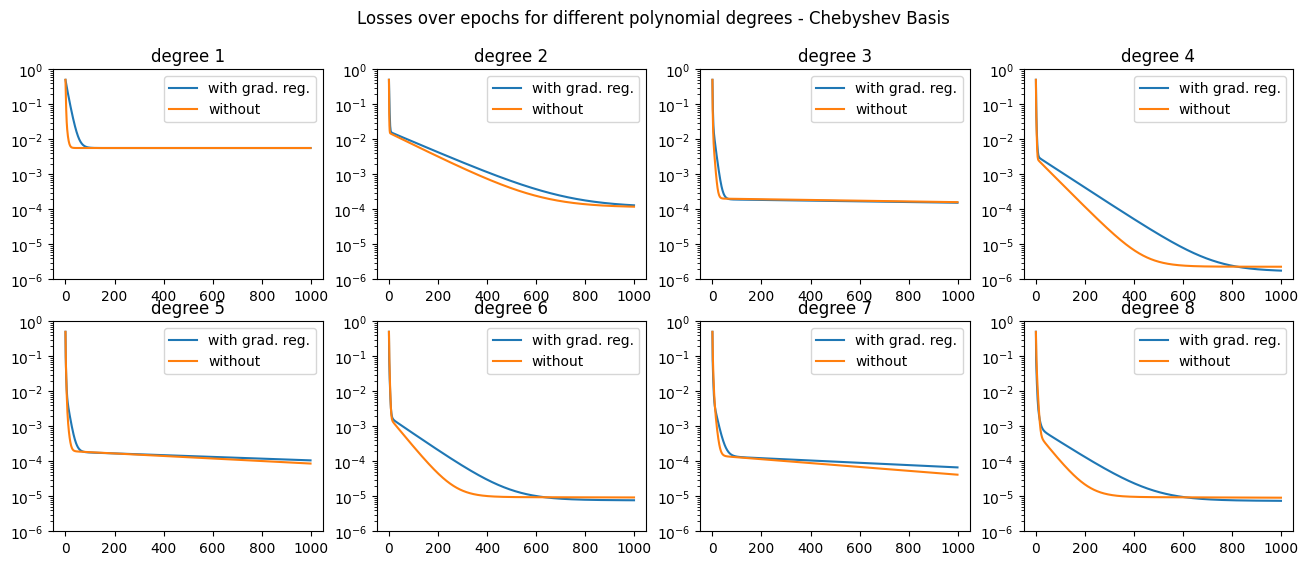

In [89]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees - Chebyshev Basis")

for i, d in enumerate(degrees):
    ax = axes[i]

    ax.set_title("degree %d" % d)

    ax.semilogy(splines_with_chebyshev[i].total_loss_values, label="with grad. reg.")
    ax.semilogy(splines_without_chebyshev[i].total_loss_values, label="without")
    ax.set_ylim([1e-6, 1e-0])
    ax.legend(loc="best")

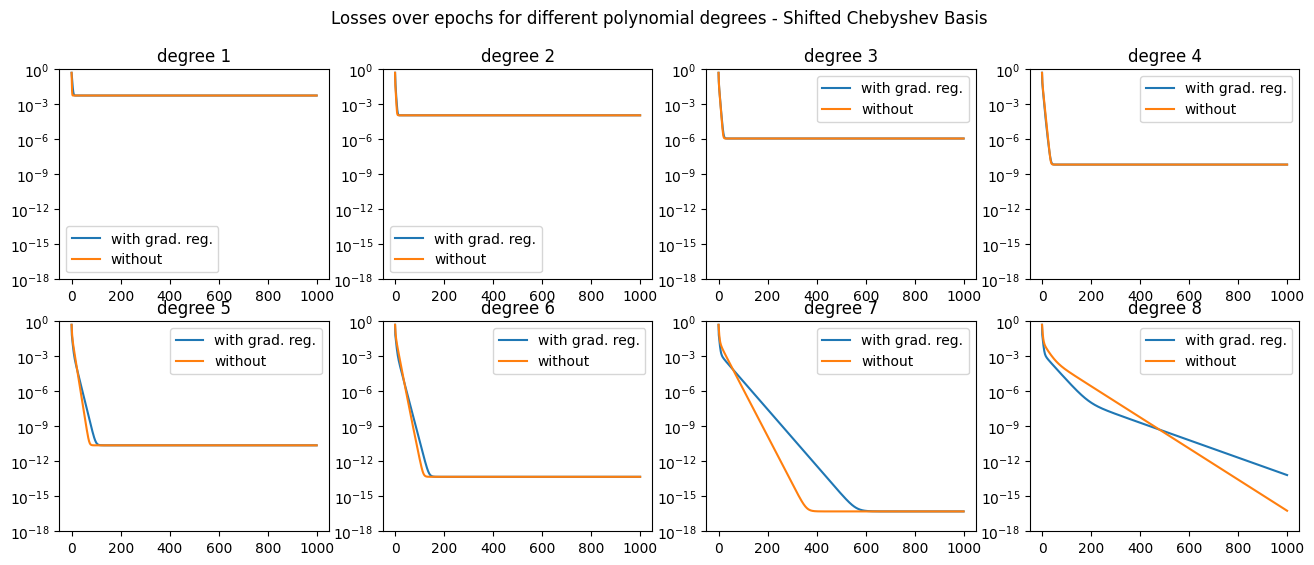

In [91]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees - Shifted Chebyshev Basis")

for i, d in enumerate(degrees):
    ax = axes[i]

    ax.set_title("degree %d" % d)

    ax.semilogy(splines_with_shifted_chebyshev[i].total_loss_values, label="with grad. reg.")
    ax.semilogy(splines_without_shifted_chebyshev[i].total_loss_values, label="without")
    ax.set_ylim([1e-18, 1e-0])
    ax.legend(loc="best")

### Interpretation
**Power Basis:**
- **For degrees larger than three the regularization leads to better results.** (We know from earlier experiments that for a very large number of epochs this advantage will vanish again.)
- Of course, we would now reduce the learning rate to help higher degree polynomials to converge. But at the moment I do not see a point in doing this obvious experiment.

**Chebyshev Basis:**
- For degrees 4, 6 and 8 regularization leads to slightly better results.

**Shifted Chebyshev Basis:**
- Regularization does not improve convergence behaviour

In [41]:
epochs = 100
shift_polynomial_centers = 'off'
degrees = range(1, 9)
lrs = [10.0**e for e in np.arange(-2.0, 1.0, 0.25)]
args = [(d, lr) for d in degrees for lr in lrs]

In [61]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [62]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [66]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [67]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [68]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with_shifted_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [69]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without_shifted_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [71]:
# Slice the outermost list into sublists of specific degrees
sliced_results_with = [results_with[i:i+len(lrs)] for i in range(0, len(results_with), len(lrs))]
sliced_results_without = [results_without[i:i+len(lrs)] for i in range(0, len(results_without), len(lrs))]
sliced_results_with_chebyshev = [results_with_chebyshev[i:i+len(lrs)] for i in range(0, len(results_with), len(lrs))]
sliced_results_without_chebyshev = [results_without_chebyshev[i:i+len(lrs)] for i in range(0, len(results_without), len(lrs))]
sliced_results_with_shifted_chebyshev = [results_with_shifted_chebyshev[i:i+len(lrs)] for i in range(0, len(results_with), len(lrs))]
sliced_results_without_shifted_chebyshev = [results_without_shifted_chebyshev[i:i+len(lrs)] for i in range(0, len(results_without), len(lrs))]

# losses_with = [[0.0 for _ in range(len(lrs_ori))]] * len(sliced_results_with) # Bad! Creates Reference Copies of rows, thus duplicated rows in the end.
# losses_without = [[0.0 for _ in range(len(lrs_ori))]] * len(sliced_results_with)
losses_with = np.zeros((len(sliced_results_with), len(lrs)))
losses_without = np.zeros((len(sliced_results_with), len(lrs)))
losses_with_chebyshev = np.zeros((len(sliced_results_with), len(lrs)))
losses_without_chebyshev = np.zeros((len(sliced_results_with), len(lrs)))
losses_with_shifted_chebyshev = np.zeros((len(sliced_results_with), len(lrs)))
losses_without_shifted_chebyshev = np.zeros((len(sliced_results_with), len(lrs)))

# We want the loss value at epoch 100 of the learning rate of every degree
for i in range(len(sliced_results_with)):
    for j in range(len(sliced_results_with[i])):
        losses_with[i][j] = sliced_results_with[i][j][1][-1]
        losses_without[i][j] = sliced_results_without[i][j][1][-1]
        losses_with_chebyshev[i][j] = sliced_results_with_chebyshev[i][j][1][-1]
        losses_without_chebyshev[i][j] = sliced_results_without_chebyshev[i][j][1][-1]
        losses_with_shifted_chebyshev[i][j] = sliced_results_with_shifted_chebyshev[i][j][1][-1]
        losses_without_shifted_chebyshev[i][j] = sliced_results_without_shifted_chebyshev[i][j][1][-1]

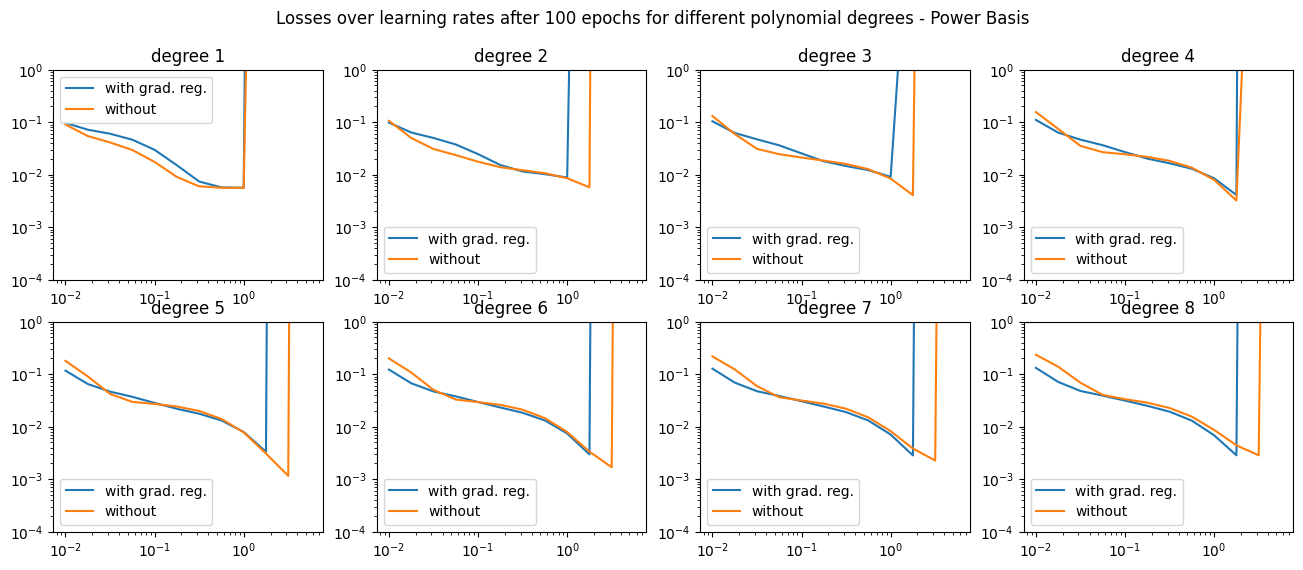

In [65]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over learning rates after %d epochs for different polynomial degrees - Power Basis" % epochs)

for i, d in enumerate(degrees):
    ax = axes[i]
    
    ax.set_title("degree %d" % d)
      
    ax.loglog(lrs, losses_with[i], label="with grad. reg.")
    ax.loglog(lrs, losses_without[i], label="without")
    ax.set_ylim([1e-4, 1e-0])
    ax.legend(loc="best")

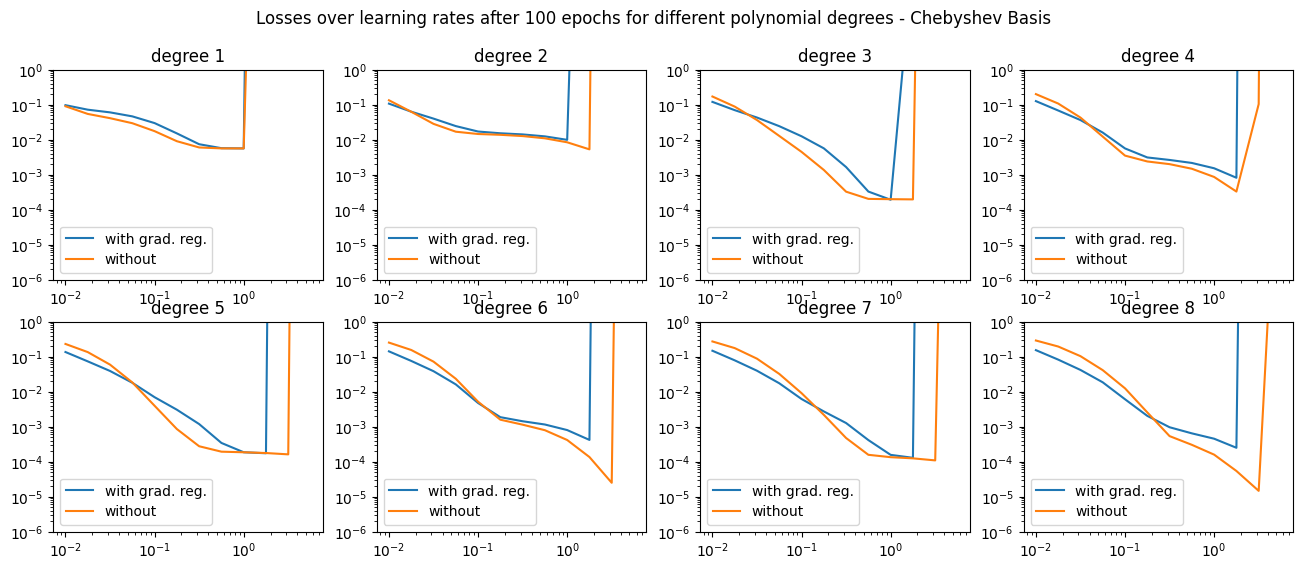

In [73]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over learning rates after %d epochs for different polynomial degrees - Chebyshev Basis" % epochs)

for i, d in enumerate(degrees):
    ax = axes[i]

    ax.set_title("degree %d" % d)

    ax.loglog(lrs, losses_with_chebyshev[i], label="with grad. reg.")
    ax.loglog(lrs, losses_without_chebyshev[i], label="without")
    ax.set_ylim([1e-6, 1e-0])
    ax.legend(loc="best")

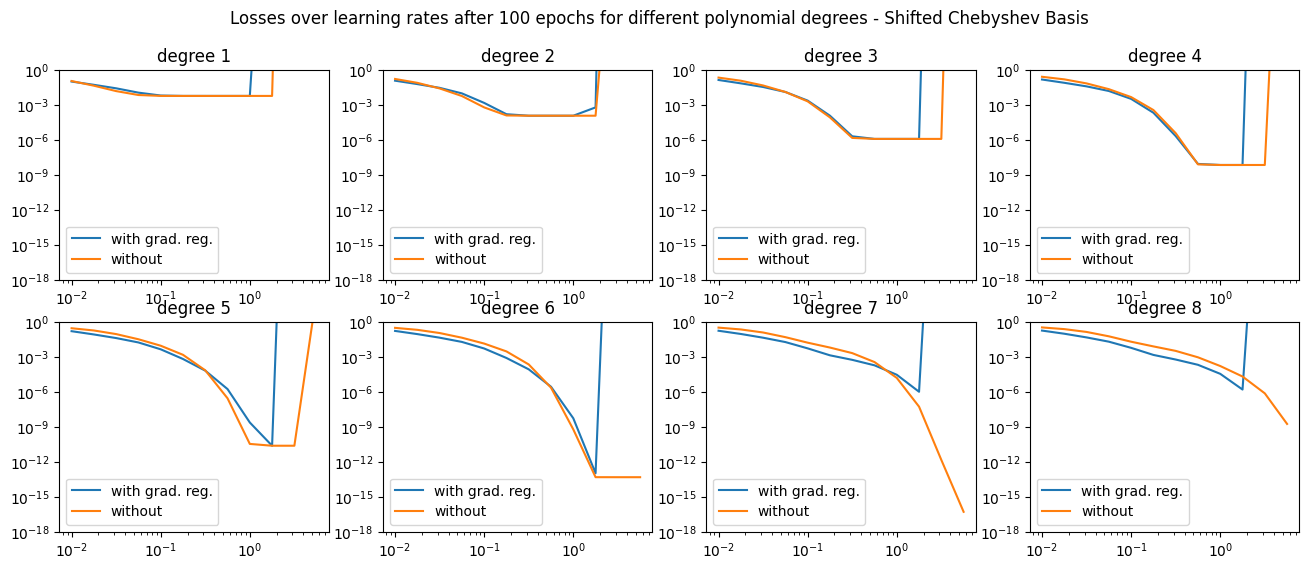

In [75]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over learning rates after %d epochs for different polynomial degrees - Shifted Chebyshev Basis" % epochs)

for i, d in enumerate(degrees):
    ax = axes[i]

    ax.set_title("degree %d" % d)

    ax.loglog(lrs, losses_with_shifted_chebyshev[i], label="with grad. reg.")
    ax.loglog(lrs, losses_without_shifted_chebyshev[i], label="without")
    ax.set_ylim([1e-18, 1e-0])
    ax.legend(loc="best")

### Interpretation
- In the original data we saw how the boundary of working learning rates shifts to the left when the polynomial degree increases.
This is not the case any longer for the new interval [0, 1], also for Power Basis.

## Investigating number of input points

In [19]:
epochs = 1000
shift_polynomial_centers = 'off'
lr = 1.3
degrees = [d for d in range(1, 9)]

In [20]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [21]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [22]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_with_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [23]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_without_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [24]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_with_shifted_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [25]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_without_shifted_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [26]:
splines_with = [0.0] * len(results_with)
splines_without = [0.0] * len(results_with)
splines_with_chebyshev = [0.0] * len(results_with)
splines_without_chebyshev  = [0.0] * len(results_with)
splines_with_shifted_chebyshev  = [0.0] * len(results_with)
splines_without_shifted_chebyshev  = [0.0] * len(results_with)

for i in range(len(results_with)):
    splines_with[i] = model.get_spline_from_coeffs(results_with[i][-1], xs2, ys2, basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_with[i][1])
    splines_without[i] = model.get_spline_from_coeffs(results_without[i][-1], xs2, ys2, basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_without[i][1])
    splines_with_chebyshev[i] = model.get_spline_from_coeffs(results_with_chebyshev[i][-1], xs2, ys2, basis='chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_with_chebyshev[i][1])
    splines_without_chebyshev[i] = model.get_spline_from_coeffs(results_without_chebyshev[i][-1], xs2, ys2, basis='chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_without_chebyshev[i][1])
    splines_with_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_with_shifted_chebyshev[i][-1], xs2, ys2, basis='shifted_chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_with_shifted_chebyshev[i][1])
    splines_without_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_without_shifted_chebyshev[i][-1], xs2, ys2, basis='shifted_chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_without_shifted_chebyshev[i][1])

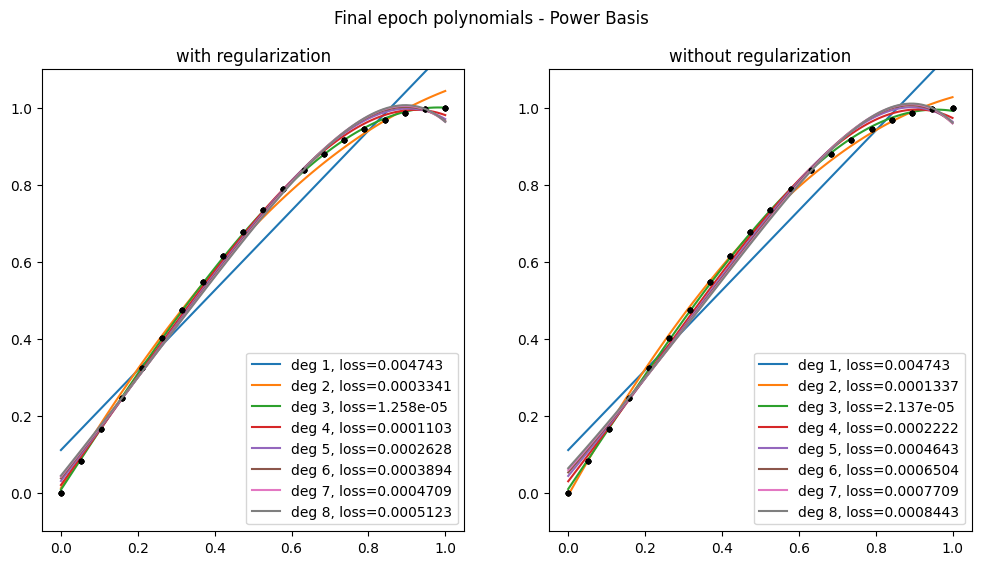

In [27]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines_with[i]
    swo = splines_without[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False)
    plot.plot_spline(swo, ax=ax2, label=f'deg {swo.polydegree}, loss={swo.total_loss_values[-1]:.4g}', segment_coloring=False)

fig.suptitle("Final epoch polynomials - Power Basis")
ax1.set_title("with regularization")
ax2.set_title("without regularization")
ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax2.legend(loc="best")

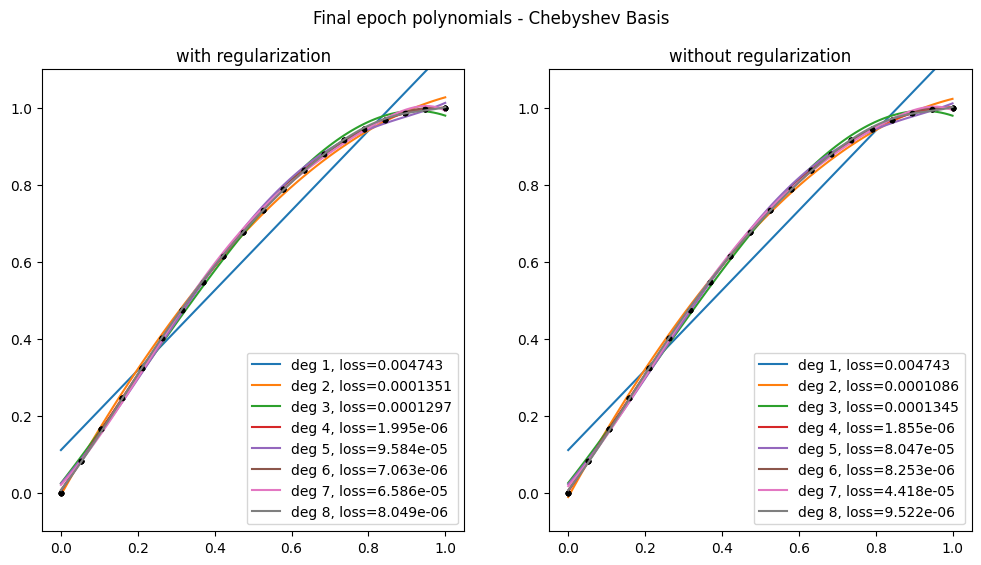

In [28]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines_with_chebyshev[i]
    swo = splines_without_chebyshev[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False)
    plot.plot_spline(swo, ax=ax2, label=f'deg {swo.polydegree}, loss={swo.total_loss_values[-1]:.4g}', segment_coloring=False)

fig.suptitle("Final epoch polynomials - Chebyshev Basis")
ax1.set_title("with regularization")
ax2.set_title("without regularization")
ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax2.legend(loc="best")

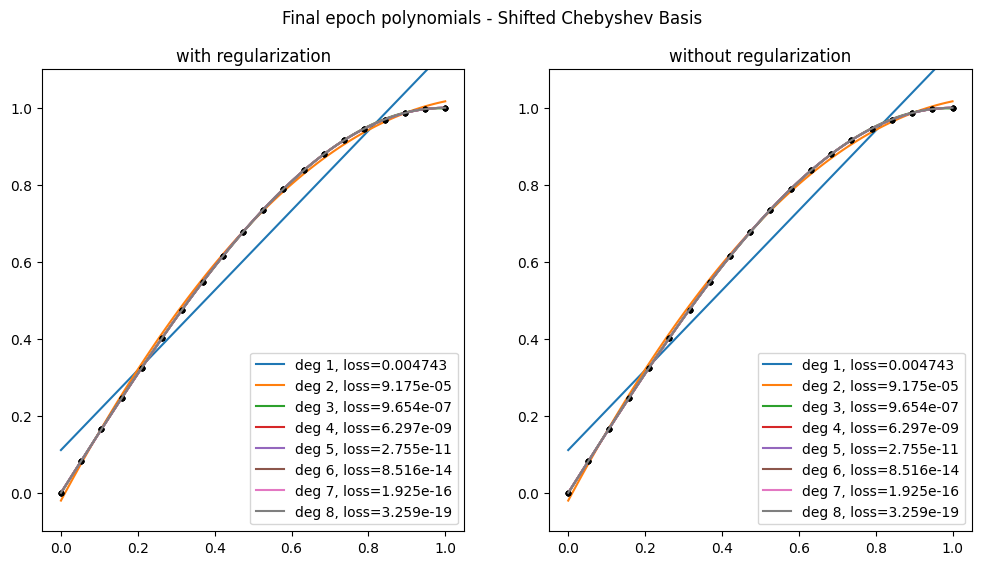

In [29]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines_with_shifted_chebyshev[i]
    swo = splines_without_shifted_chebyshev[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False)
    plot.plot_spline(swo, ax=ax2, label=f'deg {swo.polydegree}, loss={swo.total_loss_values[-1]:.4g}', segment_coloring=False)

fig.suptitle("Final epoch polynomials - Shifted Chebyshev Basis")
ax1.set_title("with regularization")
ax2.set_title("without regularization")
ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax2.legend(loc="best")

### Interpretation

**Power Basis**:
- Increasing the numer of input points to 20 **improves convergence**, except for degree 3 with regularization.

**Chebyshev Basis**:
- Increasing number of input points improves convergence with regularization for degrees 1 to 4 and significantly for degree 5.
Without regularization, convergence for degrees up to 6 is improved.

**Shifted Chebyshev Basis**:
- Increasing number of input points improves convergence with regularization for degrees 1, 2 (significantly), 3, 7 and 8 (significantly).
Without regularization, convergence for degrees 1, 2(significantly), 3, 4 and 8(significantly) is improved.


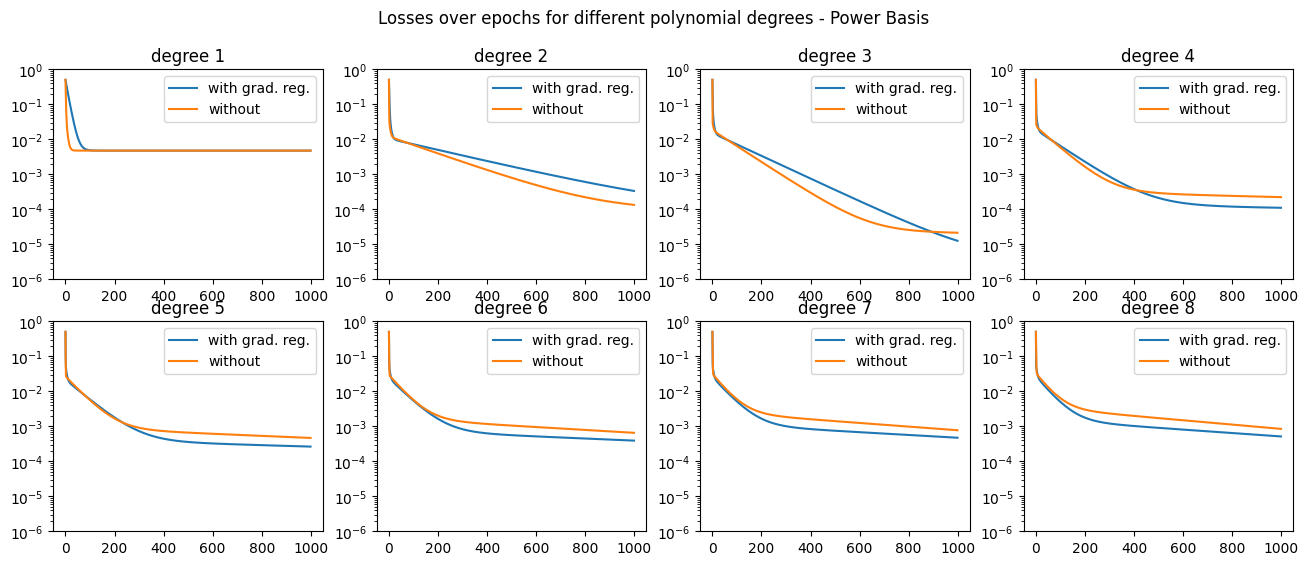

In [31]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees - Power Basis")

for i, d in enumerate(degrees):
    ax = axes[i]

    ax.set_title("degree %d" % d)

    ax.semilogy(splines_with[i].total_loss_values, label="with grad. reg.")
    ax.semilogy(splines_without[i].total_loss_values, label="without")
    ax.set_ylim([1e-6, 1e-0])
    ax.legend(loc="best")

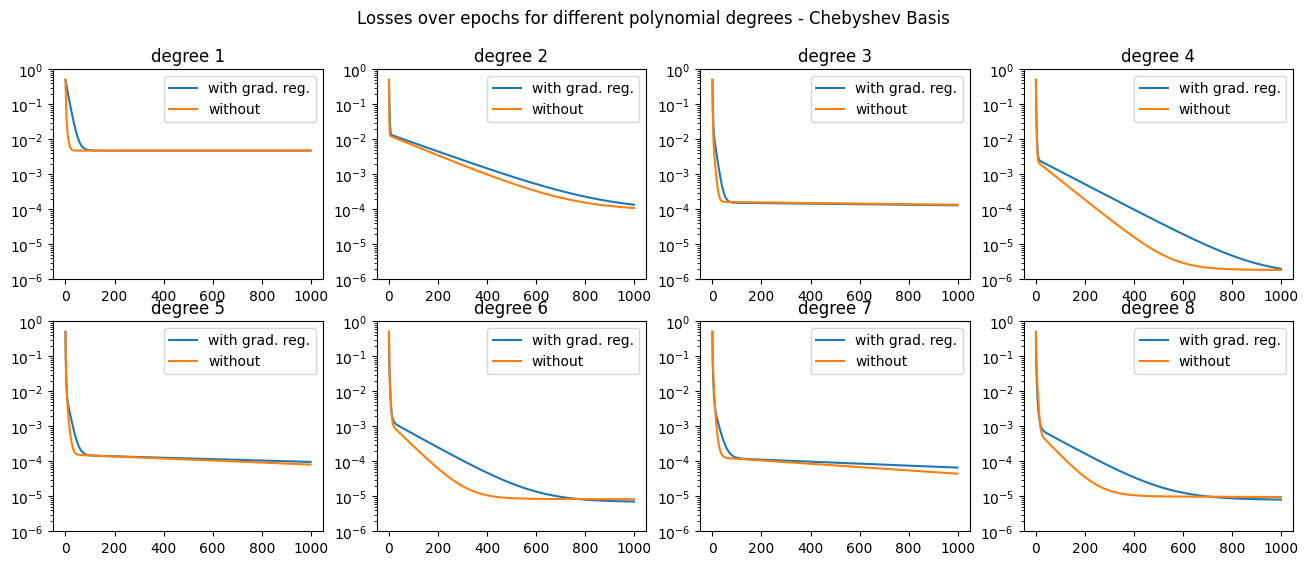

In [32]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees - Chebyshev Basis")

for i, d in enumerate(degrees):
    ax = axes[i]

    ax.set_title("degree %d" % d)

    ax.semilogy(splines_with_chebyshev[i].total_loss_values, label="with grad. reg.")
    ax.semilogy(splines_without_chebyshev[i].total_loss_values, label="without")
    ax.set_ylim([1e-6, 1e-0])
    ax.legend(loc="best")

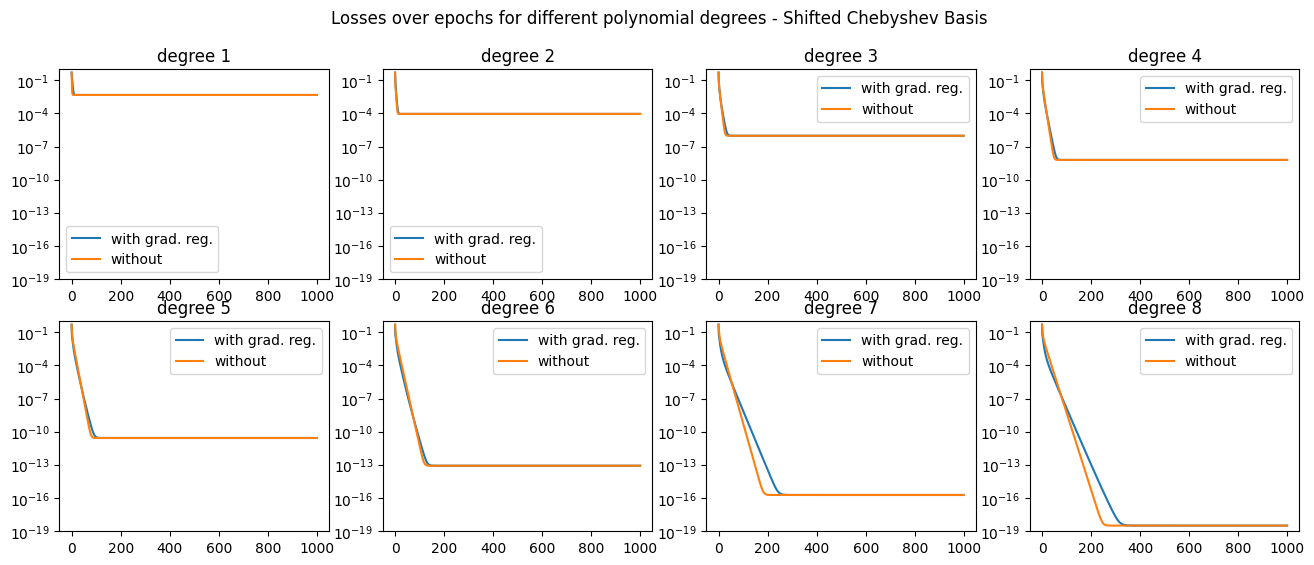

In [35]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees - Shifted Chebyshev Basis")

for i, d in enumerate(degrees):
    ax = axes[i]

    ax.set_title("degree %d" % d)

    ax.semilogy(splines_with_shifted_chebyshev[i].total_loss_values, label="with grad. reg.")
    ax.semilogy(splines_without_shifted_chebyshev[i].total_loss_values, label="without")
    ax.set_ylim([1e-19, 1e-0])
    ax.legend(loc="best")

### Interpretation
- The learning curves support our interpretation from above.

In [91]:
epochs = 100
shift_polynomial_centers = 'off'
numpoints = [4, 10, 20, 50, 100]
lrs = [10.0**e for e in np.arange(-2.0, 1.0, 0.25)]
#lrs = [10.0**e for e in np.arange(-2.0, 0.01, 0.25)]
args = [(n, lr) for n in numpoints for lr in lrs]

In [92]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'numpoints_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [93]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'numpoints_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [94]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'numpoints_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [95]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'numpoints_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [96]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': True,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'numpoints_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with_shifted_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [97]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False,
        'optimizer': 'SGD_VANILLA', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'mode': 'numpoints_and_learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without_shifted_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [98]:
# Slice the outermost list into sublists of specific number of points
sliced_results_with = [results_with[i:i+len(lrs)] for i in range(0, len(results_with), len(lrs))]
sliced_results_without = [results_without[i:i+len(lrs)] for i in range(0, len(results_without), len(lrs))]
sliced_results_with_chebyshev = [results_with_chebyshev[i:i+len(lrs)] for i in range(0, len(results_with), len(lrs))]
sliced_results_without_chebyshev = [results_without_chebyshev[i:i+len(lrs)] for i in range(0, len(results_without), len(lrs))]
sliced_results_with_shifted_chebyshev = [results_with_shifted_chebyshev[i:i+len(lrs)] for i in range(0, len(results_with), len(lrs))]
sliced_results_without_shifted_chebyshev = [results_without_shifted_chebyshev[i:i+len(lrs)] for i in range(0, len(results_without), len(lrs))]

# losses_with = [[0.0 for _ in range(len(lrs_ori))]] * len(sliced_results_with) # Bad! Creates Reference Copies of rows, thus duplicated rows in the end.
# losses_without = [[0.0 for _ in range(len(lrs_ori))]] * len(sliced_results_with)
losses_with = np.zeros((len(sliced_results_with), len(lrs)))
losses_without = np.zeros((len(sliced_results_with), len(lrs)))
losses_with_chebyshev = np.zeros((len(sliced_results_with), len(lrs)))
losses_without_chebyshev = np.zeros((len(sliced_results_with), len(lrs)))
losses_with_shifted_chebyshev = np.zeros((len(sliced_results_with), len(lrs)))
losses_without_shifted_chebyshev = np.zeros((len(sliced_results_with), len(lrs)))

# We want the loss value at epoch 100 of the learning rate of number of input points
for i in range(len(sliced_results_with)):
    for j in range(len(sliced_results_with[i])):
        losses_with[i][j] = sliced_results_with[i][j][1][-1]
        losses_without[i][j] = sliced_results_without[i][j][1][-1]
        losses_with_chebyshev[i][j] = sliced_results_with_chebyshev[i][j][1][-1]
        losses_without_chebyshev[i][j] = sliced_results_without_chebyshev[i][j][1][-1]
        losses_with_shifted_chebyshev[i][j] = sliced_results_with_shifted_chebyshev[i][j][1][-1]
        losses_without_shifted_chebyshev[i][j] = sliced_results_without_shifted_chebyshev[i][j][1][-1]

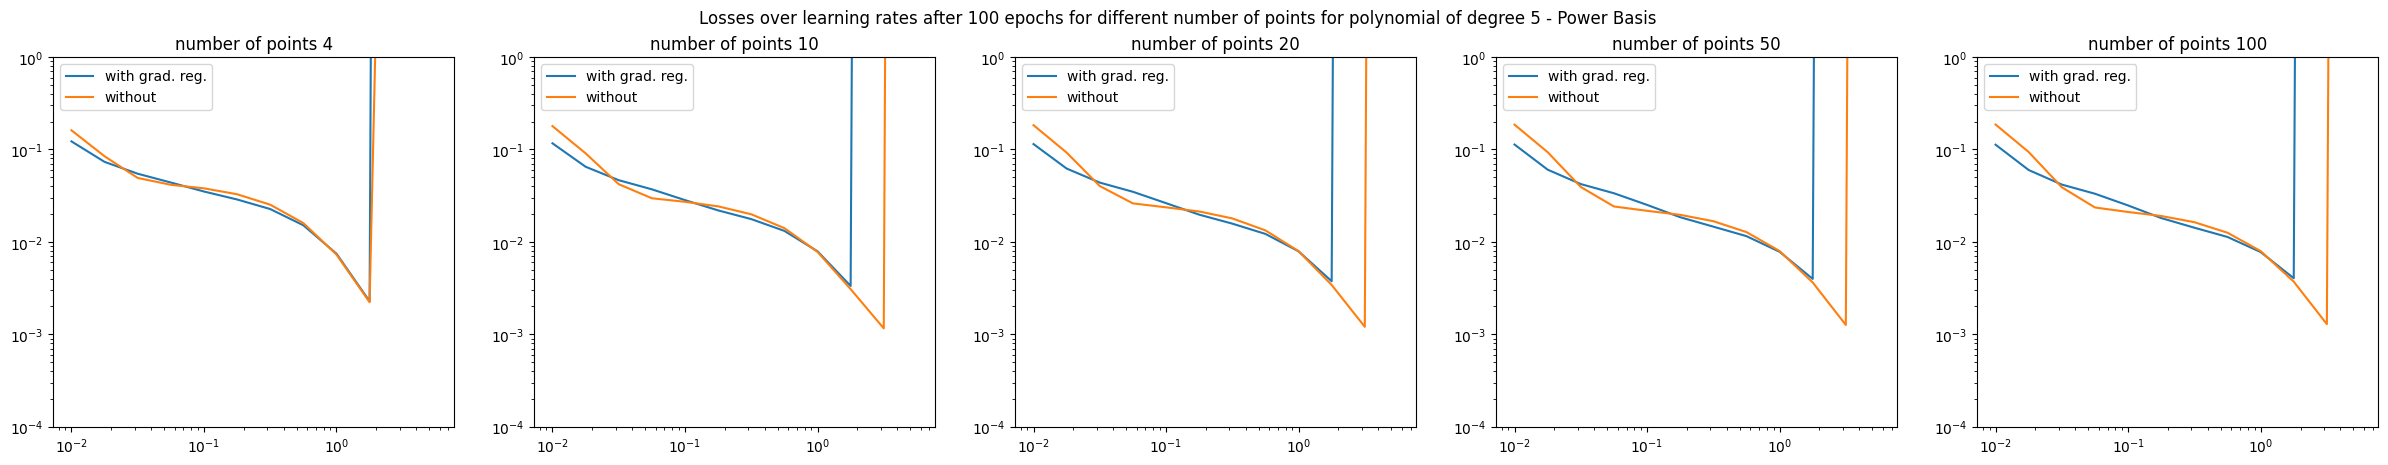

In [99]:
fig, axes = plt.subplots(1, len(numpoints))
axes = axes.flatten()
fig.set_figwidth(len(numpoints)*6)
#fig.set_figheight(6)
fig.suptitle("Losses over learning rates after %d epochs for different number of points for polynomial of degree 5 - Power Basis" % epochs)

for i, d in enumerate(numpoints):
    ax = axes[i]

    ax.set_title("number of points %d" % d)

    ax.loglog(lrs, losses_with[i], label="with grad. reg.")
    ax.loglog(lrs, losses_without[i], label="without")
    ax.set_ylim([1e-4, 1e-0])
    ax.legend(loc="best")

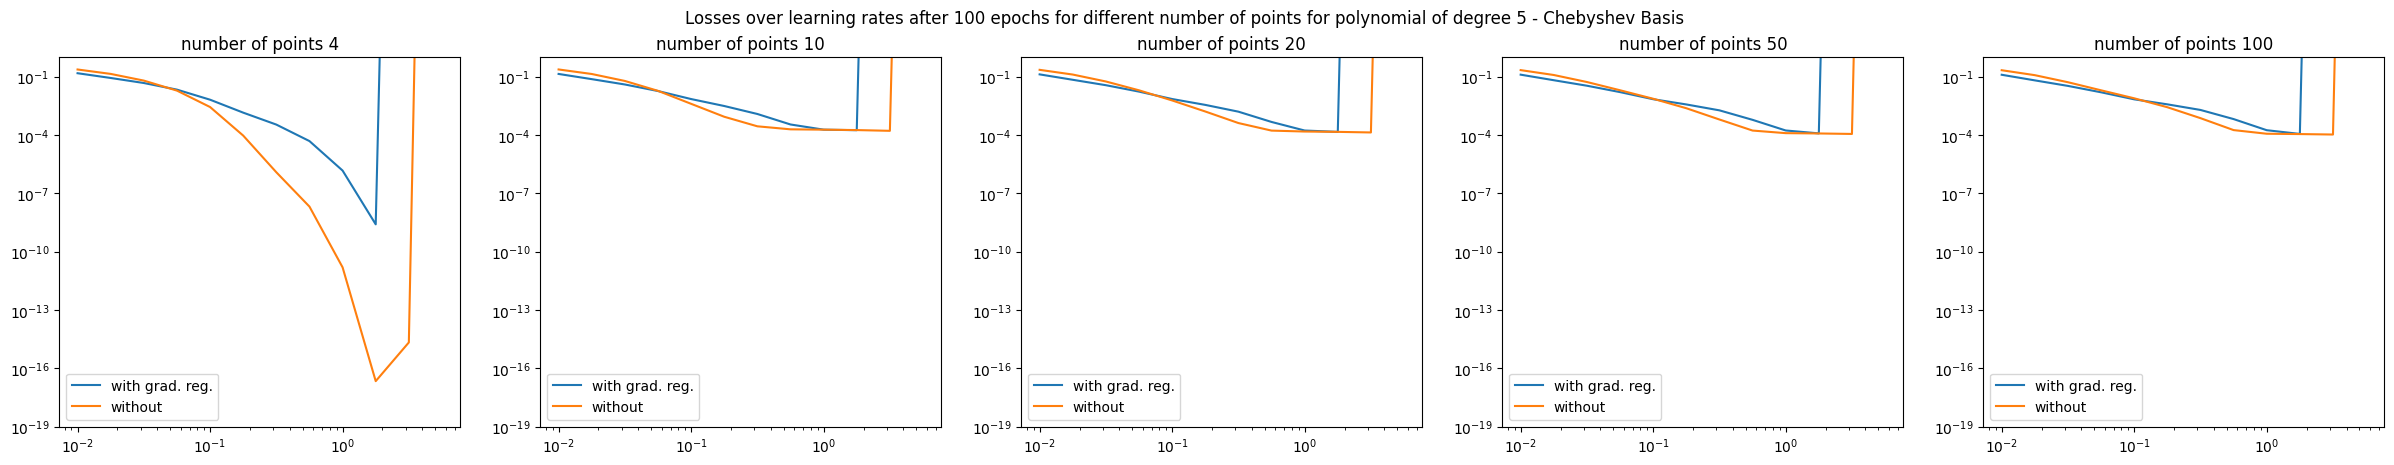

In [100]:
fig, axes = plt.subplots(1, len(numpoints))
axes = axes.flatten()
fig.set_figwidth(len(numpoints)*6)
#fig.set_figheight(6)
fig.suptitle("Losses over learning rates after %d epochs for different number of points for polynomial of degree 5 - Chebyshev Basis" % epochs)

for i, d in enumerate(numpoints):
    ax = axes[i]

    ax.set_title("number of points %d" % d)

    ax.loglog(lrs, losses_with_chebyshev[i], label="with grad. reg.")
    ax.loglog(lrs, losses_without_chebyshev[i], label="without")
    ax.set_ylim([1e-19, 1e-0])
    ax.legend(loc="best")

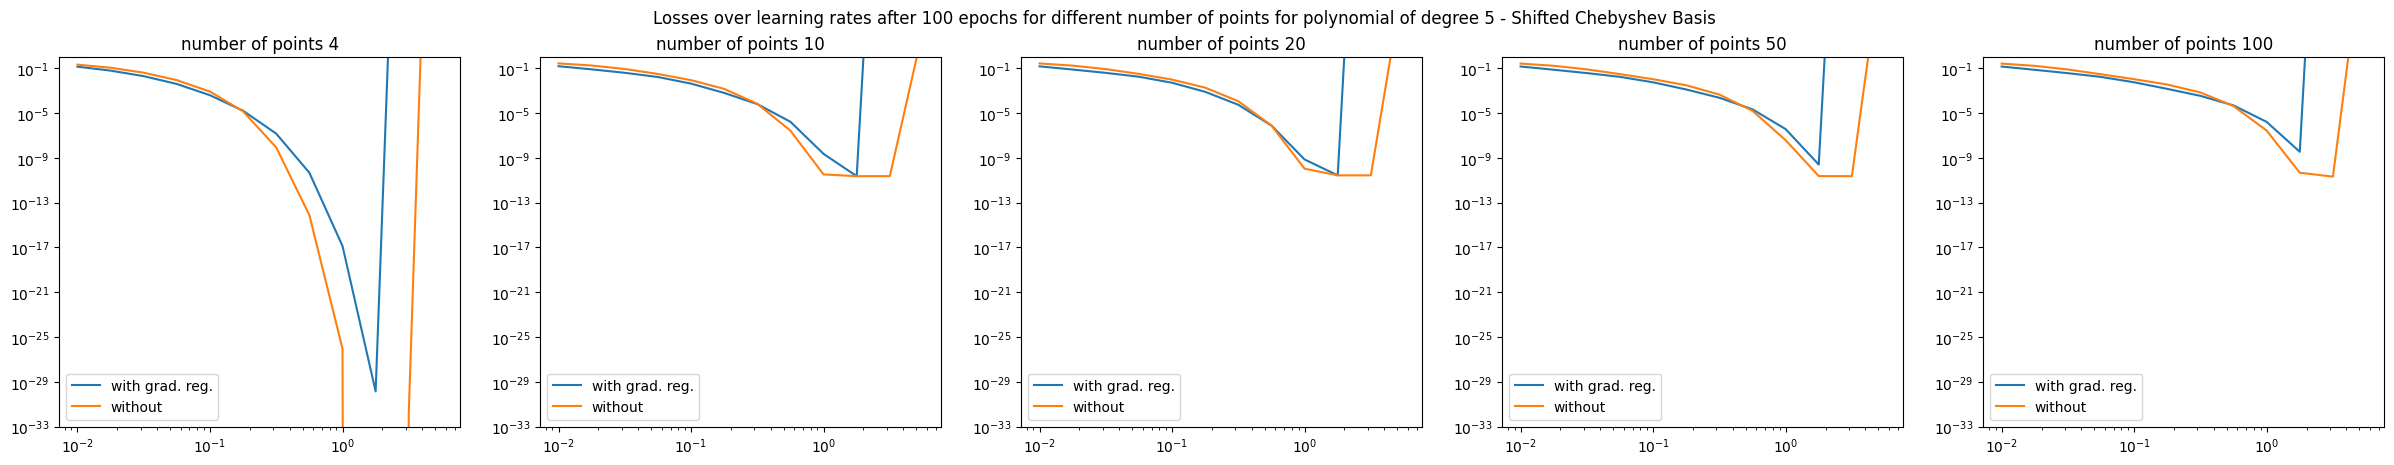

In [101]:
fig, axes = plt.subplots(1, len(numpoints))
axes = axes.flatten()
fig.set_figwidth(len(numpoints)*6)
#fig.set_figheight(6)
fig.suptitle("Losses over learning rates after %d epochs for different number of points for polynomial of degree 5 - Shifted Chebyshev Basis" % epochs)

for i, d in enumerate(numpoints):
    ax = axes[i]

    ax.set_title("number of points %d" % d)

    ax.loglog(lrs, losses_with_shifted_chebyshev[i], label="with grad. reg.")
    ax.loglog(lrs, losses_without_shifted_chebyshev[i], label="without")
    ax.set_ylim([1e-33, 1e-0])
    ax.legend(loc="best")

### Interpretation
**Power Basis**:
- Here we see how an increasing numer of points has a positive effect on convergence, i.e., we can have higher learning rates if we have a larger number of points. However, the effect is actually moderately small.
As seen in the beginning, we can have higher leanring rates without regularization.
- Interestingly, also with less than d+1 points (which would be 7 here), the method converges. But probably the polynomials are oscillating and a regulation by (square) total curvature would be needed.

**Chebyshev Basis and Shifted Chebyshev Basis**:
- Convergence with less than d+1 points performs the best. Raising the number of points to more than 10 has almost no effect to the highest learning rate we can achieve.

## Investigating optimizers

In [8]:
epochs = 5000
shift_polynomial_centers = 'off'
lr = 1.3
optimizers = ['sgd', 'sgd-momentum', 'sgd-momentum-nesterov', 'adam', 'adam-amsgrad', 'adamax', 'nadam', 'ftrl', 'rmsprop', 'adafactor', 'adamw', 'lion']

In [9]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': 0.1,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'power', 'mode': 'optimizers'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [10]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': 0.1,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'mode': 'optimizers'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [11]:
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]

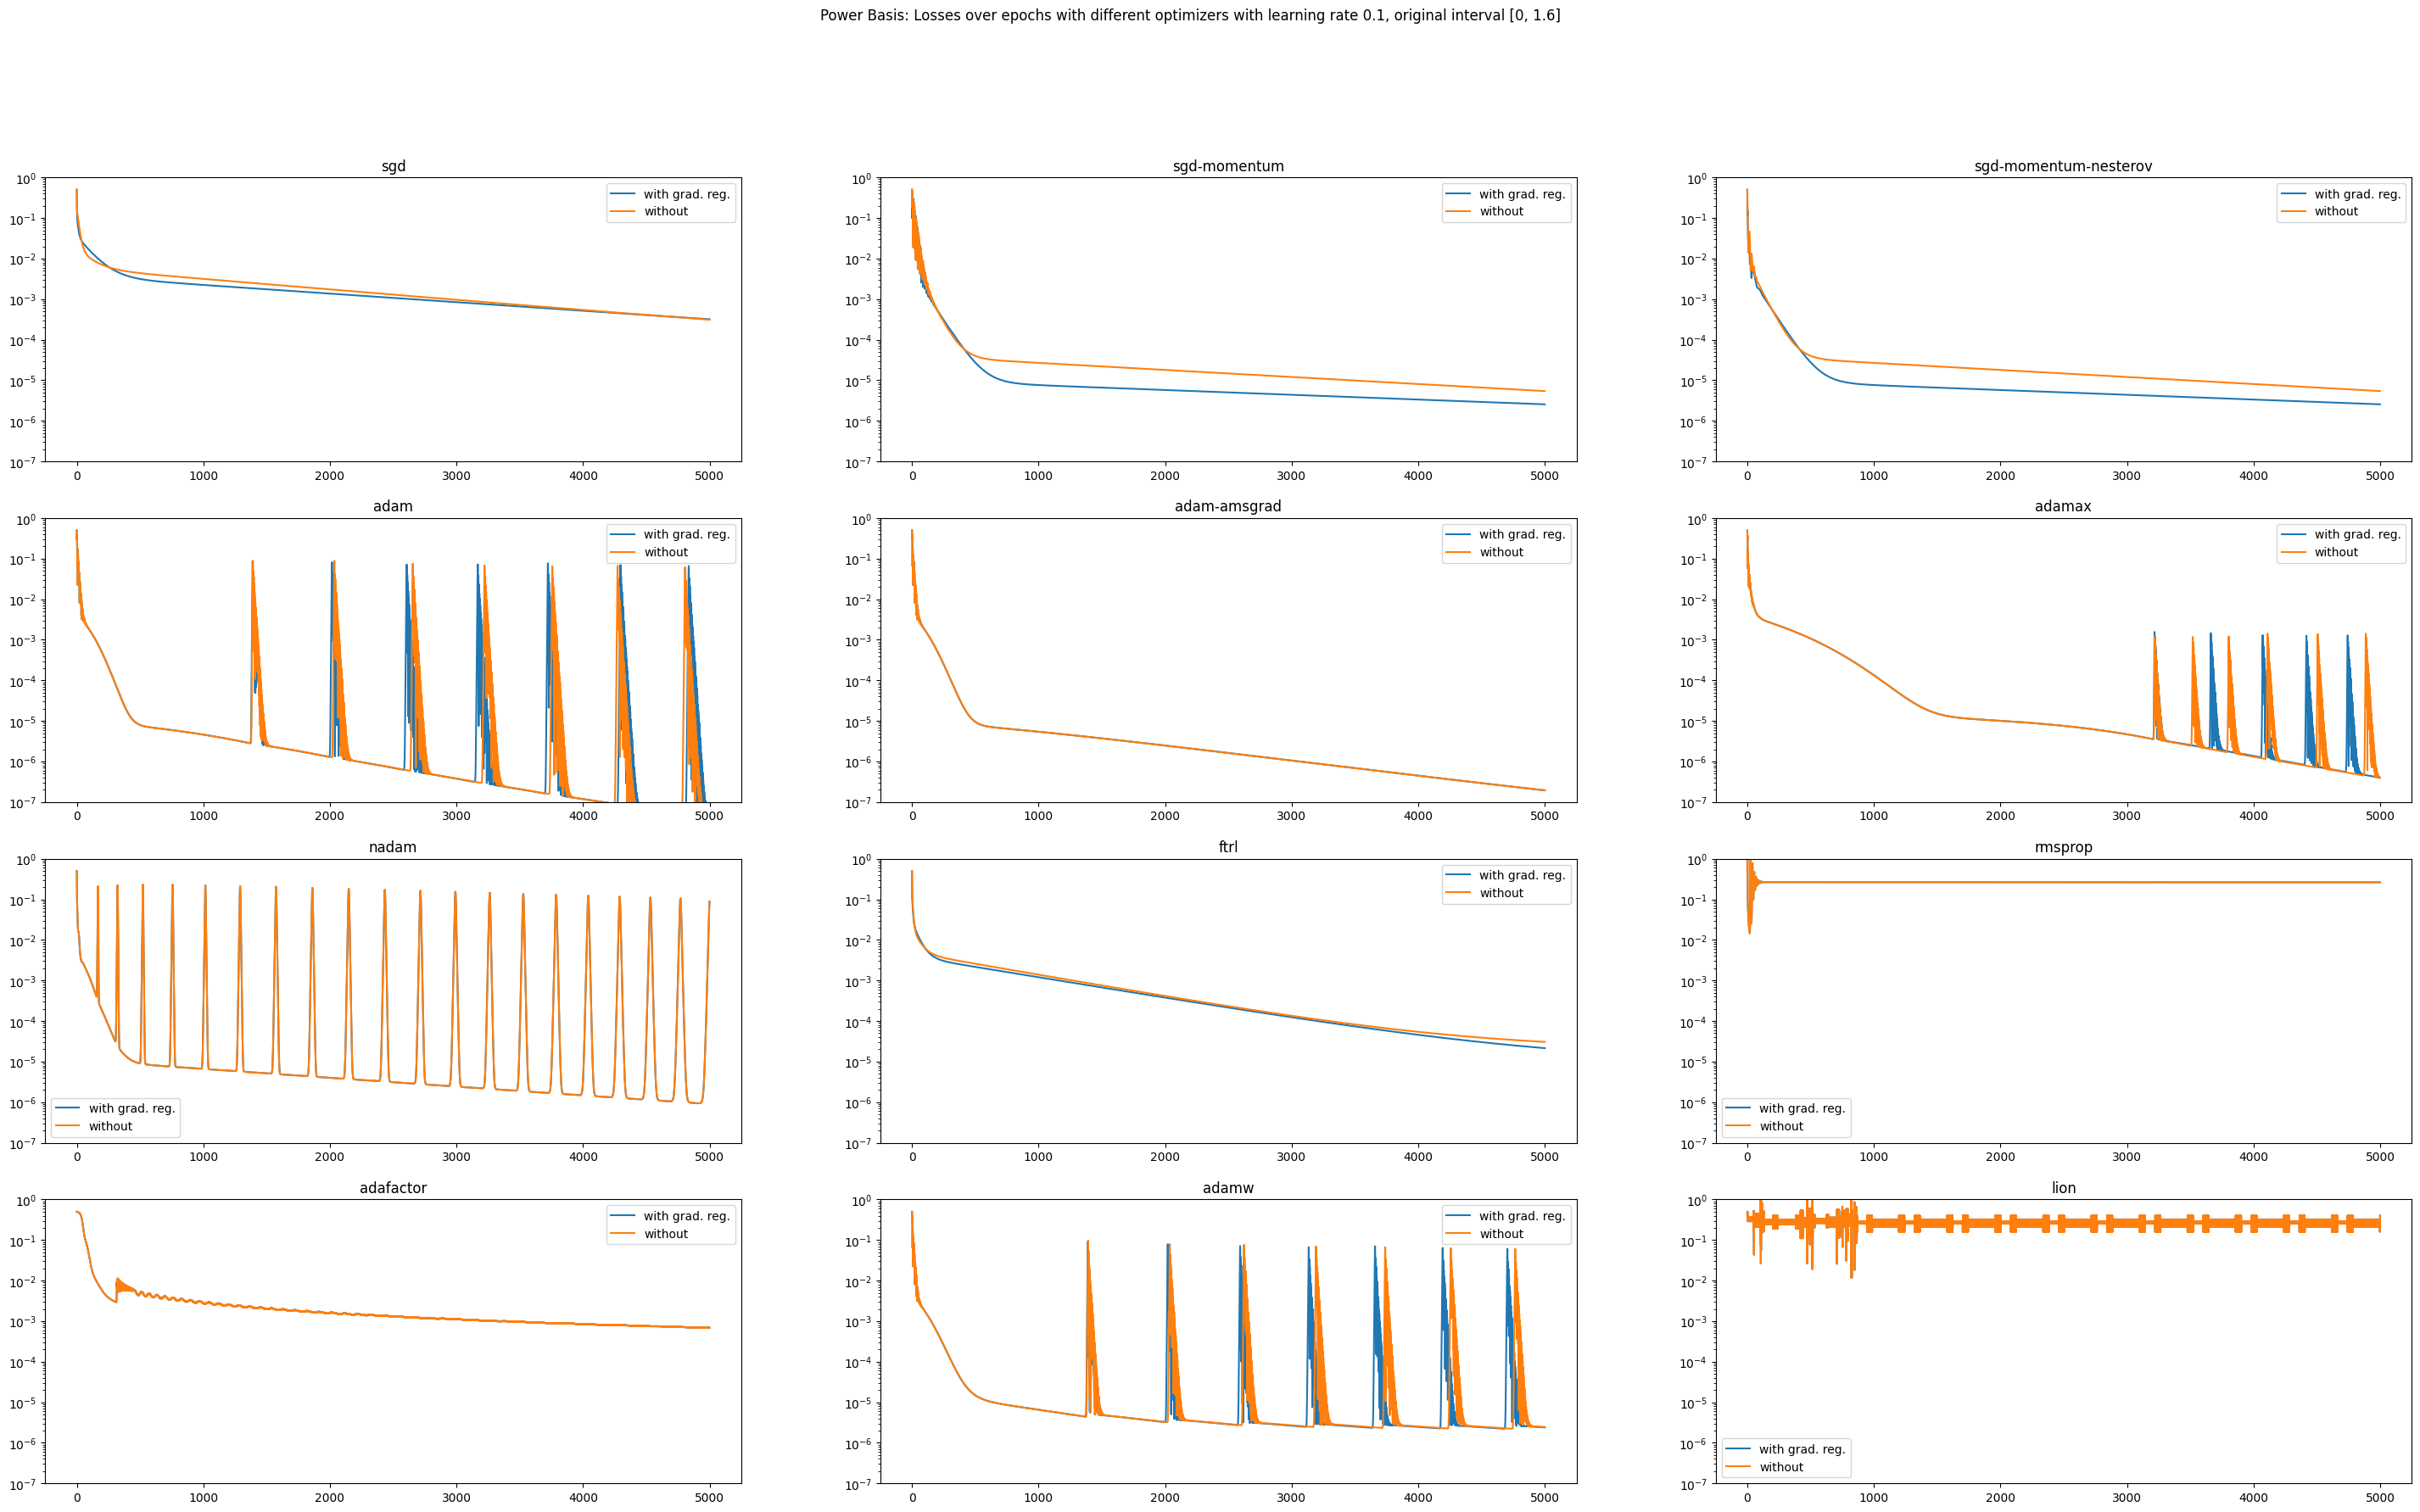

In [20]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Power Basis: Losses over epochs with different optimizers with learning rate 0.1, original interval [0, 1.6]')

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with[i], label="with grad. reg.")
    ax.semilogy(losses_without[i], label="without")
    ax.set_ylim([1e-7, 1e-0])
    ax.legend(loc="best")

In [21]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': 0.1,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'power', 'mode': 'optimizers'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [22]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': 0.1,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'mode': 'optimizers'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [23]:
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]

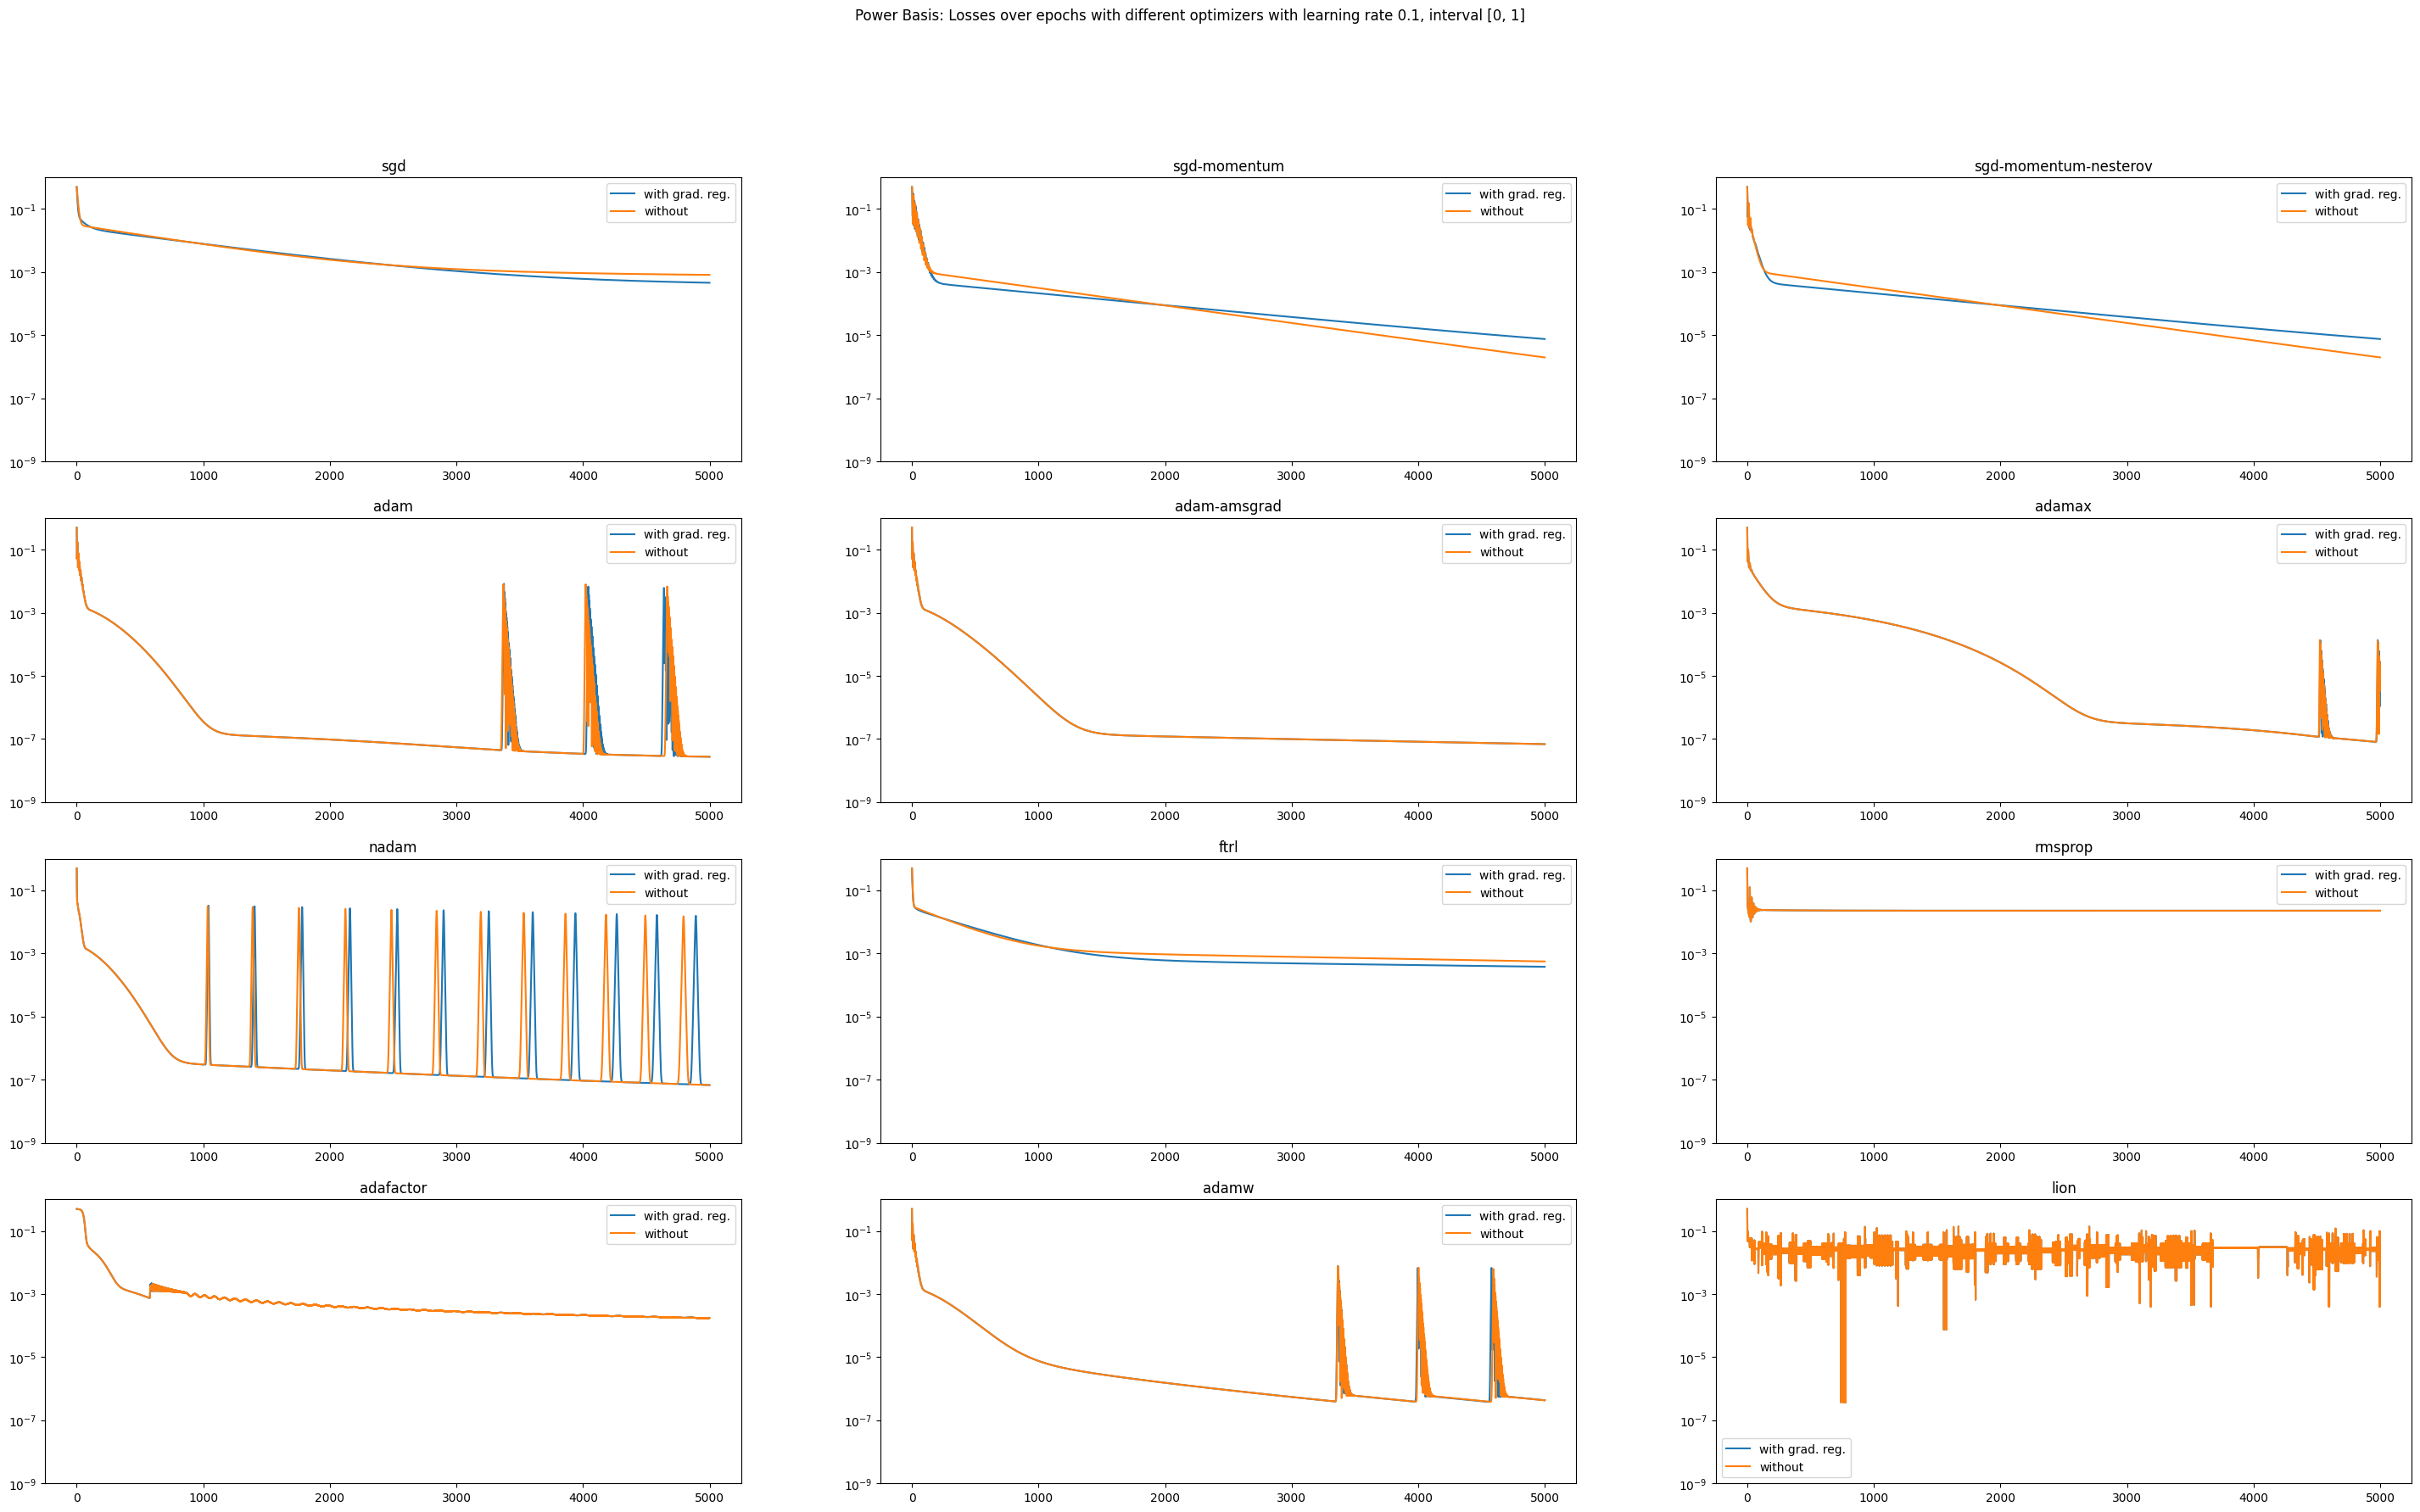

In [25]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Power Basis: Losses over epochs with different optimizers with learning rate 0.1, interval [0, 1]')

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with[i], label="with grad. reg.")
    ax.semilogy(losses_without[i], label="without")
    ax.set_ylim([1e-9, 1e-0])
    ax.legend(loc="best")

In [26]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'power', 'mode': 'optimizers'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [27]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'mode': 'optimizers'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [28]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'chebyshev', 'mode': 'optimizers'}

pool = mp.Pool(mp.cpu_count())
results_with_chebyshev = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [29]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'mode': 'optimizers'}

pool = mp.Pool(mp.cpu_count())
results_without_chebyshev = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [30]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'shifted_chebyshev', 'mode': 'optimizers'}

pool = mp.Pool(mp.cpu_count())
results_with_shifted_chebyshev = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [31]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'mode': 'optimizers'}

pool = mp.Pool(mp.cpu_count())
results_without_shifted_chebyshev = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [32]:
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)
losses_with_chebyshev = [0.0] * len(results_with)
losses_without_chebyshev = [0.0] * len(results_with)
losses_with_shifted_chebyshev = [0.0] * len(results_with)
losses_without_shifted_chebyshev = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_with_chebyshev[i] = results_with_chebyshev[i][1]
    losses_without_chebyshev[i] = results_without_chebyshev[i][1]
    losses_with_shifted_chebyshev[i] = results_with_shifted_chebyshev[i][1]
    losses_without_shifted_chebyshev[i] = results_without_shifted_chebyshev[i][1]

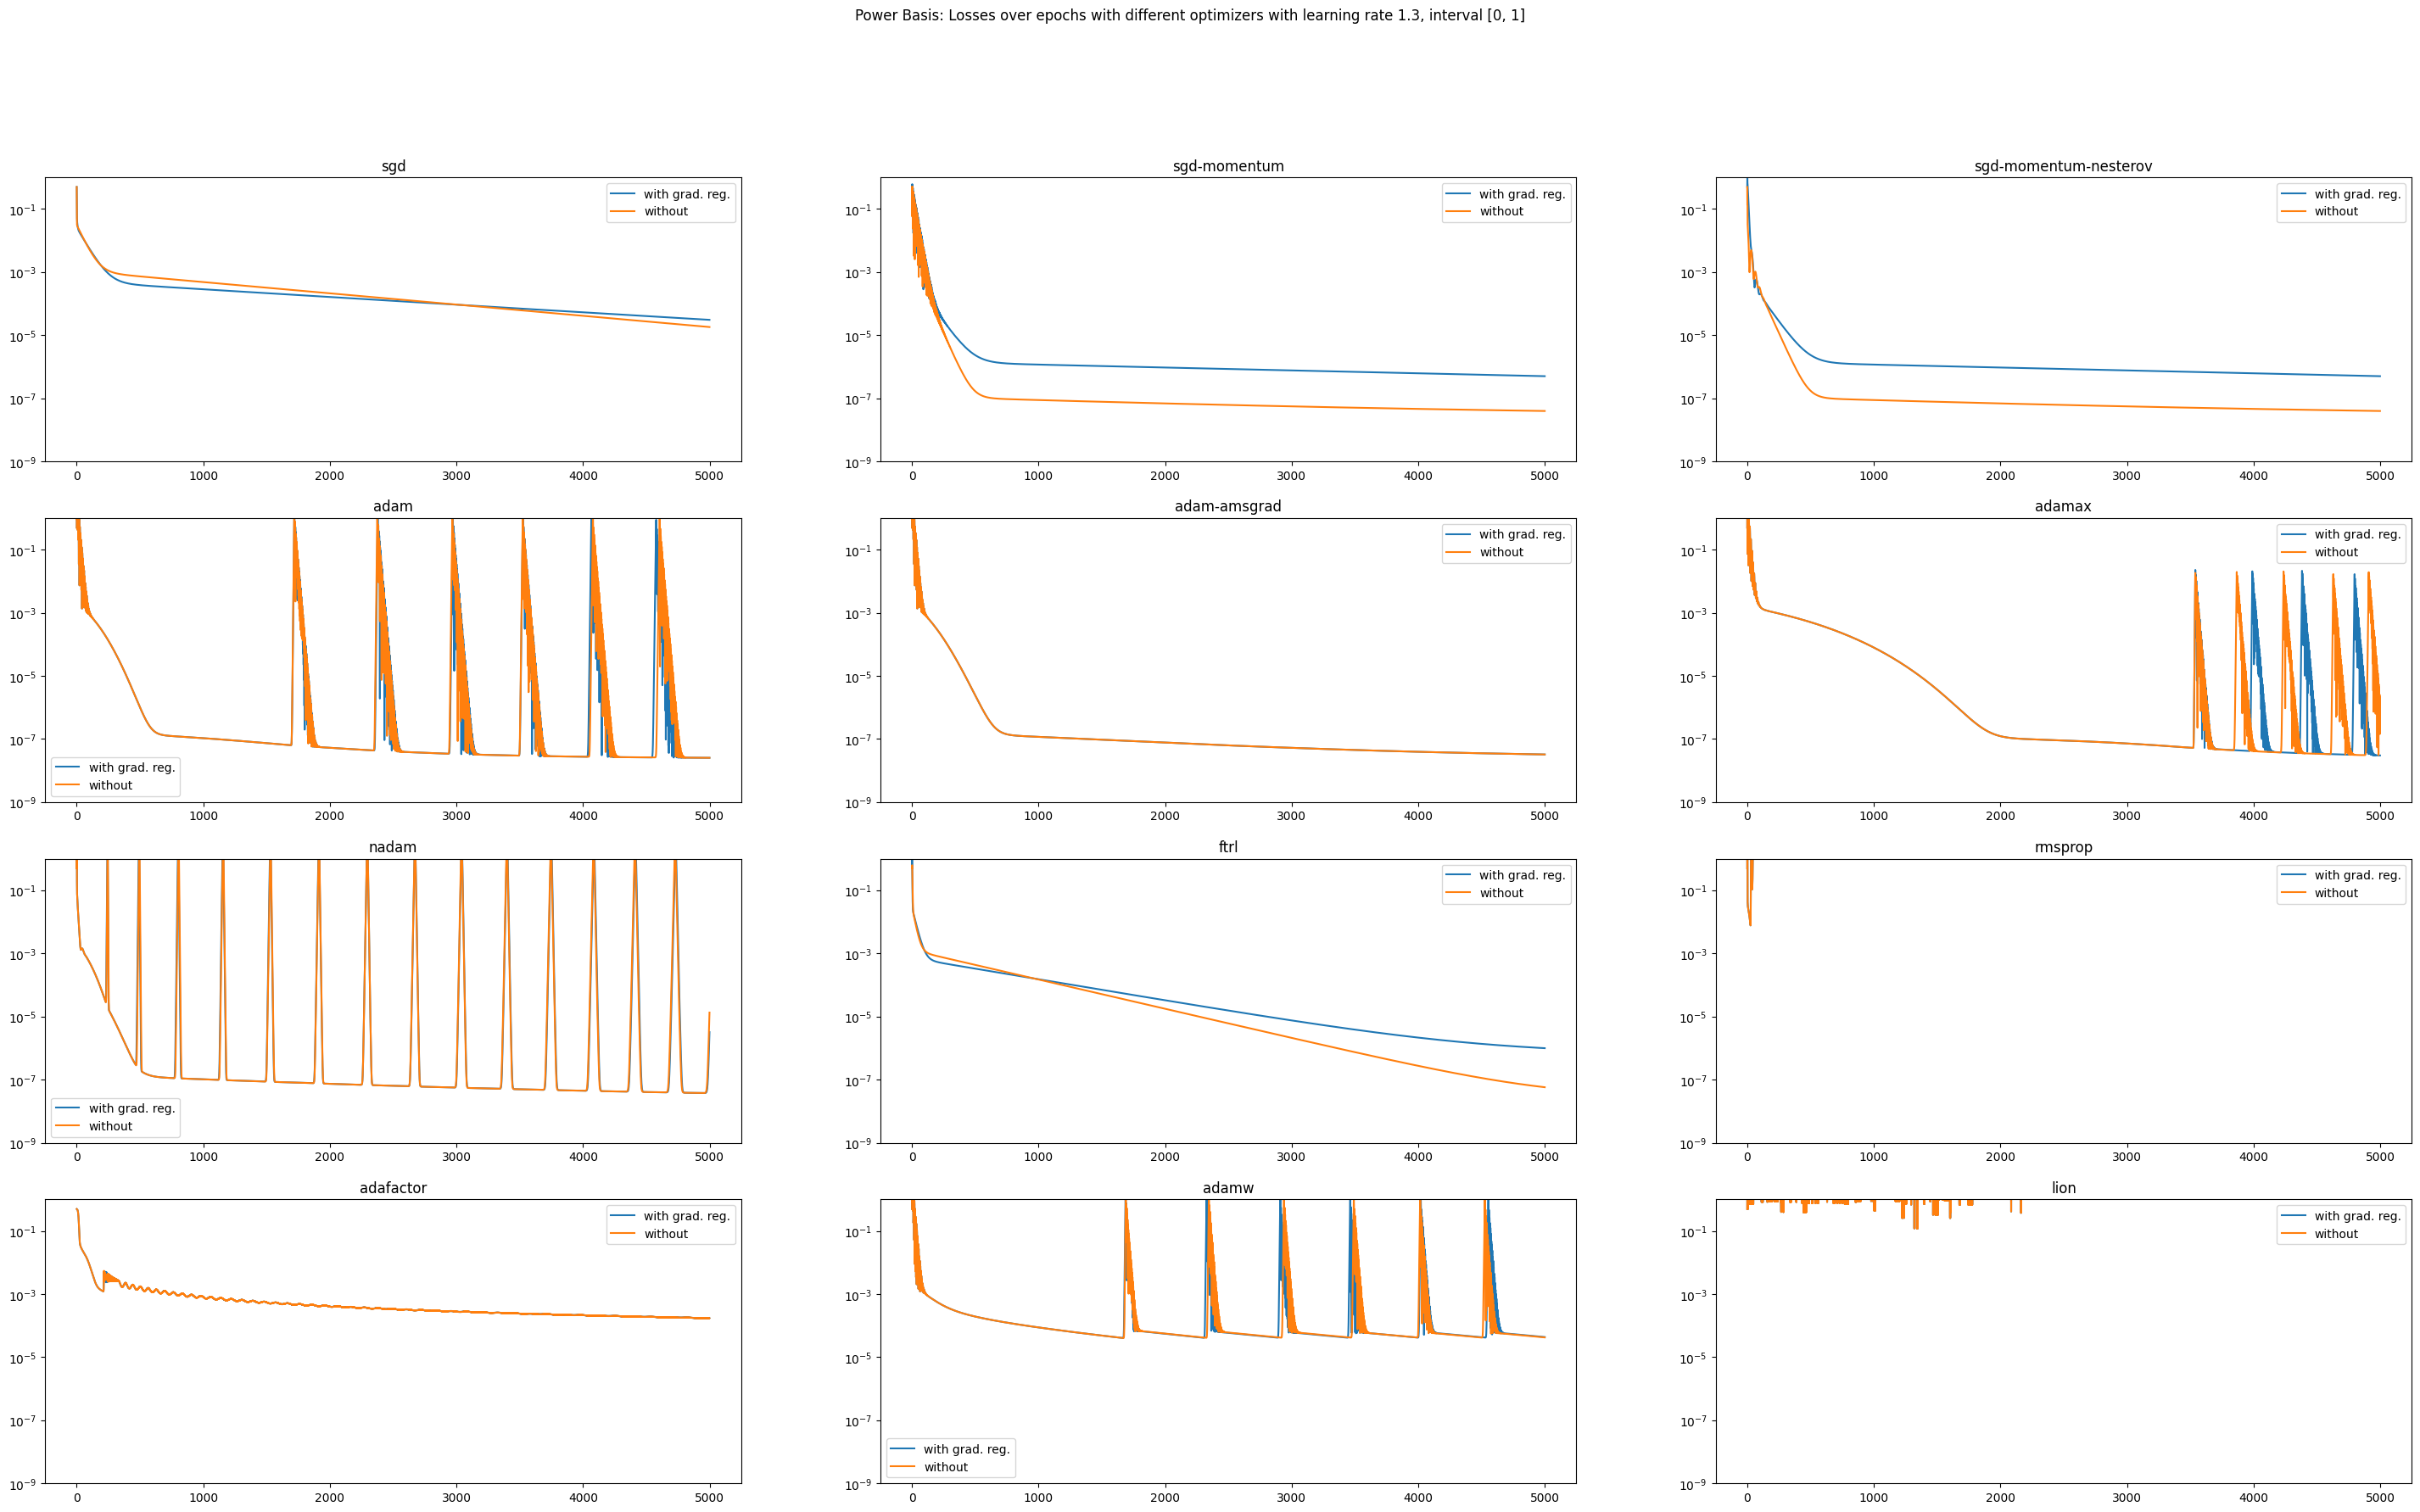

In [33]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Power Basis: Losses over epochs with different optimizers with learning rate {lr:.4g}, interval [0, 1]')

for i, opt in enumerate(optimizers):
    ax = axes[i]
    
    ax.set_title("%s" % opt)
      
    ax.semilogy(losses_with[i], label="with grad. reg.")
    ax.semilogy(losses_without[i], label="without")
    ax.set_ylim([1e-9, 1e-0])
    ax.legend(loc="best")

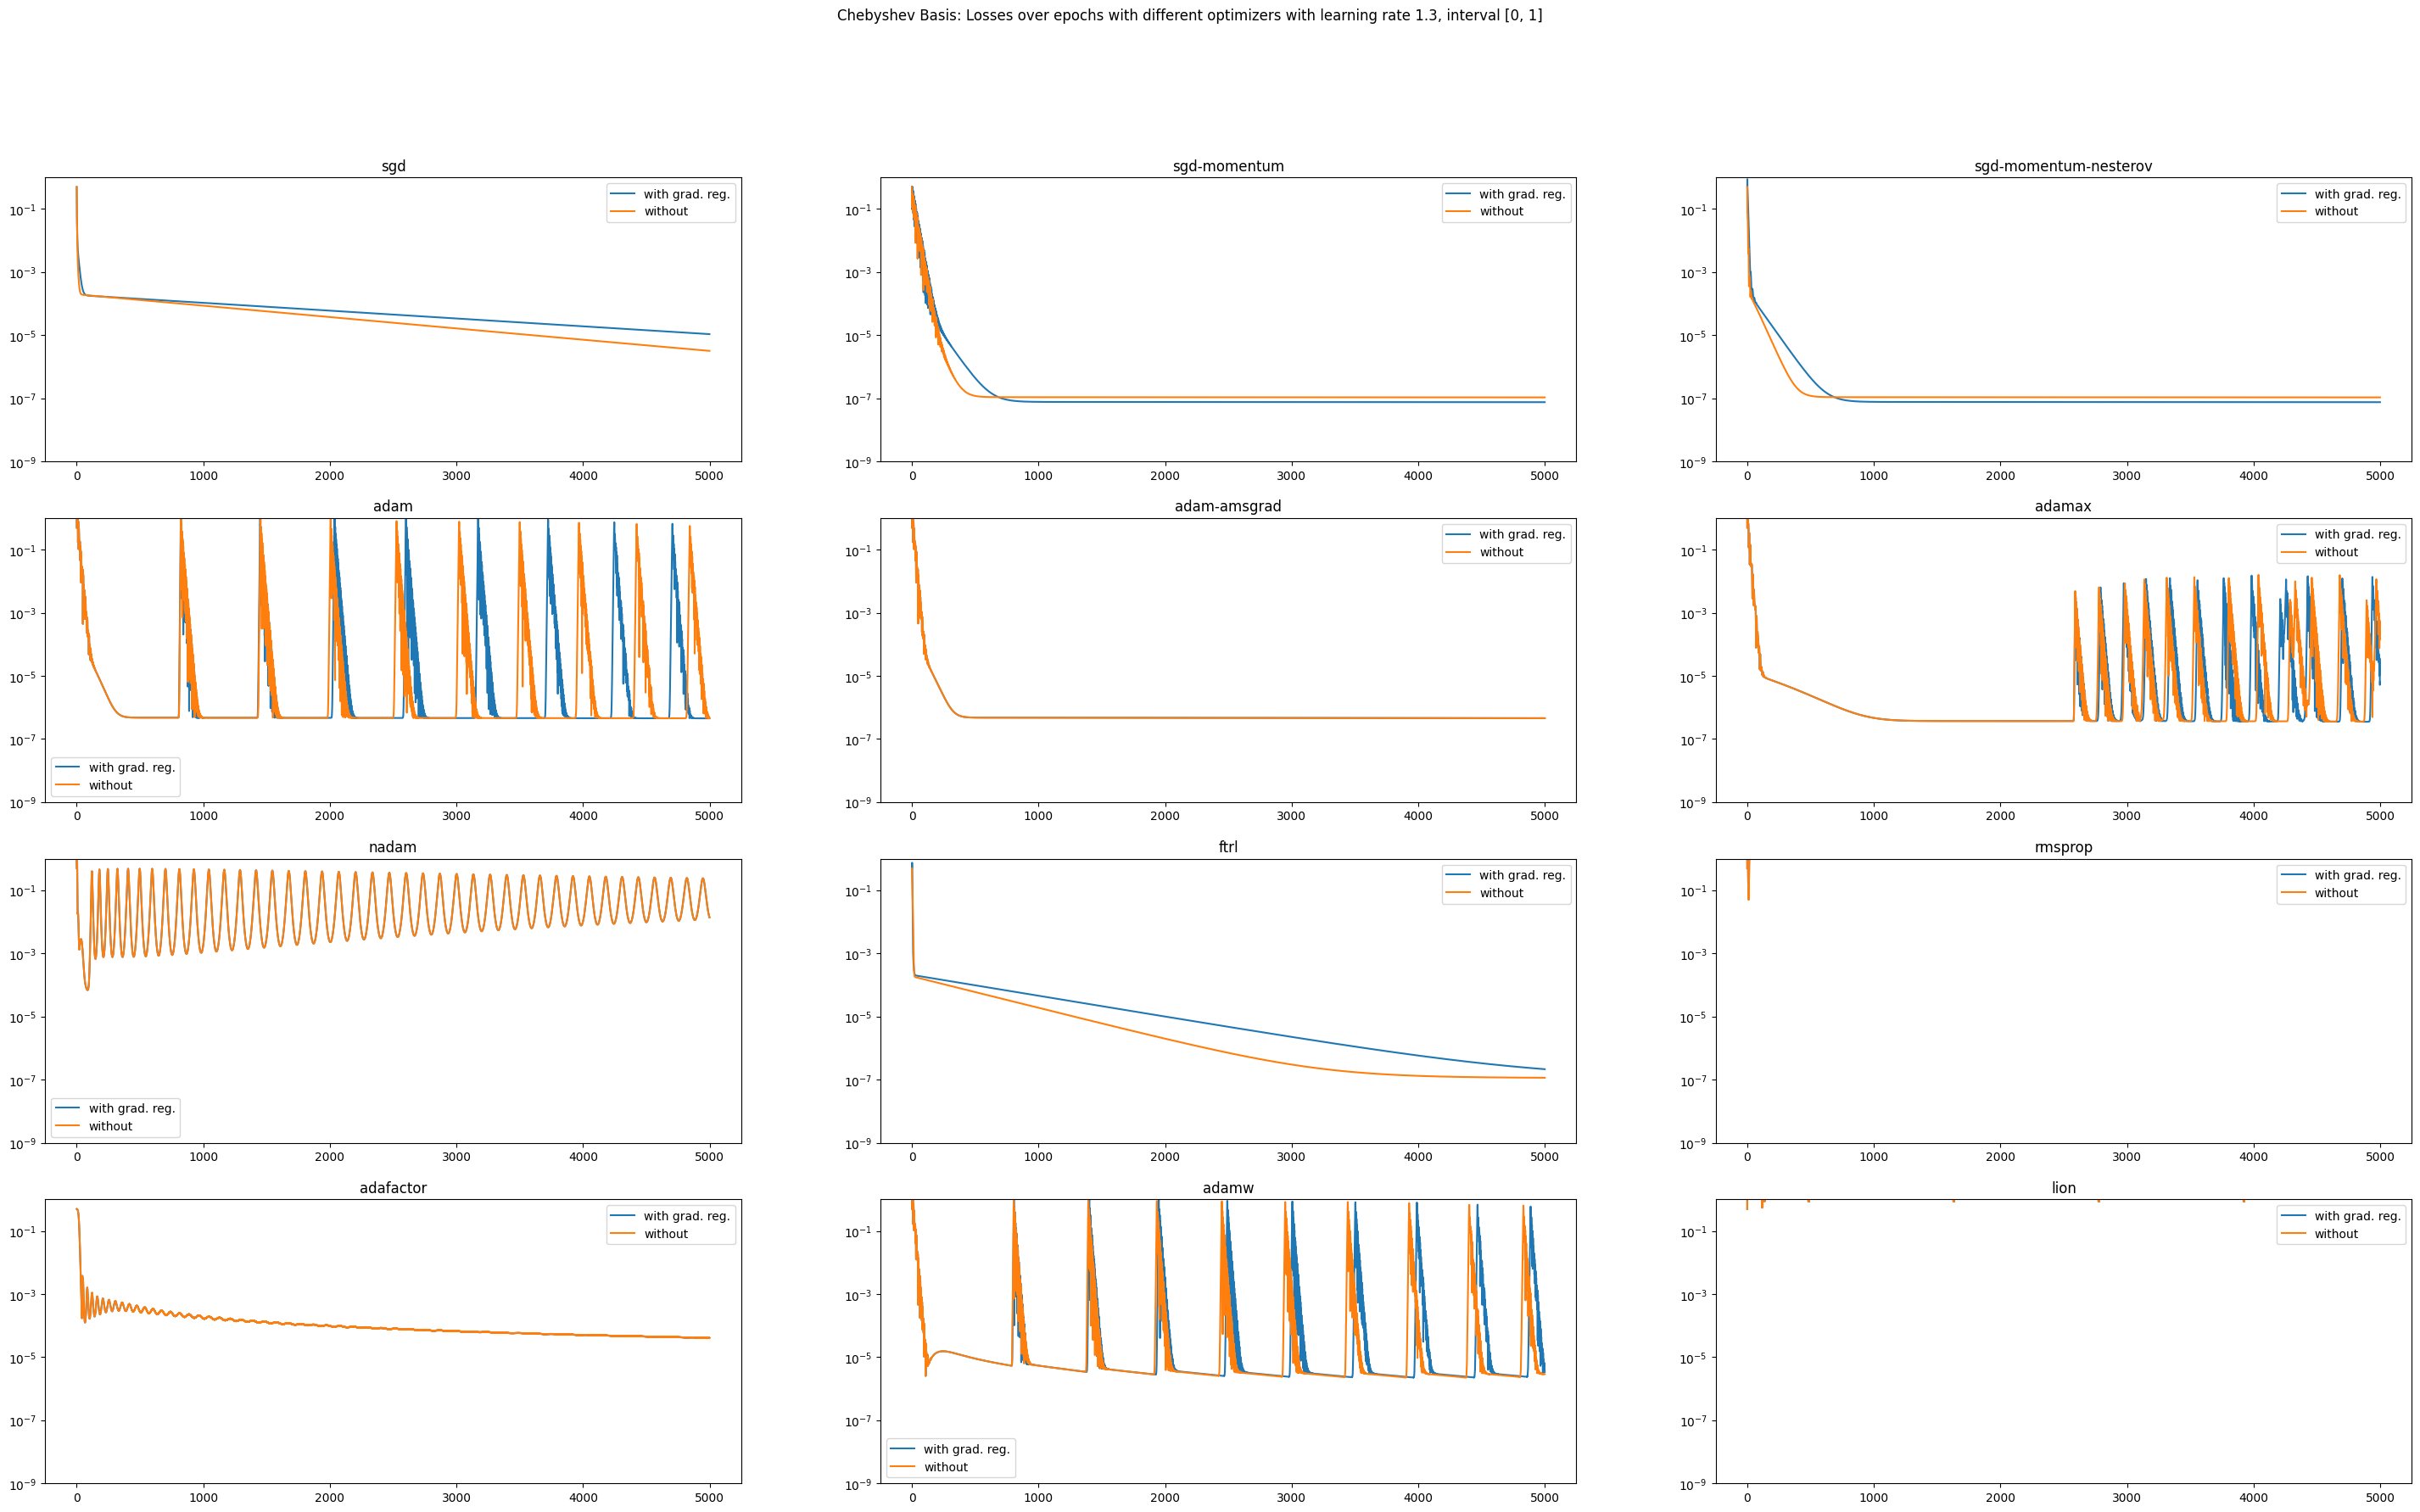

In [34]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Chebyshev Basis: Losses over epochs with different optimizers with learning rate {lr:.4g}, interval [0, 1]')

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with_chebyshev[i], label="with grad. reg.")
    ax.semilogy(losses_without_chebyshev[i], label="without")
    ax.set_ylim([1e-9, 1e-0])
    ax.legend(loc="best")

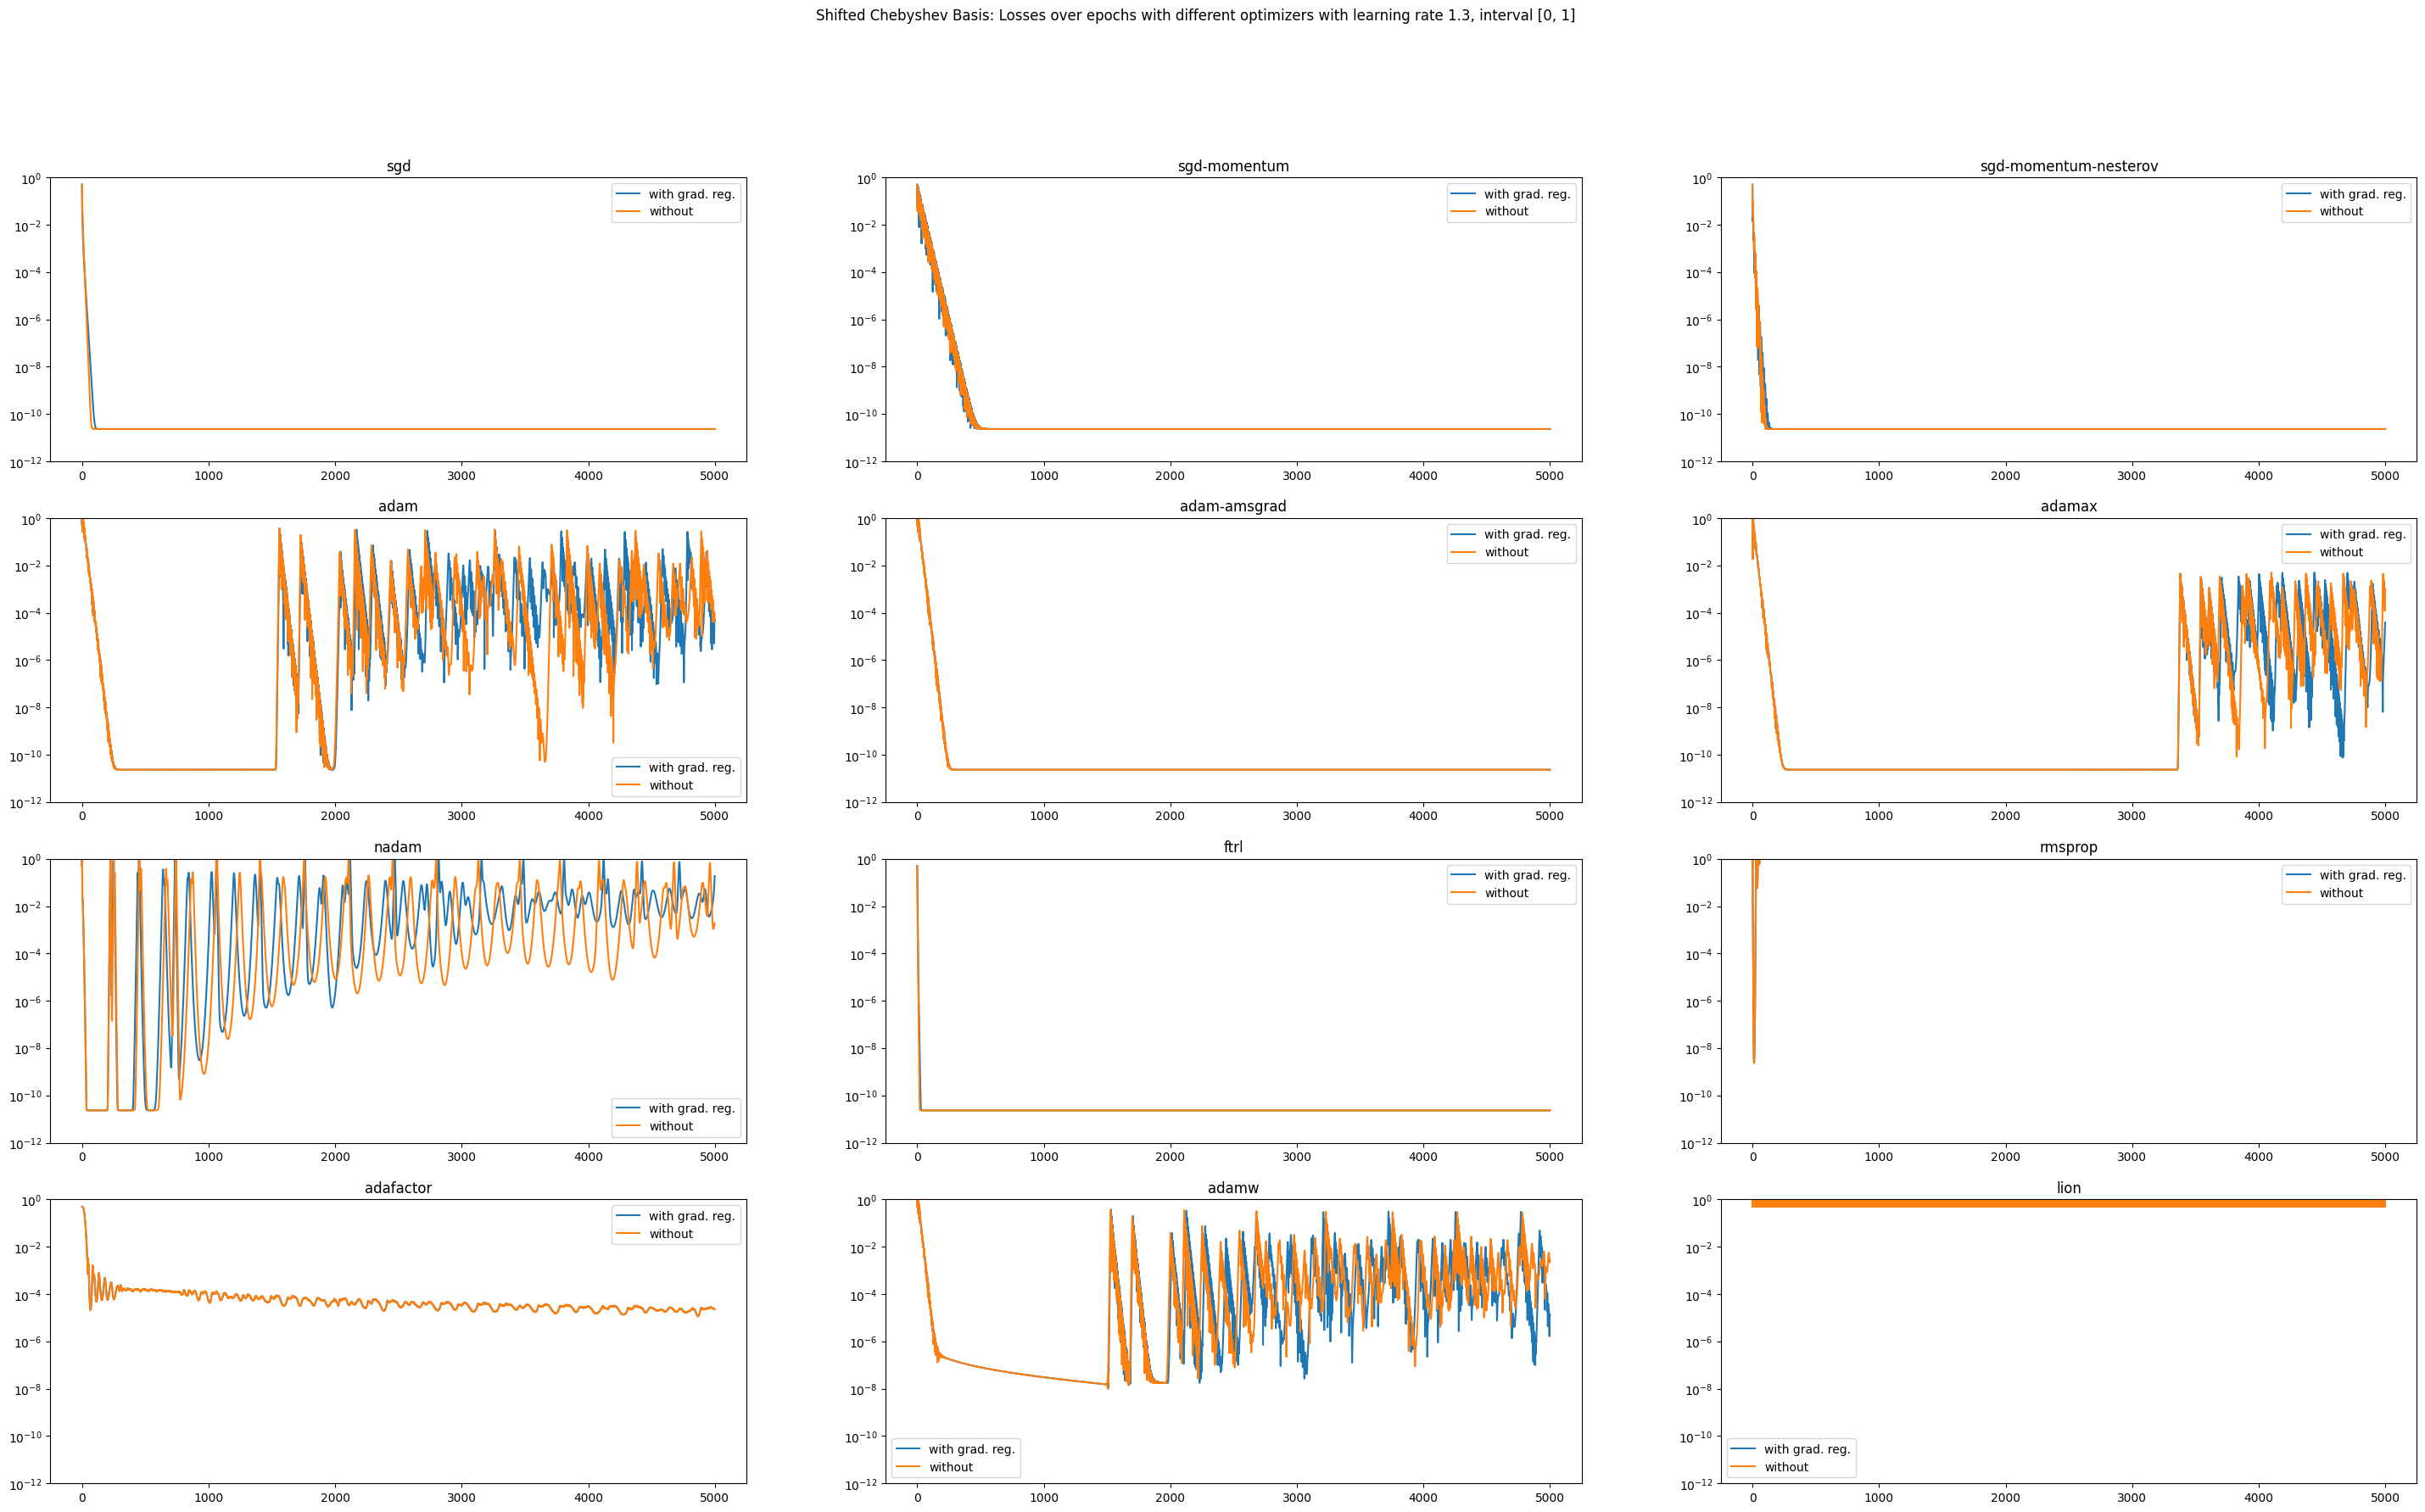

In [35]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4)
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Shifted Chebyshev Basis: Losses over epochs with different optimizers with learning rate {lr:.4g}, interval [0, 1]')

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses_with_shifted_chebyshev[i], label="with grad. reg.")
    ax.semilogy(losses_without_shifted_chebyshev[i], label="without")
    ax.set_ylim([1e-12, 1e-0])
    ax.legend(loc="best")

### Interpretation
**SGD**
With Power Basis and Chebyshev basis, SGD with Nesterov Momentum performs best.
Surprisingly, with Shifted Chebyshev Basis, Vanilla SGD outperforms its momentum counterparts.

**Adam**
Adam AMSGrad performs best out of all the Adam optimizers in terms of stability.

**ftrl**
Shows good overall performance with Power and Chebyshev Basis, but outstanding performance with Shifted Chebyshev basis.


## Investigating momentum of SGD

In [44]:
epochs = 500
shift_polynomial_centers = 'off'
lr = 1.3
momentums = [m for m in [0.0, 0.75, 0.9, 0.95, 0.98]]

In [45]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': 0.1,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'power', 'mode': 'sgd-nesterov-momentum'}

pool = mp.Pool(mp.cpu_count())
results_with_nesterov = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [46]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': 0.1,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'mode': 'sgd-nesterov-momentum'}

pool = mp.Pool(mp.cpu_count())
results_without_nesterov = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [47]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': 0.1,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'power', 'mode': 'sgd-momentum'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [48]:
kwargs = {'data_x': xs_ori, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': 0.1,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'power', 'mode': 'sgd-momentum'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [49]:
losses_with = [0.0] * len(results_with)
losses_with_nesterov = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)
losses_without_nesterov = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_with_nesterov[i] = results_with_nesterov[i][1]
    losses_without_nesterov[i] = results_without_nesterov[i][1]

Text(0.5, 1.0, 'With Nesterov')

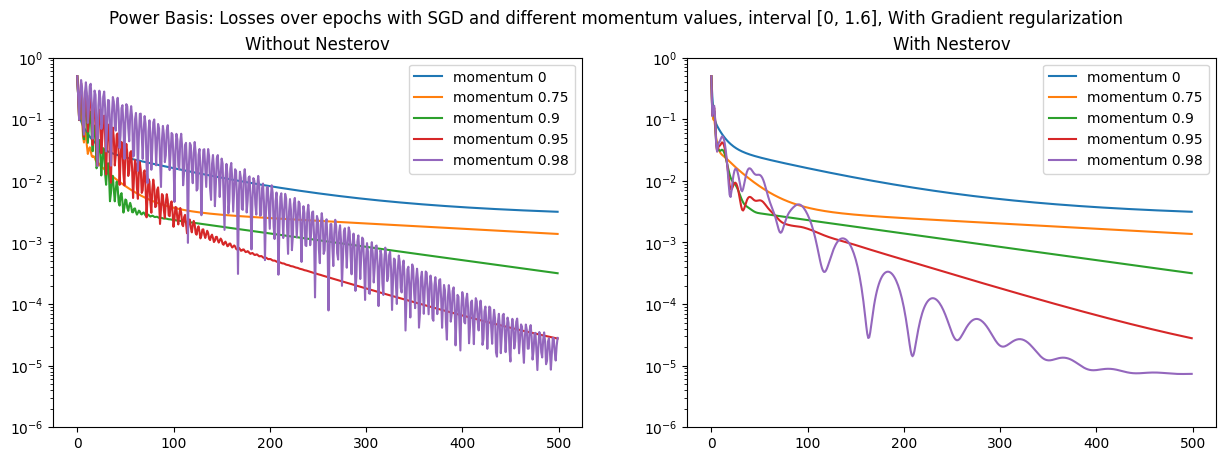

In [53]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(momentums)*3)
fig.suptitle("Power Basis: Losses over epochs with SGD and different momentum values, interval [0, 1.6], With Gradient regularization")

for i, m in enumerate(momentums):
    ax1.semilogy(losses_with[i], label="momentum %.2g" % m)
    ax2.semilogy(losses_with_nesterov[i], label="momentum %.2g" % m)

for ax in (ax1, ax2):
    ax.set_ylim([1e-6, 1e-0])
    ax.legend(loc="best")
    
ax1.set_title("Without Nesterov")
ax2.set_title("With Nesterov")

Text(0.5, 1.0, 'With Nesterov')

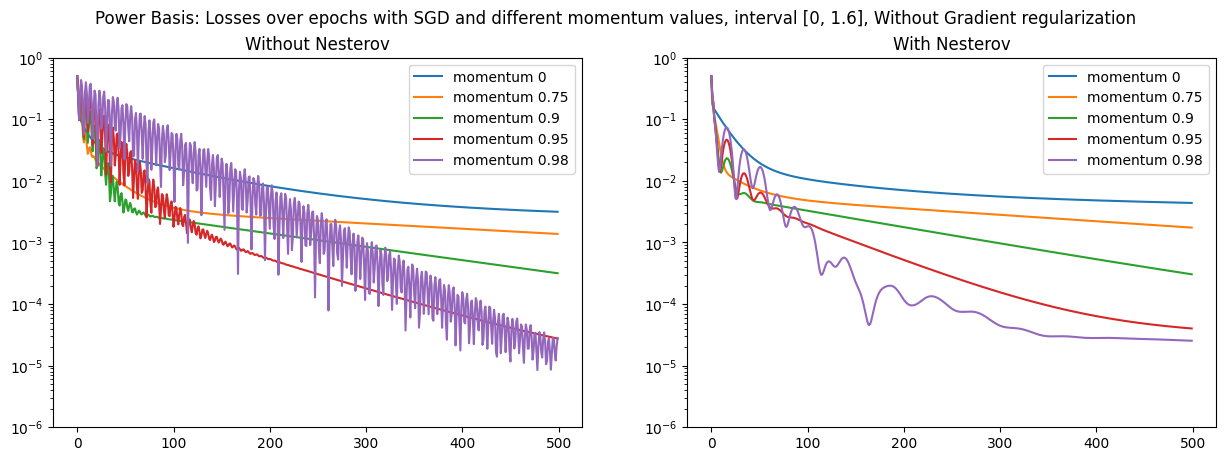

In [55]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(momentums)*3)
fig.suptitle("Power Basis: Losses over epochs with SGD and different momentum values, interval [0, 1.6], Without Gradient regularization")

for i, m in enumerate(momentums):
    ax1.semilogy(losses_without[i], label="momentum %.2g" % m)
    ax2.semilogy(losses_without_nesterov[i], label="momentum %.2g" % m)

for ax in (ax1, ax2):
    ax.set_ylim([1e-6, 1e-0])
    ax.legend(loc="best")

ax1.set_title("Without Nesterov")
ax2.set_title("With Nesterov")

In [110]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'power', 'mode': 'sgd-nesterov-momentum'}

pool = mp.Pool(mp.cpu_count())
results_with_nesterov = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [111]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'mode': 'sgd-nesterov-momentum'}

pool = mp.Pool(mp.cpu_count())
results_without_nesterov = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [112]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'power', 'mode': 'sgd-momentum'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [113]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'mode': 'sgd-momentum'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [114]:
losses_with = [0.0] * len(results_with)
losses_with_nesterov = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)
losses_without_nesterov = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_with_nesterov[i] = results_with_nesterov[i][1]
    losses_without_nesterov[i] = results_without_nesterov[i][1]

Text(0.5, 1.0, 'With Nesterov')

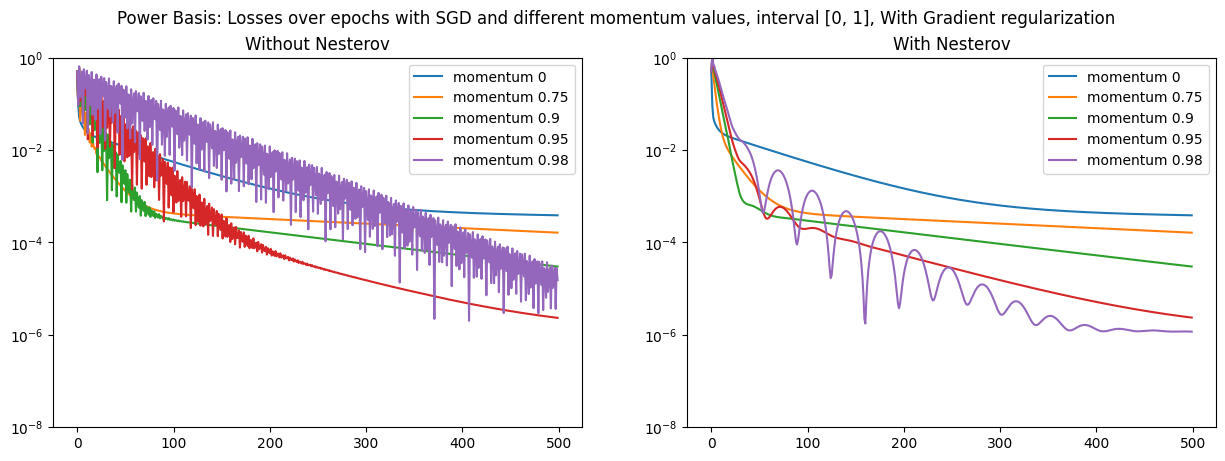

In [115]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(momentums)*3)
fig.suptitle("Power Basis: Losses over epochs with SGD and different momentum values, interval [0, 1], With Gradient regularization")

for i, m in enumerate(momentums):
    ax1.semilogy(losses_with[i], label="momentum %.2g" % m)
    ax2.semilogy(losses_with_nesterov[i], label="momentum %.2g" % m)

for ax in (ax1, ax2):
    ax.set_ylim([1e-8, 1e-0])
    ax.legend(loc="best")

ax1.set_title("Without Nesterov")
ax2.set_title("With Nesterov")

Text(0.5, 1.0, 'With Nesterov')

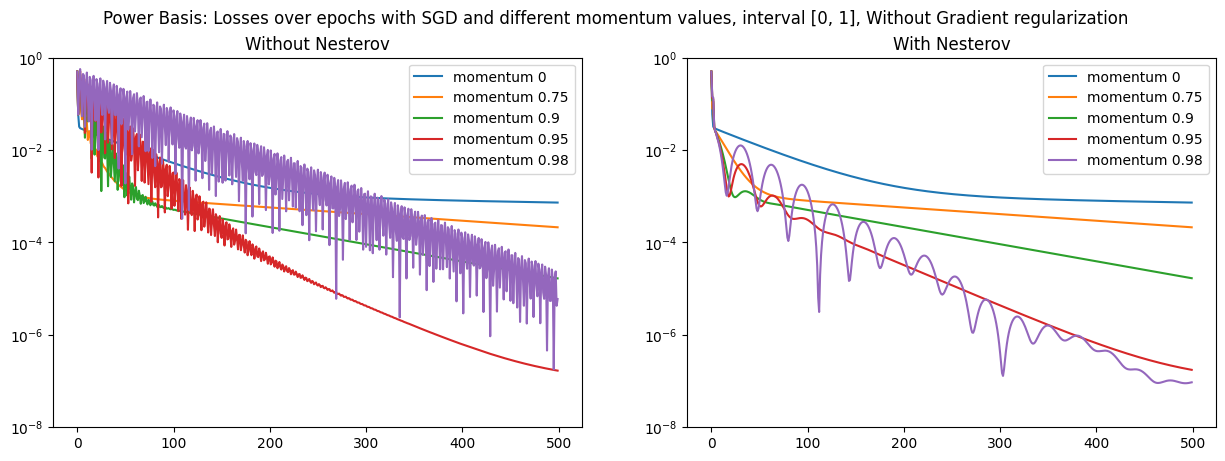

In [116]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(momentums)*3)
fig.suptitle("Power Basis: Losses over epochs with SGD and different momentum values, interval [0, 1], Without Gradient regularization")

for i, m in enumerate(momentums):
    ax1.semilogy(losses_without[i], label="momentum %.2g" % m)
    ax2.semilogy(losses_without_nesterov[i], label="momentum %.2g" % m)

for ax in (ax1, ax2):
    ax.set_ylim([1e-8, 1e-0])
    ax.legend(loc="best")

ax1.set_title("Without Nesterov")
ax2.set_title("With Nesterov")

In [117]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'chebyshev', 'mode': 'sgd-nesterov-momentum'}

pool = mp.Pool(mp.cpu_count())
results_with_nesterov = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [118]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'mode': 'sgd-nesterov-momentum'}

pool = mp.Pool(mp.cpu_count())
results_without_nesterov = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [119]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'chebyshev', 'mode': 'sgd-momentum'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [120]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'mode': 'sgd-momentum'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [121]:
losses_with = [0.0] * len(results_with)
losses_with_nesterov = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)
losses_without_nesterov = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_with_nesterov[i] = results_with_nesterov[i][1]
    losses_without_nesterov[i] = results_without_nesterov[i][1]

Text(0.5, 1.0, 'With Nesterov')

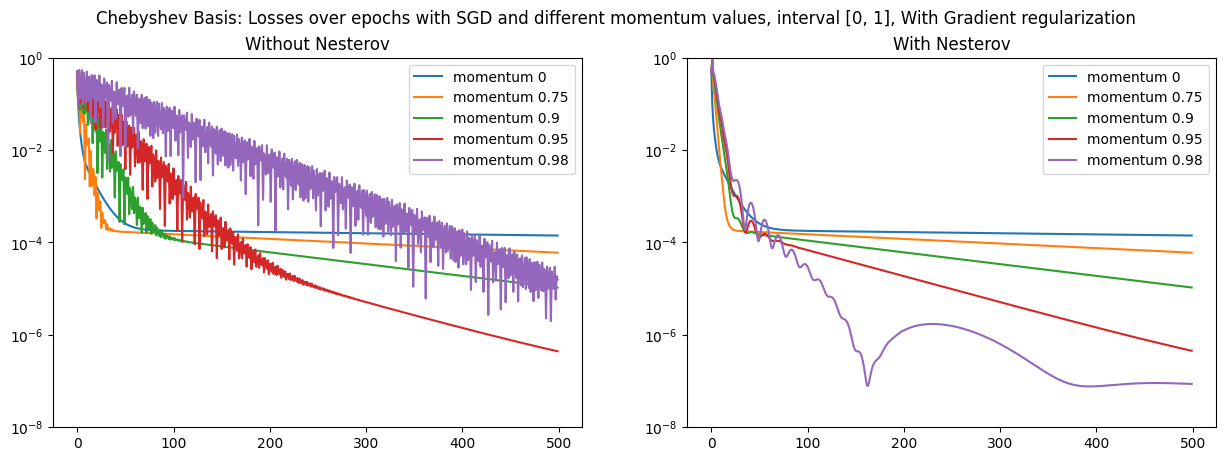

In [124]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(momentums)*3)
fig.suptitle("Chebyshev Basis: Losses over epochs with SGD and different momentum values, interval [0, 1], With Gradient regularization")

for i, m in enumerate(momentums):
    ax1.semilogy(losses_with[i], label="momentum %.2g" % m)
    ax2.semilogy(losses_with_nesterov[i], label="momentum %.2g" % m)

for ax in (ax1, ax2):
    ax.set_ylim([1e-8, 1e-0])
    ax.legend(loc="best")

ax1.set_title("Without Nesterov")
ax2.set_title("With Nesterov")

Text(0.5, 1.0, 'With Nesterov')

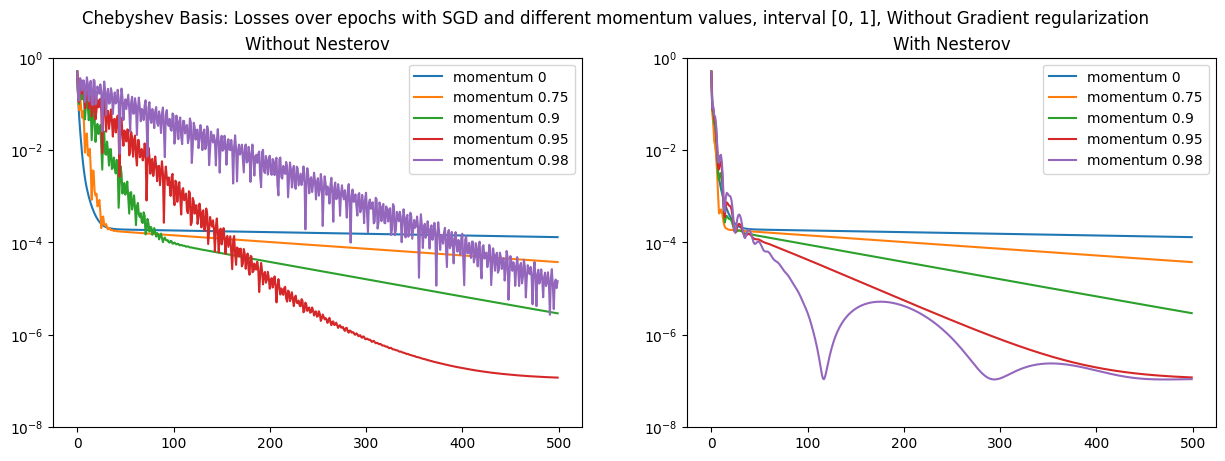

In [125]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(momentums)*3)
fig.suptitle("Chebyshev Basis: Losses over epochs with SGD and different momentum values, interval [0, 1], Without Gradient regularization")

for i, m in enumerate(momentums):
    ax1.semilogy(losses_without[i], label="momentum %.2g" % m)
    ax2.semilogy(losses_without_nesterov[i], label="momentum %.2g" % m)

for ax in (ax1, ax2):
    ax.set_ylim([1e-8, 1e-0])
    ax.legend(loc="best")

ax1.set_title("Without Nesterov")
ax2.set_title("With Nesterov")

In [126]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'shifted_chebyshev', 'mode': 'sgd-nesterov-momentum'}

pool = mp.Pool(mp.cpu_count())
results_with_nesterov = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [127]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'mode': 'sgd-nesterov-momentum'}

pool = mp.Pool(mp.cpu_count())
results_without_nesterov = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [128]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'shifted_chebyshev', 'mode': 'sgd-momentum'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [129]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'shifted_chebyshev', 'mode': 'sgd-momentum'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(momentums, repeat(kwargs)))

In [135]:
losses_with = [0.0] * len(results_with)
losses_with_nesterov = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)
losses_without_nesterov = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]
    losses_with_nesterov[i] = results_with_nesterov[i][1]
    losses_without_nesterov[i] = results_without_nesterov[i][1]

Text(0.5, 1.0, 'With Nesterov')

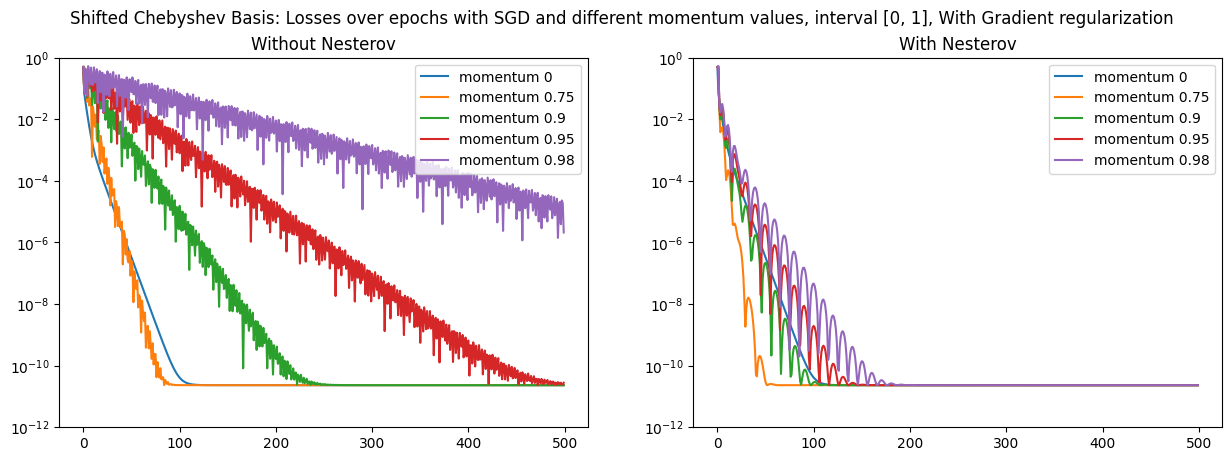

In [136]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Losses over epochs with SGD and different momentum values, interval [0, 1], With Gradient regularization")

for i, m in enumerate(momentums):
    ax1.semilogy(losses_with[i], label="momentum %.2g" % m)
    ax2.semilogy(losses_with_nesterov[i], label="momentum %.2g" % m)

for ax in (ax1, ax2):
    ax.set_ylim([1e-12, 1e-0])
    ax.legend(loc="best")

ax1.set_title("Without Nesterov")
ax2.set_title("With Nesterov")

Text(0.5, 1.0, 'With Nesterov')

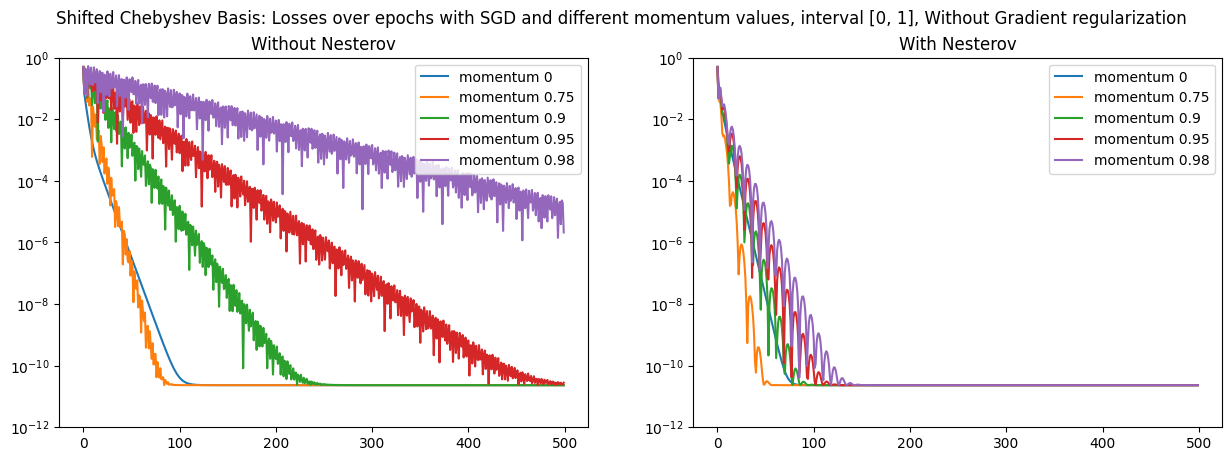

In [137]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Losses over epochs with SGD and different momentum values, interval [0, 1], Without Gradient regularization")

for i, m in enumerate(momentums):
    ax1.semilogy(losses_without[i], label="momentum %.2g" % m)
    ax2.semilogy(losses_without_nesterov[i], label="momentum %.2g" % m)

for ax in (ax1, ax2):
    ax.set_ylim([1e-12, 1e-0])
    ax.legend(loc="best")

ax1.set_title("Without Nesterov")
ax2.set_title("With Nesterov")

### Interpretation
- For Power and Chebyshev Basis, a momentum of 0.95 shows the best results. **For Shifted Chebyshev basis, 0.75 works best.**

## Investigating AMSGrad

In [167]:
epochs = 500
degree = 5
lrs = [10.0**e for e in np.arange(-2.0, 1.25, 0.25)]

In [168]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'power', 'optimizer': 'amsgrad' ,'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [169]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'optimizer': 'amsgrad' ,'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [171]:
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]

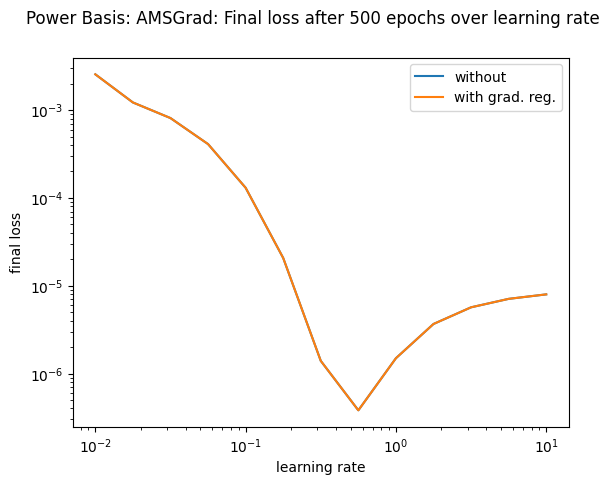

In [172]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Power Basis: AMSGrad: Final loss after %d epochs over learning rate" % epochs)

ax.loglog(lrs, [row[-1] for row in losses_without], label="without")
ax.loglog(lrs, [row[-1] for row in losses_with], label="with grad. reg.")
ax.set_xlabel("learning rate")
ax.set_ylabel("final loss")
ax.legend(loc="best")

In [173]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'chebyshev', 'optimizer': 'amsgrad' ,'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [174]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'optimizer': 'amsgrad' ,'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [175]:
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]

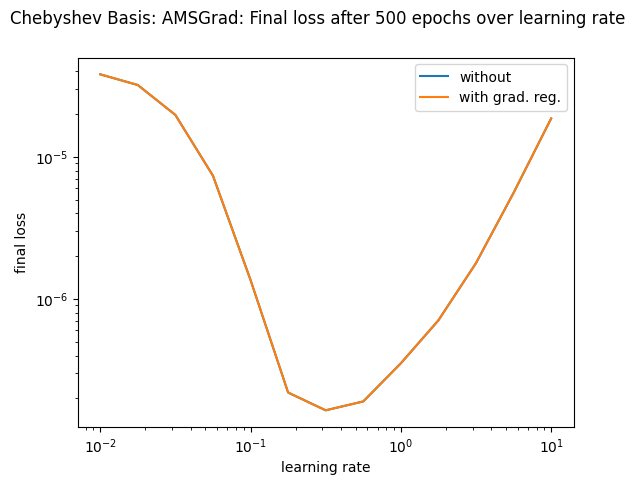

In [176]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Chebyshev Basis: AMSGrad: Final loss after %d epochs over learning rate" % epochs)

ax.loglog(lrs, [row[-1] for row in losses_without], label="without")
ax.loglog(lrs, [row[-1] for row in losses_with], label="with grad. reg.")
ax.set_xlabel("learning rate")
ax.set_ylabel("final loss")
ax.legend(loc="best")

In [177]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'shifted_chebyshev', 'optimizer': 'amsgrad' ,'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [178]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'amsgrad' ,'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [179]:
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]

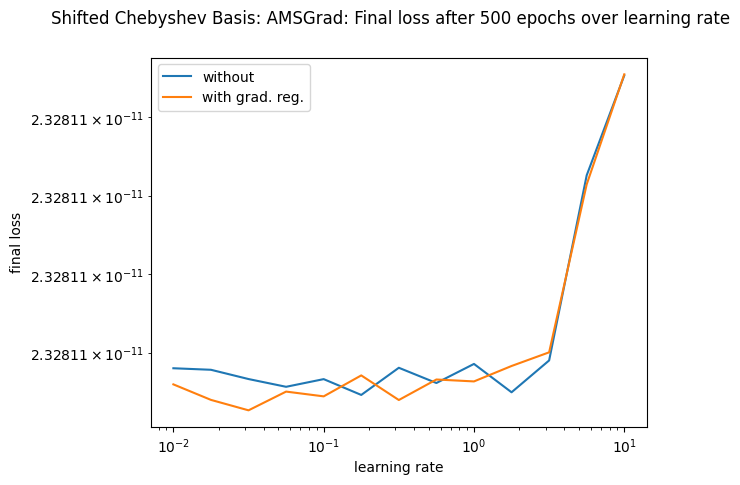

In [180]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: AMSGrad: Final loss after %d epochs over learning rate" % epochs)

ax.loglog(lrs, [row[-1] for row in losses_without], label="without")
ax.loglog(lrs, [row[-1] for row in losses_with], label="with grad. reg.")
ax.set_xlabel("learning rate")
ax.set_ylabel("final loss")
ax.legend(loc="best")

### Interpretation
- AMSGrad is quite robust about choosing too large learning rate
- For Power Basis a learning rate of 0.5 is a very good choice
- For Chebyshev Basis, a learning rate of 0.3 works best
- For Shifted Chebyshev Basis, a learning rate of 1 shows best results without grad reg, and 0.03 with
- Regularization does not matter for Power and Chebyshev Basis. There are differences for Shifted Chebyshev basis, but the effects are at very small magnitudes.

In [181]:
epochs = 500
degree = 5
beta_1s = [b for b in np.arange(0.6, 1.001, 0.1)]

In [182]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'power', 'optimizer': 'amsgrad' ,'mode': 'amsgrad-beta1'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(beta_1s, repeat(kwargs)))

In [183]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'optimizer': 'amsgrad' ,'mode': 'amsgrad-beta1'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(beta_1s, repeat(kwargs)))

In [184]:
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]

Text(0.5, 1.0, 'With regularization')

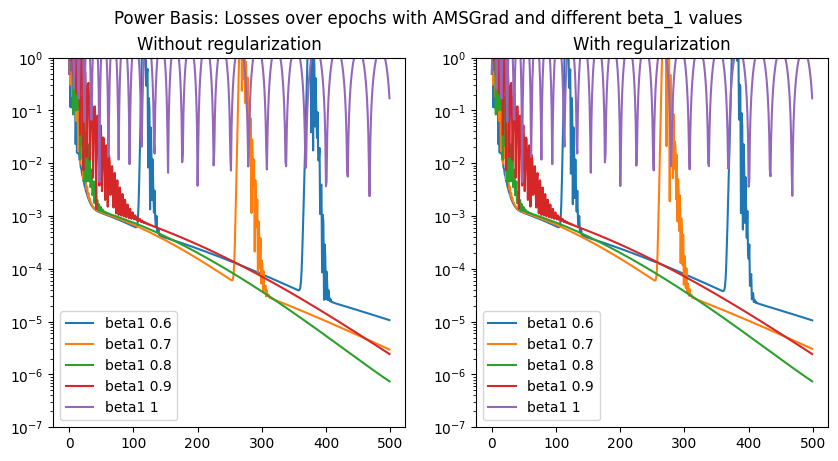

In [187]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Power Basis: Losses over epochs with AMSGrad and different beta_1 values")

for i, b1 in enumerate(beta_1s):
    ax1.semilogy(losses_without[i], label="beta1 %.2g" % b1)
    ax2.semilogy(losses_with[i], label="beta1 %.2g" % b1)

for ax in (ax1, ax2):
    ax.set_ylim([1e-7, 1e-0])
    ax.legend(loc="best")
    
ax1.set_title("Without regularization")
ax2.set_title("With regularization")

In [188]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'chebyshev', 'optimizer': 'amsgrad' ,'mode': 'amsgrad-beta1'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(beta_1s, repeat(kwargs)))

In [189]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'optimizer': 'amsgrad' ,'mode': 'amsgrad-beta1'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(beta_1s, repeat(kwargs)))

In [190]:
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]

Text(0.5, 1.0, 'With regularization')

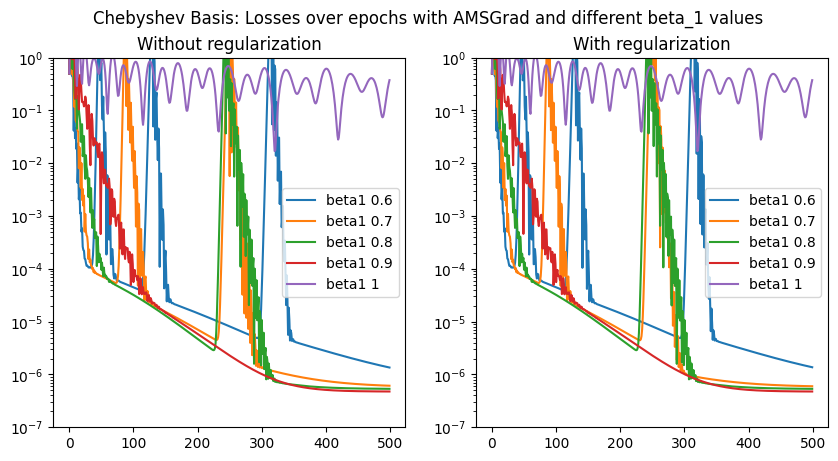

In [192]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Chebyshev Basis: Losses over epochs with AMSGrad and different beta_1 values")

for i, b1 in enumerate(beta_1s):
    ax1.semilogy(losses_without[i], label="beta1 %.2g" % b1)
    ax2.semilogy(losses_with[i], label="beta1 %.2g" % b1)

for ax in (ax1, ax2):
    ax.set_ylim([1e-7, 1e-0])
    ax.legend(loc="best")

ax1.set_title("Without regularization")
ax2.set_title("With regularization")

In [193]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'shifted_chebyshev', 'optimizer': 'amsgrad' ,'mode': 'amsgrad-beta1'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(beta_1s, repeat(kwargs)))

In [194]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'amsgrad' ,'mode': 'amsgrad-beta1'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(beta_1s, repeat(kwargs)))

In [195]:
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] = results_without[i][1]

Text(0.5, 1.0, 'With regularization')

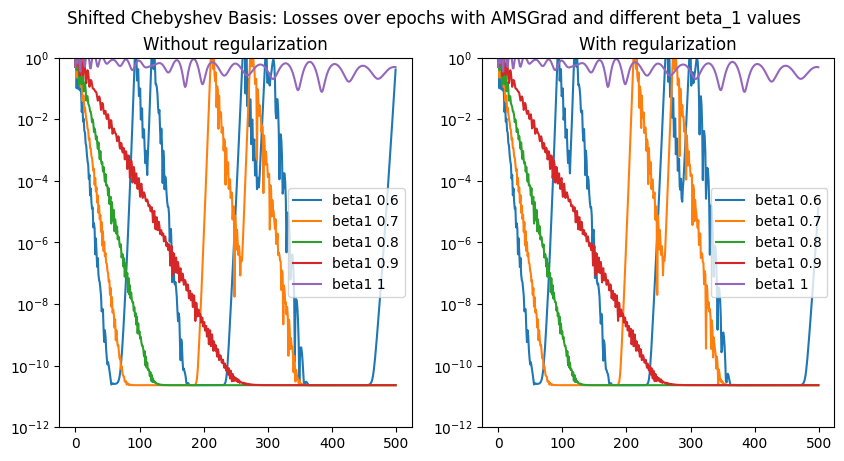

In [198]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Shifted Chebyshev Basis: Losses over epochs with AMSGrad and different beta_1 values")

for i, b1 in enumerate(beta_1s):
    ax1.semilogy(losses_without[i], label="beta1 %.2g" % b1)
    ax2.semilogy(losses_with[i], label="beta1 %.2g" % b1)

for ax in (ax1, ax2):
    ax.set_ylim([1e-12, 1e-0])
    ax.legend(loc="best")

ax1.set_title("Without regularization")
ax2.set_title("With regularization")

### Interpretation
- Again, regularization does not matter.
- Choosing beta1 too large or too small causes instabilities.
- The default of 0.9 is quite good. Choosing 0.8 gives better performance for Shifted Chebyshev and Power Basis, while it becomes unstable for Chebyshev Basis.

## Investigating Ftrl for Shifted Chebyshev Basis

As the optimizer shows promising results with shifted Chebyshev basis, it shall be investigated further here.

### Learning Rate

In [8]:
epochs = 500
degree = 5
shift_polynomial_centers = 'off'
lr = 1
lrs = [10.0**e for e in np.arange(-2.0, 1.25, 0.25)]

In [13]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': True,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_with = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [14]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'learning_rate'}

pool = mp.Pool(mp.cpu_count())
results_without = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [17]:
losses_with = [0.0] * len(results_with)
losses_without = [0.0] * len(results_with)

for i in range(len(results_with)):
    losses_with[i] = results_with[i][1]
    losses_without[i] =  results_without[i][1]

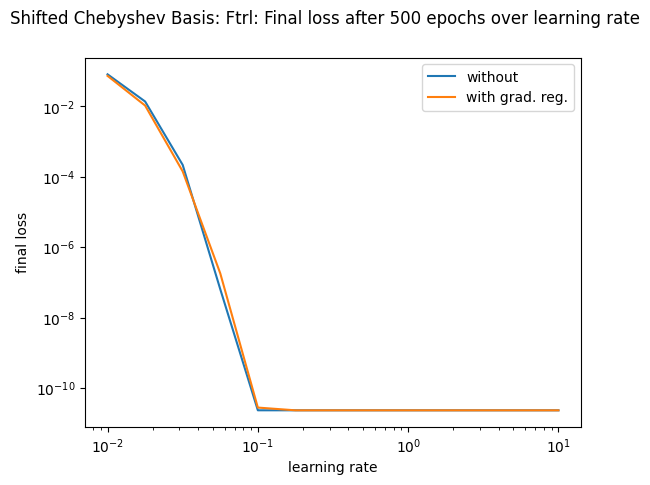

In [18]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Ftrl: Final loss after %d epochs over learning rate" % epochs)

ax.loglog(lrs, [row[-1] for row in losses_without], label="without")
ax.loglog(lrs, [row[-1] for row in losses_with], label="with grad. reg.")
ax.set_xlabel("learning rate")
ax.set_ylabel("final loss")
ax.legend(loc="best")

### Interpretation
A learning rate > 0.2 shows the best result with gradient regularization and without.
Effects of gradient regularization are very mild.

### Learning Rate Power
 Float value. Controls how the learning rate decreases during training. Zero is a fixed learning rate.

In [39]:
lr = 1
lr_power = np.linspace(-2, 0, 10)

In [40]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'ftrl-lr-power'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(lr_power, repeat(kwargs)))

In [41]:
losses = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]

Text(0, 0.5, 'final loss')

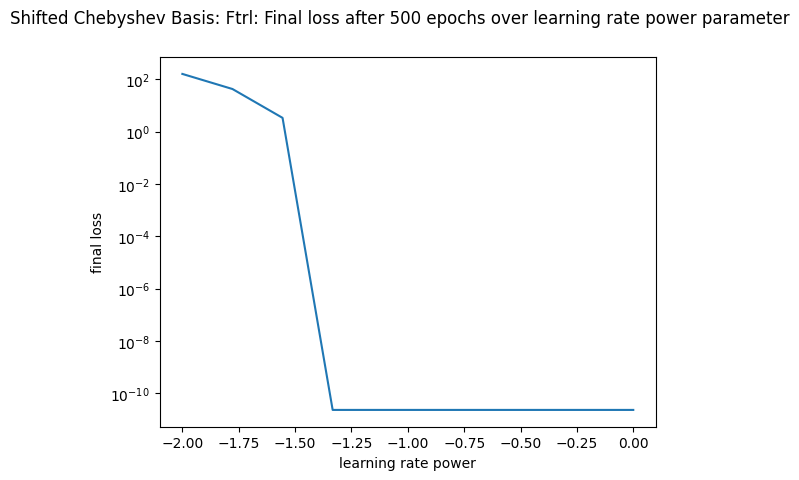

In [43]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Ftrl: Final loss after %d epochs over learning rate power parameter" % epochs)

ax.semilogy(lr_power, [row[-1] for row in losses])
ax.set_xlabel("learning rate power")
ax.set_ylabel("final loss")

### Interpretation

Values > -1.25 lead to the same promising results. The default of -0.5 therefore is ok.

### Initial accumulator value
The starting value for accumulators. Only zero or positive values are allowed.

In [57]:
epochs = 500
degree = 5
shift_polynomial_centers = 'off'
lr = 1
params = np.arange(0, 10, 0.25)

In [58]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'ftrl-initial_accumulator_value'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

losses = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]

Text(0, 0.5, 'final loss')

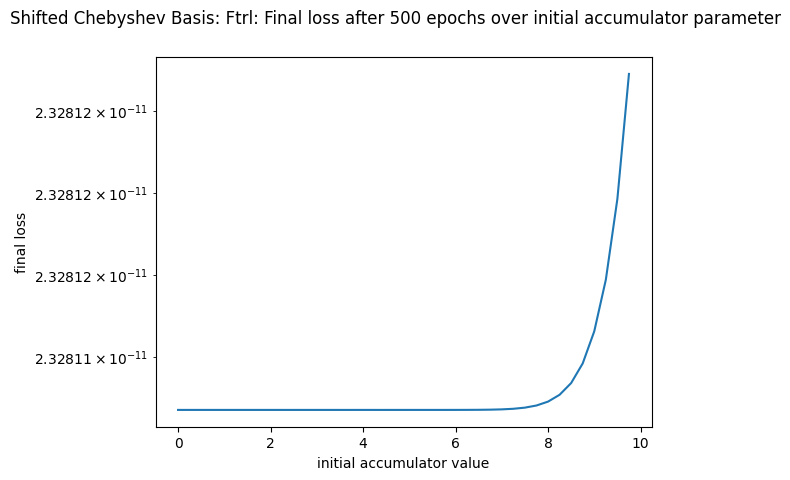

In [59]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Ftrl: Final loss after %d epochs over initial accumulator parameter" % epochs)

ax.semilogy(params, [row[-1] for row in losses])
ax.set_xlabel("initial accumulator value")
ax.set_ylabel("final loss")

### Interpretation

The final loss rises with rising accumulator value. The default of 0.1 therefore seems ok.

### L1 regularization strength
 A float value, must be greater than or equal to zero.

In [60]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'ftrl-l1_regularization_strength'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

losses = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]

Text(0, 0.5, 'final loss')

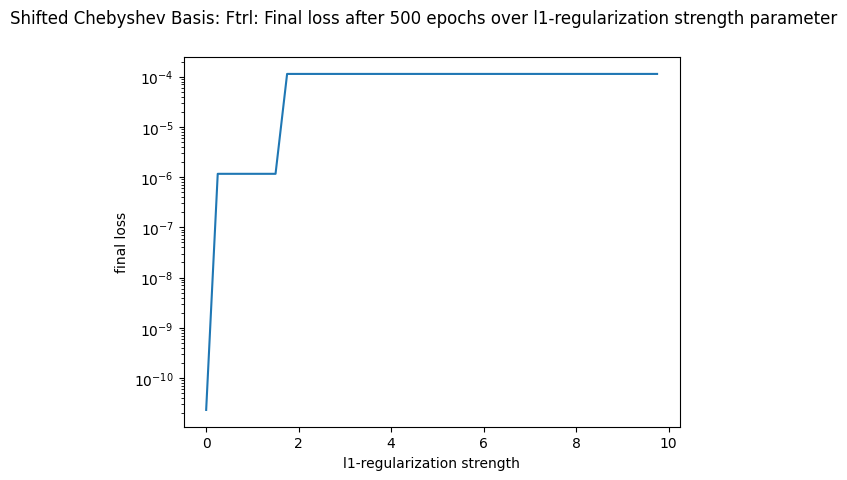

In [61]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Ftrl: Final loss after %d epochs over l1-regularization strength parameter" % epochs)

ax.semilogy(params, [row[-1] for row in losses])
ax.set_xlabel("l1-regularization strength")
ax.set_ylabel("final loss")

### Interpretation
The final loss rises with rising l1 regularization parameter value. The default of 0.0 therefore seems ok.

### L2 regularization strength
 A float value, must be greater than or equal to zero.

In [62]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'ftrl-l2_regularization_strength'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

losses = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]

Text(0, 0.5, 'final loss')

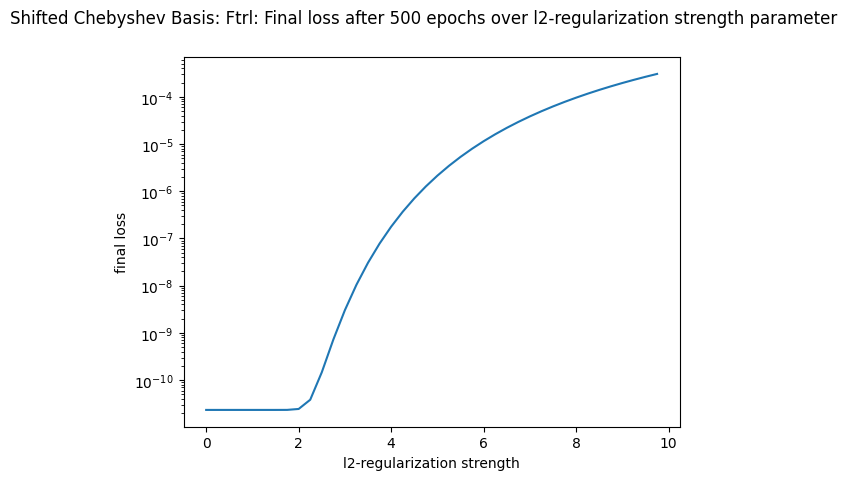

In [64]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Ftrl: Final loss after %d epochs over l2-regularization strength parameter" % epochs)

ax.semilogy(params, [row[-1] for row in losses])
ax.set_xlabel("l2-regularization strength")
ax.set_ylabel("final loss")

### Interpretation
The final loss rises with rising l1 regularization parameter value. The default of 0.0 therefore seems ok.

### L2 shrinkage regularization strength
A float value, must be greater than or equal to zero.

In [65]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'ftrl-l2_shrinkage_regularization_strength'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

losses = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]

Text(0, 0.5, 'final loss')

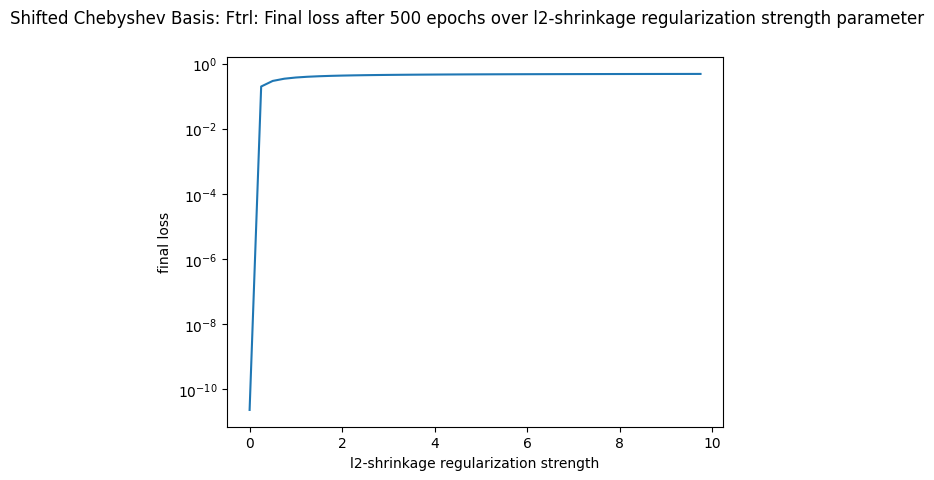

In [66]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Ftrl: Final loss after %d epochs over l2-shrinkage regularization strength parameter" % epochs)

ax.semilogy(params, [row[-1] for row in losses])
ax.set_xlabel("l2-shrinkage regularization strength")
ax.set_ylabel("final loss")

### Interpretation
Default of 0.0 is the best choice.

### Beta value
A float value, representing the beta value from the paper.

In [67]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'ftrl-beta'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

losses = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]

Text(0, 0.5, 'final loss')

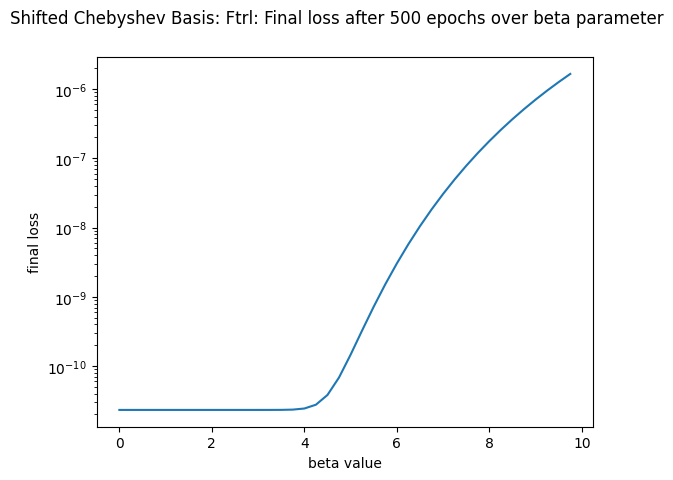

In [68]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Ftrl: Final loss after %d epochs over beta parameter" % epochs)

ax.semilogy(params, [row[-1] for row in losses])
ax.set_xlabel("beta value")
ax.set_ylabel("final loss")

### Interpretation
Default of 0.0 is best choice.

### Weight decay
Float value.

In [69]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'ftrl-weight_decay'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

losses = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]

Text(0, 0.5, 'final loss')

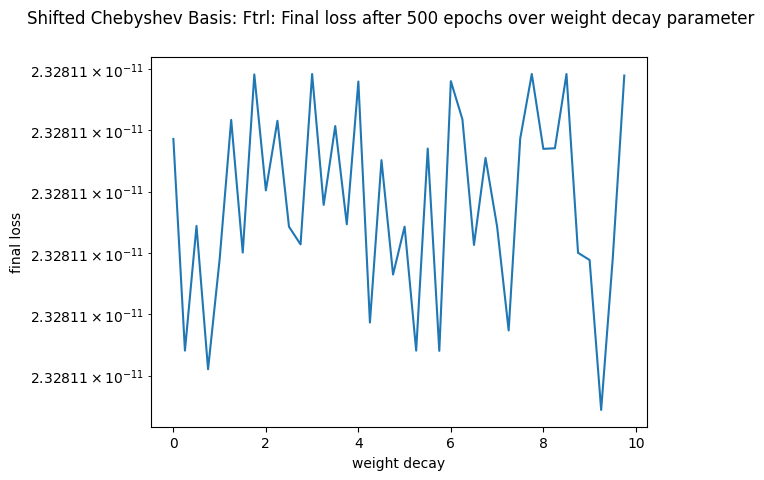

In [70]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Ftrl: Final loss after %d epochs over weight decay parameter" % epochs)

ax.semilogy(params, [row[-1] for row in losses])
ax.set_xlabel("weight decay")
ax.set_ylabel("final loss")

### Interpretation
The fluctuations we see are in the realm of numerical noise. The default (no weight decay) seems to be ok.

### Ema momentum overwrite frequency with default ema momentum (0.99)
 Int or None, defaults to None.
 Only used if use_ema=True. Every ema_overwrite_frequency steps of iterations, we overwrite the model variable by its moving average.
 If None, the optimizer does not overwrite model variables (and effectively no ema momentum is applied to variables).

In [72]:
params = [n*25 for n in range(1, 21)]
params.insert(0, 1)

In [73]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'ftrl-ema_overwrite_frequency'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

losses = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]

Text(0, 0.5, 'final loss')

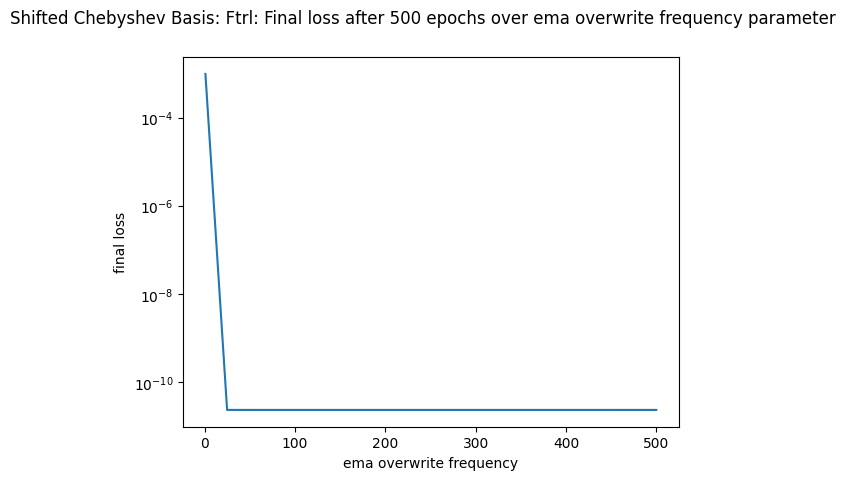

In [74]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Ftrl: Final loss after %d epochs over ema overwrite frequency parameter" % epochs)

ax.semilogy(params, [row[-1] for row in losses])
ax.set_xlabel("ema overwrite frequency")
ax.set_ylabel("final loss")

### Interpretation
A value >= 25 seems suitable.

### Ema momentum with overwrite frequency 100
 Float, defaults to 0.99. This is the momentum to use when computing the EMA of the model's weights: new_average = ema_momentum * old_average + (1 - ema_momentum) * current_variable_value

In [80]:
params = np.arange(0, 1.1, 0.1)

In [81]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'ftrl-ema_momentum'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(params, repeat(kwargs)))

losses = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]

Text(0, 0.5, 'final loss')

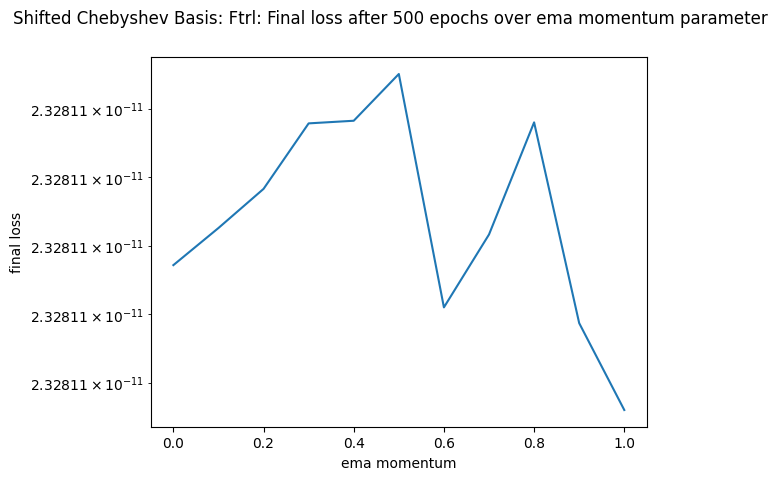

In [82]:
fig, ax = plt.subplots(1, 1)
#fig.set_figwidth(len(momentums)*3)
fig.suptitle("Shifted Chebyshev Basis: Ftrl: Final loss after %d epochs over ema momentum parameter" % epochs)

ax.semilogy(params, [row[-1] for row in losses])
ax.set_xlabel("ema momentum")
ax.set_ylabel("final loss")

### Interpretation

An ema momentum close to 1 seems to be the best option, although the range of fluctuations we see is again very small.
Also here, the default of 0.99 seems to be the best option.

Ema momentum vs. no momentum

In [105]:
epochs = 500
degree = 5
shift_polynomial_centers = 'off'
lr = 1

In [106]:
opt_with = keras.optimizers.Ftrl(learning_rate=lr, use_ema=True, ema_overwrite_frequency=100)
opt_without = keras.optimizers.Ftrl(learning_rate=lr)

spline_with = model.Spline(polydegree=degree, polynum=1, ck=0, shift_polynomial_centers=shift_polynomial_centers, basis='shifted_chebyshev', continuity=False)
spline_with.fit(xs, ys, optimizer=opt_with, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, factor_curvature=0, gradient_regularization=False, overlap_segments=0, initialize_l2fit=False, uniform_split=True)

spline_without = model.Spline(polydegree=degree, polynum=1, ck=0, shift_polynomial_centers=shift_polynomial_centers, basis='shifted_chebyshev', continuity=False)
spline_without.fit(xs, ys, optimizer=opt_without, n_epochs=epochs, factor_approximation_quality=1, factor_ck_pressure=0, factor_curvature=0, gradient_regularization=False, overlap_segments=0, initialize_l2fit=False, uniform_split=True)

<tf.Tensor: shape=(), dtype=float64, numpy=2.32811335247858e-11>

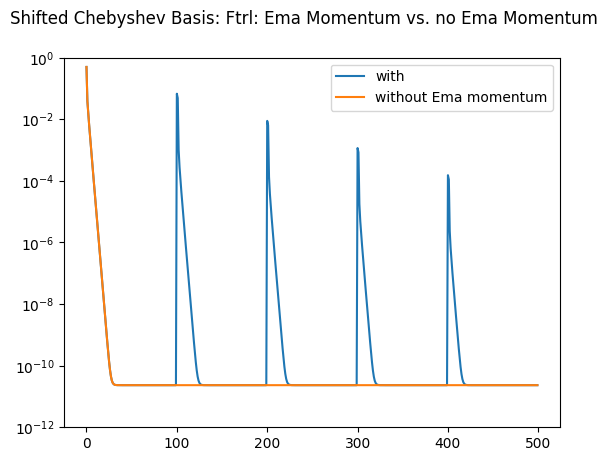

In [108]:
fig, ax = plt.subplots(1, 1)
fig.suptitle(f'Shifted Chebyshev Basis: Ftrl: Ema Momentum vs. no Ema Momentum')

ax.semilogy(spline_with.total_loss_values, label="with")
ax.semilogy(spline_without.total_loss_values, label="without Ema momentum")
ax.set_ylim([1e-12, 1e-0])
ax.legend(loc="best")

### Interpretation

The loss curve with Ema momentum is showing instabilities at those epochs where the momentum is applied (every 100th epoch).
Conclusion for now: Do not use Ema momentum.

## Stability under noise for SGD with Nesterov momentum

The following 4 functions were taken from Stefan Huber's "polynomial.py", <stefan.huber@fh-salzburg.ac.at>.

In [14]:
def evaluate(coeffs, x):
    """Return evaluation of a polynomial with given coefficients at location x.
    If coeffs is [a, b, c, …] then return a + b·x + c·x² + …"""

    tot = 0.0
    for c in coeffs[::-1]:
        tot = x*tot + c
    return tot

In [15]:
def evaluate_vect(coeffs, xs):
    """Like a vectorized version of evaluate() for lists of values for x."""

    # We cannot use numpy.vectorize here because it would stop gradient
    # computation.
    # Note that tf.vectorize_map() is slow because len(xs) is too small
    # to pay off, I guess. Using map_fn() is similarily fast than using
    # plain list comprehension.
    return [evaluate(coeffs, x) for x in xs]

In [16]:
def l2_sq_error(coeffs, xs, ys):
    """Returns the square of the L2-error between polynomial of given coeffs
    and the samples given in ys at loctions xs. That is, if the polynomial
    given by coeffs is p then return the sum of the squares of p(x)-y where x,
    y iterates over xs, ys."""

    fs = evaluate_vect(coeffs, xs)
    ds = tf.subtract(fs, ys)
    return tf.reduce_sum(tf.multiply(ds, ds))

In [17]:
def l2_sq_loss(coeffs, xs, ys):
    """The squared L2 loss of given polynomial on given data points (xs, ys).␣
    ,→Loss is
    invariant on the length of xs."""
    return l2_sq_error(coeffs, xs, ys) / len(xs)

In [21]:
epochs = 500
degree = 5
shift_polynomial_centers = 'off'
lr = 1.3

In [22]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'optimizer': 'SGD' ,'mode': 'data_y'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [34]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'optimizer': 'SGD' ,'mode': 'data_y'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [40]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'SGD' ,'mode': 'data_y'}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [42]:
splines = [0.0] * len(results)
splines_chebyshev = [0.0] * len(results)
splines_shifted_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    splines[i] = model.get_spline_from_coeffs(results[i][-1], xs, ysgauss[i], basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results[i][1])
    splines_chebyshev[i] = model.get_spline_from_coeffs(results_chebyshev[i][-1], xs, ysgauss[i], basis='chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_chebyshev[i][1])
    splines_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_shifted_chebyshev[i][-1], xs, ysgauss[i], basis='shifted_chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_shifted_chebyshev[i][1])

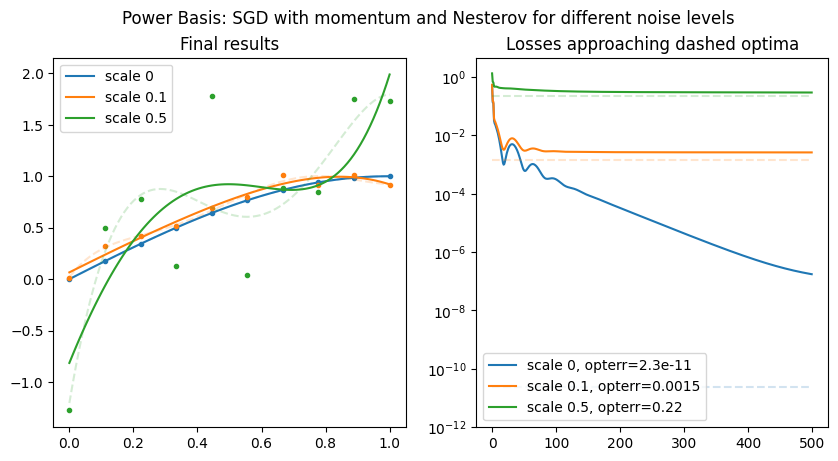

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Power Basis: SGD with momentum and Nesterov for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines)):
    col = next(colcycle)["color"]
    ps = splines[i].evaluate_spline_at_x(xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]
    
    optcoeff = np.polyfit(xs, ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in xss]
    optloss = l2_sq_loss(optcoeff, xs, ysg)
        
    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2) 
    
    ax2.semilogy(splines[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)
    
ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-12,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

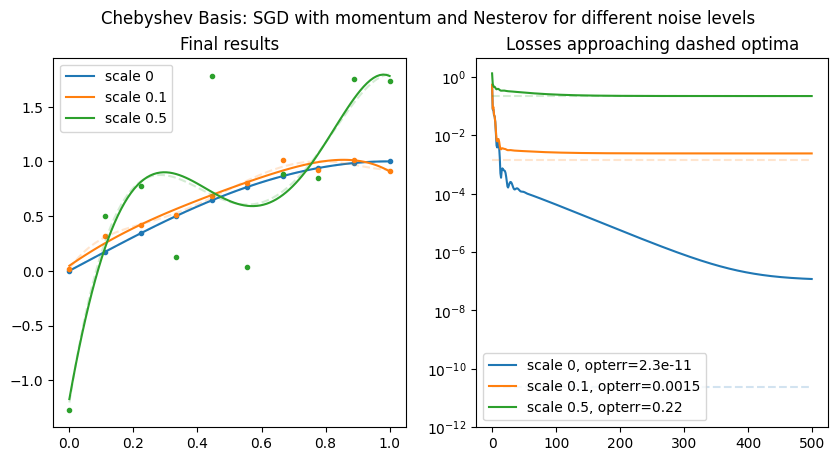

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Chebyshev Basis: SGD with momentum and Nesterov for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines_chebyshev)):
    col = next(colcycle)["color"]
    ps = splines_chebyshev[i].evaluate_spline_at_x(xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]

    optcoeff = np.polyfit(xs, ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in xss]
    optloss = l2_sq_loss(optcoeff, xs, ysg)

    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2)

    ax2.semilogy(splines_chebyshev[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)

ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-12,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

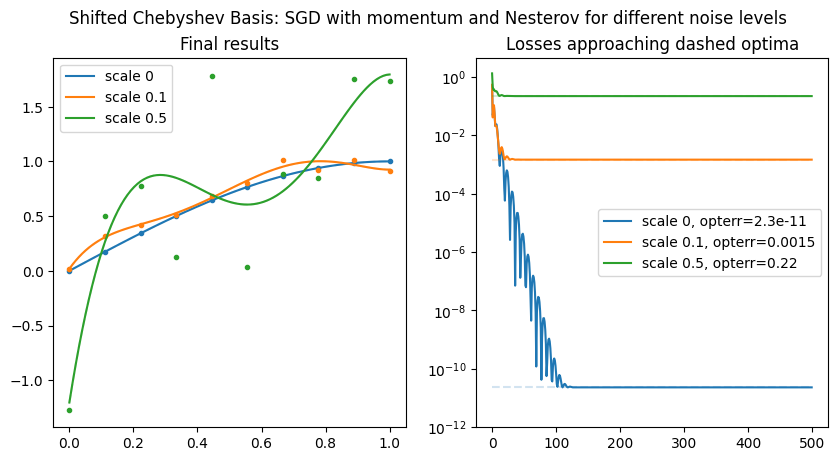

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Shifted Chebyshev Basis: SGD with momentum and Nesterov for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines_shifted_chebyshev)):
    col = next(colcycle)["color"]
    ps = splines_shifted_chebyshev[i].evaluate_spline_at_x(xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]

    optcoeff = np.polyfit(xs, ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in xss]
    optloss = l2_sq_loss(optcoeff, xs, ysg)

    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2)

    ax2.semilogy(splines_shifted_chebyshev[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)

ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-12,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

### Interpretation
Generally:
- Without noise the optimal error is basically zero

Power Basis:
- With noise SGD is approaching the optimum, but does not reach it. The gap is only significant for larger noise levels, but in practice we would not try to regress such a point cloud with such a polynomial. In this experiment we only investigated whether it would converge at all.
- Furthermore, for scale=0.5, the optimum is already showing **significant oscillation**. Hence, in the application domain of cam design, this is actually not favorable and hence we do not care so much. If we add a measurement of oscillation to the loss then the optimum would actually be closer to our iterative solutions.

Chehybshev Basis:
Slightly better performance than Power Basis with noise

Shifted Chebyshev Basis:
Outstanding performance. Reaches optimum with all noise levels.

## Stability under noise for ADAM

In [60]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'optimizer': 'AMSGrad' ,'mode': 'data_y'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [61]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'optimizer': 'AMSGrad' ,'mode': 'data_y'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [62]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'AMSGrad' ,'mode': 'data_y'}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [63]:
splines = [0.0] * len(results)
splines_chebyshev = [0.0] * len(results)
splines_shifted_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    splines[i] = model.get_spline_from_coeffs(results[i][-1], xs, ysgauss[i], basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results[i][1])
    splines_chebyshev[i] = model.get_spline_from_coeffs(results_chebyshev[i][-1], xs, ysgauss[i], basis='chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_chebyshev[i][1])
    splines_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_shifted_chebyshev[i][-1], xs, ysgauss[i], basis='shifted_chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_shifted_chebyshev[i][1])

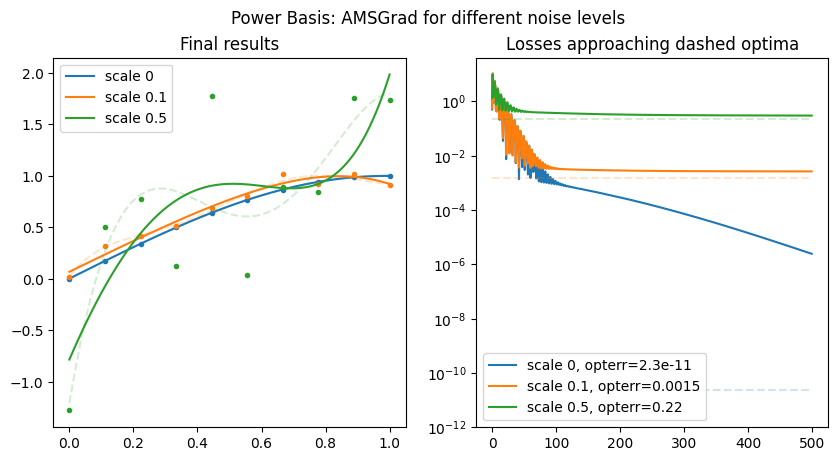

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Power Basis: AMSGrad for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines)):
    col = next(colcycle)["color"]
    ps = splines[i].evaluate_spline_at_x(xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]

    optcoeff = np.polyfit(xs, ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in xss]
    optloss = l2_sq_loss(optcoeff, xs, ysg)

    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2)

    ax2.semilogy(splines[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)

ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-12,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

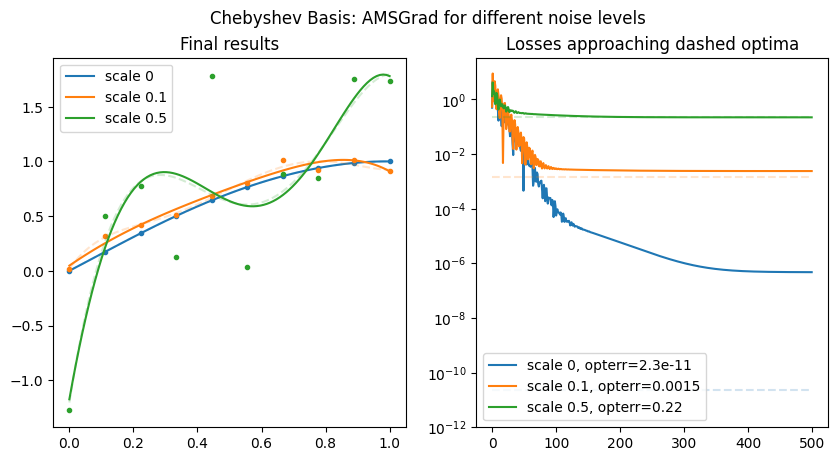

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Chebyshev Basis: AMSGrad for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines_chebyshev)):
    col = next(colcycle)["color"]
    ps = splines_chebyshev[i].evaluate_spline_at_x(xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]

    optcoeff = np.polyfit(xs, ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in xss]
    optloss = l2_sq_loss(optcoeff, xs, ysg)

    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2)

    ax2.semilogy(splines_chebyshev[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)

ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-12,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

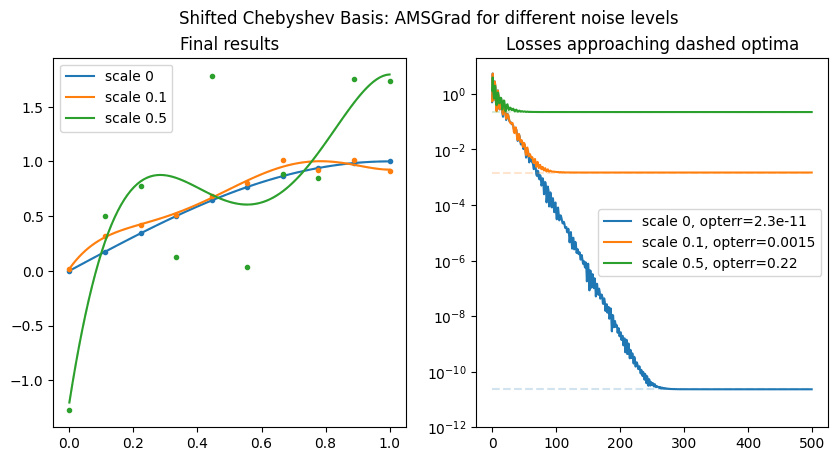

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Shifted Chebyshev Basis: AMSGrad for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines_shifted_chebyshev)):
    col = next(colcycle)["color"]
    ps = splines_shifted_chebyshev[i].evaluate_spline_at_x(xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]

    optcoeff = np.polyfit(xs, ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in xss]
    optloss = l2_sq_loss(optcoeff, xs, ysg)

    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2)

    ax2.semilogy(splines_shifted_chebyshev[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)

ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-12,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

### Interpretation
- The same as for SGD

## Stability under noise for ftrl

In [67]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'optimizer': 'ftrl' ,'mode': 'data_y'}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [68]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'optimizer': 'ftrl' ,'mode': 'data_y'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [69]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'data_y'}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [70]:
splines = [0.0] * len(results)
splines_chebyshev = [0.0] * len(results)
splines_shifted_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    splines[i] = model.get_spline_from_coeffs(results[i][-1], xs, ysgauss[i], basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results[i][1])
    splines_chebyshev[i] = model.get_spline_from_coeffs(results_chebyshev[i][-1], xs, ysgauss[i], basis='chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_chebyshev[i][1])
    splines_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_shifted_chebyshev[i][-1], xs, ysgauss[i], basis='shifted_chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, continuity=False, total_loss_values=results_shifted_chebyshev[i][1])

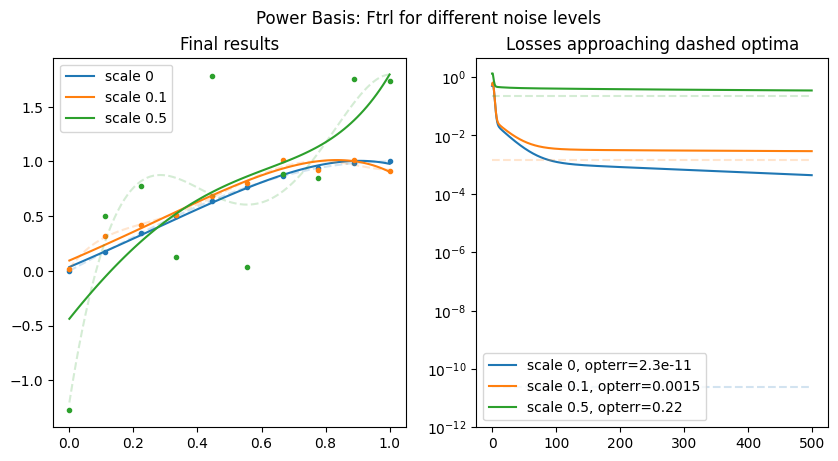

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Power Basis: Ftrl for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines)):
    col = next(colcycle)["color"]
    ps = splines[i].evaluate_spline_at_x(xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]

    optcoeff = np.polyfit(xs, ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in xss]
    optloss = l2_sq_loss(optcoeff, xs, ysg)

    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2)

    ax2.semilogy(splines[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)

ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-12,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

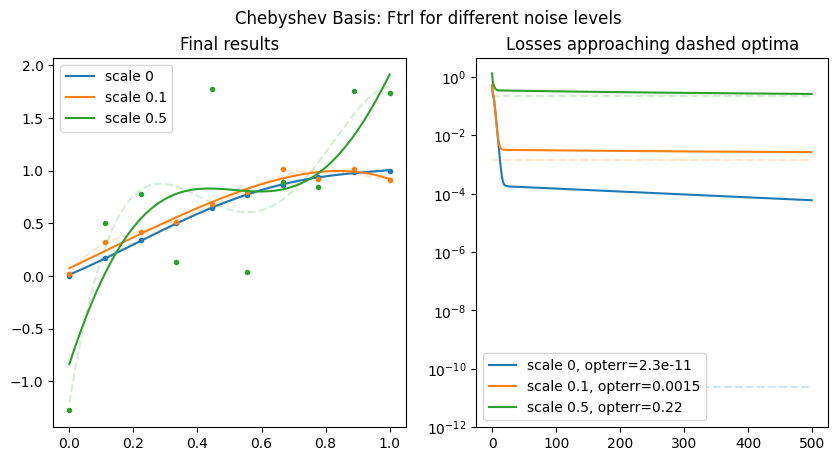

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Chebyshev Basis: Ftrl for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines_chebyshev)):
    col = next(colcycle)["color"]
    ps = splines_chebyshev[i].evaluate_spline_at_x(xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]

    optcoeff = np.polyfit(xs, ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in xss]
    optloss = l2_sq_loss(optcoeff, xs, ysg)

    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2)

    ax2.semilogy(splines_chebyshev[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)

ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-12,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

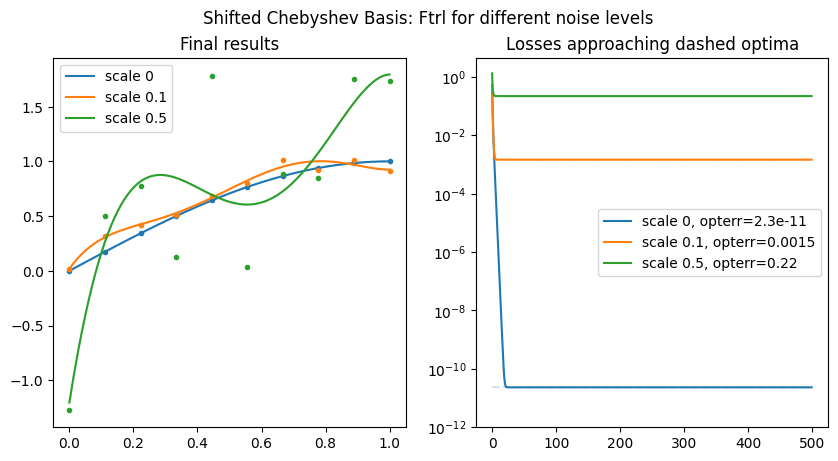

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Shifted Chebyshev Basis: Ftrl for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines_shifted_chebyshev)):
    col = next(colcycle)["color"]
    ps = splines_shifted_chebyshev[i].evaluate_spline_at_x(xss)
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]

    optcoeff = np.polyfit(xs, ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in xss]
    optloss = l2_sq_loss(optcoeff, xs, ysg)

    ax1.plot(xs, ysg, '.', c=col)
    ax1.plot(xss, ps, label="scale %.2g" % scale, c=col)
    ax1.plot(xss, psopt, c=col, linestyle="--", alpha=0.2)

    ax2.semilogy(splines_shifted_chebyshev[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)

ax1.set_title("Final results")
ax2.set_title("Losses approaching dashed optima")
ax2.set_ylim([1e-12,None])

for ax in (ax1, ax2):
    ax.legend(loc="best")

### Interpretation
With Power and Chebyshev Basis, ftrl performs worse than SGD or AMSGrad.
However, with Shifted Chebyshev Basis the performance is simply outstanding, reaching the optimum in all cases after only ~20 epochs.

## Revisit degree with better optimizer

In [87]:
epochs = 1000
degree = 5
shift_polynomial_centers = 'off'
lr = 1.3
degrees = [d for d in range(1, 9)]

In [99]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'optimizer': 'sgd' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_sgd = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [100]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'optimizer': 'amsgrad' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_amsgrad = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [101]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'power', 'optimizer': 'ftrl' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_ftrl = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [102]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'optimizer': 'sgd' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_sgd = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [103]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'optimizer': 'amsgrad' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_amsgrad = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [104]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'chebyshev', 'optimizer': 'ftrl' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_ftrl = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [105]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'sgd' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev_sgd = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [106]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'amsgrad' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev_amsgrad = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [107]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'ftrl' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev_ftrl = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [109]:
losses_sgd = [0.0] * len(results_sgd)
losses_amsgrad = [0.0] * len(results_amsgrad)
losses_ftrl = [0.0] * len(results_ftrl)
losses_chebyshev_sgd = [0.0] * len(results_sgd)
losses_chebyshev_amsgrad = [0.0] * len(results_amsgrad)
losses_chebyshev_ftrl = [0.0] * len(results_ftrl)
losses_shifted_chebyshev_sgd = [0.0] * len(results_sgd)
losses_shifted_chebyshev_amsgrad = [0.0] * len(results_amsgrad)
losses_shifted_chebyshev_ftrl = [0.0] * len(results_ftrl)

for i in range(len(results_sgd)):
    losses_sgd[i] = results_sgd[i][1]
    losses_amsgrad[i] = results_amsgrad[i][1]
    losses_ftrl[i] = results_ftrl[i][1]
    losses_chebyshev_sgd[i] = results_chebyshev_sgd[i][1]
    losses_chebyshev_amsgrad[i] = results_chebyshev_amsgrad[i][1]
    losses_chebyshev_ftrl[i] = results_chebyshev_ftrl[i][1]
    losses_shifted_chebyshev_sgd[i] = results_shifted_chebyshev_sgd[i][1]
    losses_shifted_chebyshev_amsgrad[i] = results_shifted_chebyshev_amsgrad[i][1]
    losses_shifted_chebyshev_ftrl[i] = results_shifted_chebyshev_ftrl[i][1]

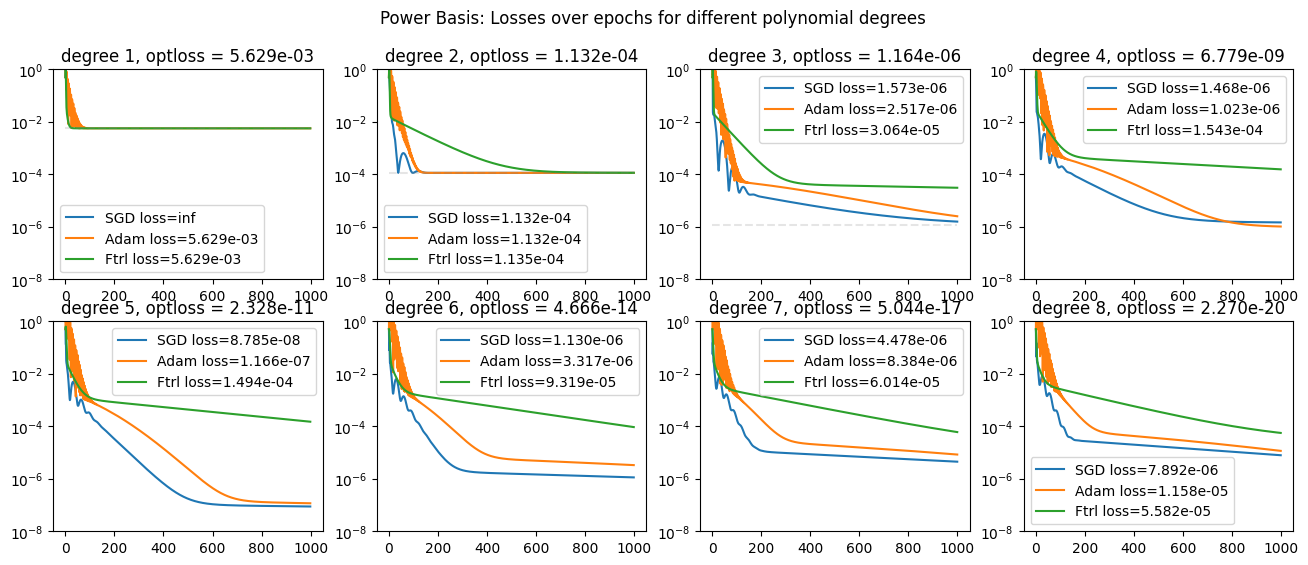

In [114]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Power Basis: Losses over epochs for different polynomial degrees")

for i, d in enumerate(degrees):
    ax = axes[i]
    
    optcoeff = optcoeff = np.polyfit(xs, ys, d)[::-1]
    optloss = l2_sq_loss(optcoeff, xs, ys)
    
    ax.set_title("degree %d, optloss = %.3e" % (d, optloss))
      
    ax.semilogy(losses_sgd[i], label="SGD loss=%.3e" % losses_sgd[i][-1])
    ax.semilogy(losses_amsgrad[i], label="Adam loss=%.3e" % losses_amsgrad[i][-1])
    ax.semilogy(losses_ftrl[i], label="Ftrl loss=%.3e" % losses_ftrl[i][-1])
    
    ax.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color="gray", alpha=0.2)
    
    ax.set_ylim([1e-8, 1e-0])
    ax.legend(loc="best")

C:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


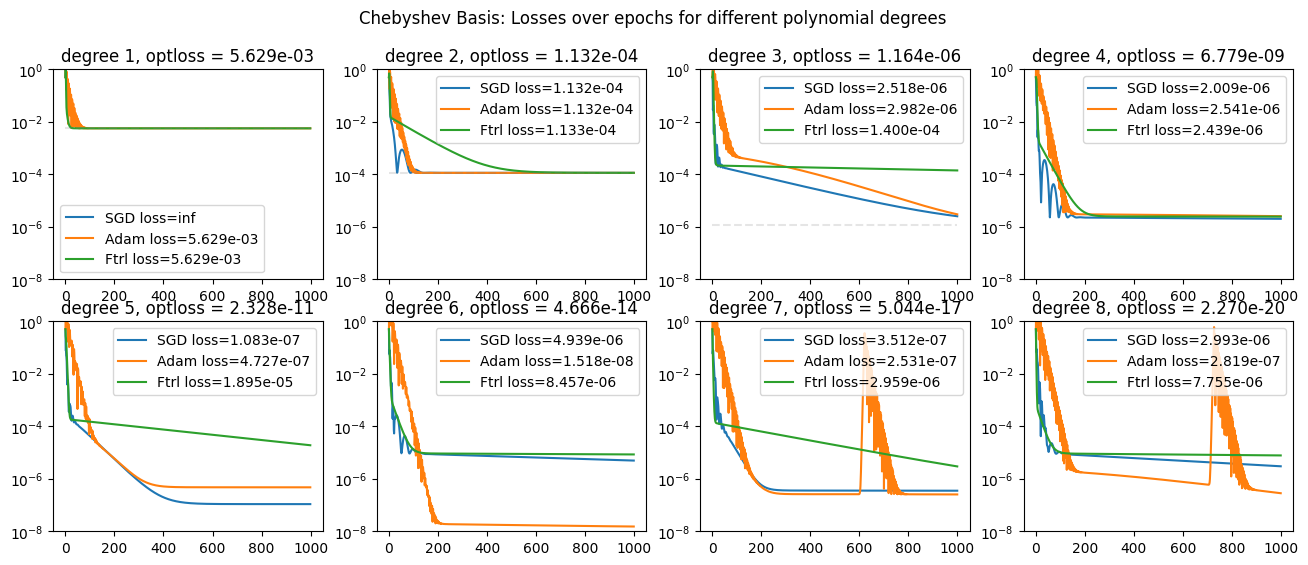

In [115]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Chebyshev Basis: Losses over epochs for different polynomial degrees")

for i, d in enumerate(degrees):
    ax = axes[i]

    optcoeff = optcoeff = np.polyfit(xs, ys, d)[::-1]
    optloss = l2_sq_loss(optcoeff, xs, ys)

    ax.set_title("degree %d, optloss = %.3e" % (d, optloss))

    ax.semilogy(losses_chebyshev_sgd[i], label="SGD loss=%.3e" % losses_chebyshev_sgd[i][-1])
    ax.semilogy(losses_chebyshev_amsgrad[i], label="Adam loss=%.3e" % losses_chebyshev_amsgrad[i][-1])
    ax.semilogy(losses_chebyshev_ftrl[i], label="Ftrl loss=%.3e" % losses_chebyshev_ftrl[i][-1])

    ax.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color="gray", alpha=0.2)

    ax.set_ylim([1e-8, 1e-0])
    ax.legend(loc="best")

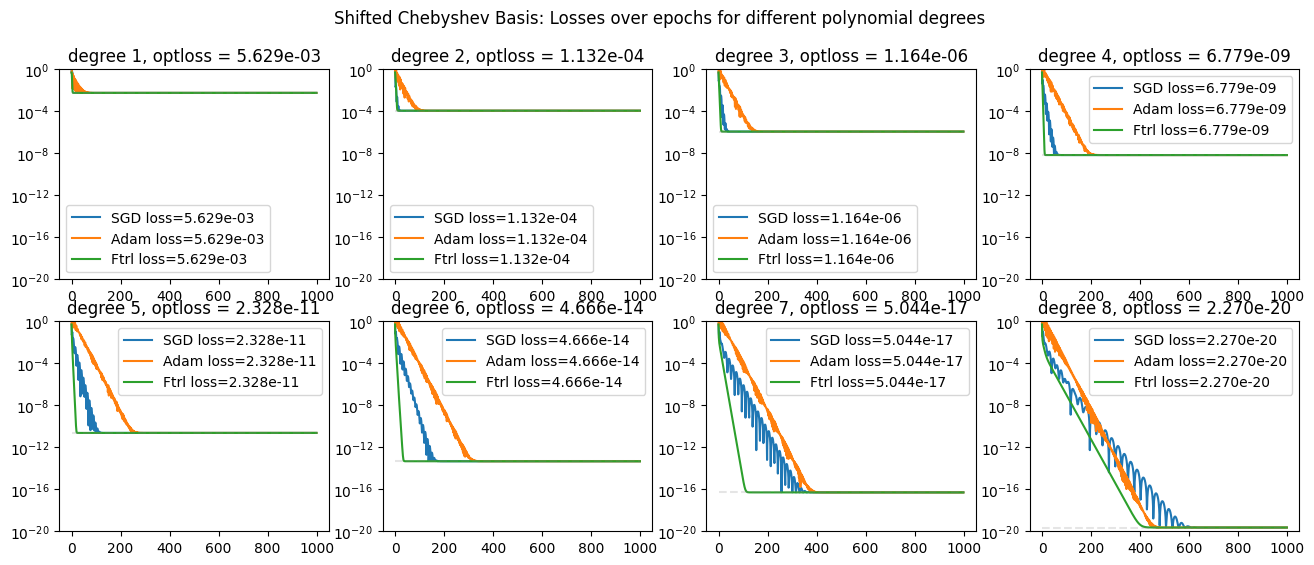

In [117]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Shifted Chebyshev Basis: Losses over epochs for different polynomial degrees")

for i, d in enumerate(degrees):
    ax = axes[i]

    optcoeff = optcoeff = np.polyfit(xs, ys, d)[::-1]
    optloss = l2_sq_loss(optcoeff, xs, ys)

    ax.set_title("degree %d, optloss = %.3e" % (d, optloss))

    ax.semilogy(losses_shifted_chebyshev_sgd[i], label="SGD loss=%.3e" % losses_shifted_chebyshev_sgd[i][-1])
    ax.semilogy(losses_shifted_chebyshev_amsgrad[i], label="Adam loss=%.3e" % losses_shifted_chebyshev_amsgrad[i][-1])
    ax.semilogy(losses_shifted_chebyshev_ftrl[i], label="Ftrl loss=%.3e" % losses_shifted_chebyshev_ftrl[i][-1])

    ax.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color="gray", alpha=0.2)

    ax.set_ylim([1e-20, 1e-0])
    ax.legend(loc="best")

### Interpretation
Power Basis and Chebyshev Basis:
- With degree 1 and 2 the optimizers actually reach the optimum.
- Higher degree leads to better optimal loss, of course.
- With better optimizers we get closer to the optimum. Hence, we see that higher-degree polynomials leading to better loss. In fact, for Adam now degree 5 leads the best result and with more epochs it would be degree 4. For SGD degree 5 is best. So better optimizers shift the boundary of admissible degrees.
- SGD is competitive with Adam until degree 3. For degree 2 it is actually prefred over Adam. Then, starting from 200 epochs, Adam outperforms SGD.
- Furthermore, Adam converges for degree 8 as well. Here the degree-based regularization of gradients becomes, so it seems, insufficient, while Adam is adaptive.
- **For our cam application: Shall we better use polynomial degree 5?**

Shifted Chebyshev Basis:
- The outstanding performance is confirmed for all feasible degrees
- For all degrees and all optimizers, the optimum is reached
- Ftrl shows the quickest and cleanest convergence behaviour

## Shifting of polynomial centers

In [118]:
epochs = 1000
degree = 5
lr = 1.3
degrees = [d for d in range(1, 9)]

In [119]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': 'boundary', 'gradient_regularization': False,
        'basis': 'power', 'optimizer': 'amsgrad' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_boundary = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [120]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': 'mean', 'gradient_regularization': False,
        'basis': 'power', 'optimizer': 'amsgrad' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_mean = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [121]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': 'boundary', 'gradient_regularization': False,
        'basis': 'chebyshev', 'optimizer': 'amsgrad' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_boundary = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [122]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': 'mean', 'gradient_regularization': False,
        'basis': 'chebyshev', 'optimizer': 'amsgrad' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_chebyshev_mean = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [123]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': shift_polynomial_centers, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'amsgrad' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev_boundary = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [124]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': 1, 'ck': 0, 'continuity': False, 'degree': 5, 'learning_rate': lr,
        'n_epochs': epochs, 'shift_polynomial_centers': 'mean', 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'optimizer': 'amsgrad' ,'mode': 'degree'}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev_mean = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [126]:
losses_boundary = [0.0] * len(results_boundary)
losses_mean = [0.0] * len(results_boundary)
losses_chebyshev_boundary = [0.0] * len(results_boundary)
losses_chebyshev_mean = [0.0] * len(results_boundary)
losses_shifted_chebyshev_boundary = [0.0] * len(results_boundary)
losses_shifted_chebyshev_mean = [0.0] * len(results_boundary)

for i in range(len(results_sgd)):
    losses_boundary[i] = results_boundary[i][1]
    losses_mean[i] = results_mean[i][1]
    losses_chebyshev_boundary[i] = results_chebyshev_boundary[i][1]
    losses_chebyshev_mean[i] = results_chebyshev_mean[i][1]
    losses_shifted_chebyshev_boundary[i] = results_shifted_chebyshev_boundary[i][1]
    losses_shifted_chebyshev_mean[i] = results_shifted_chebyshev_mean[i][1]

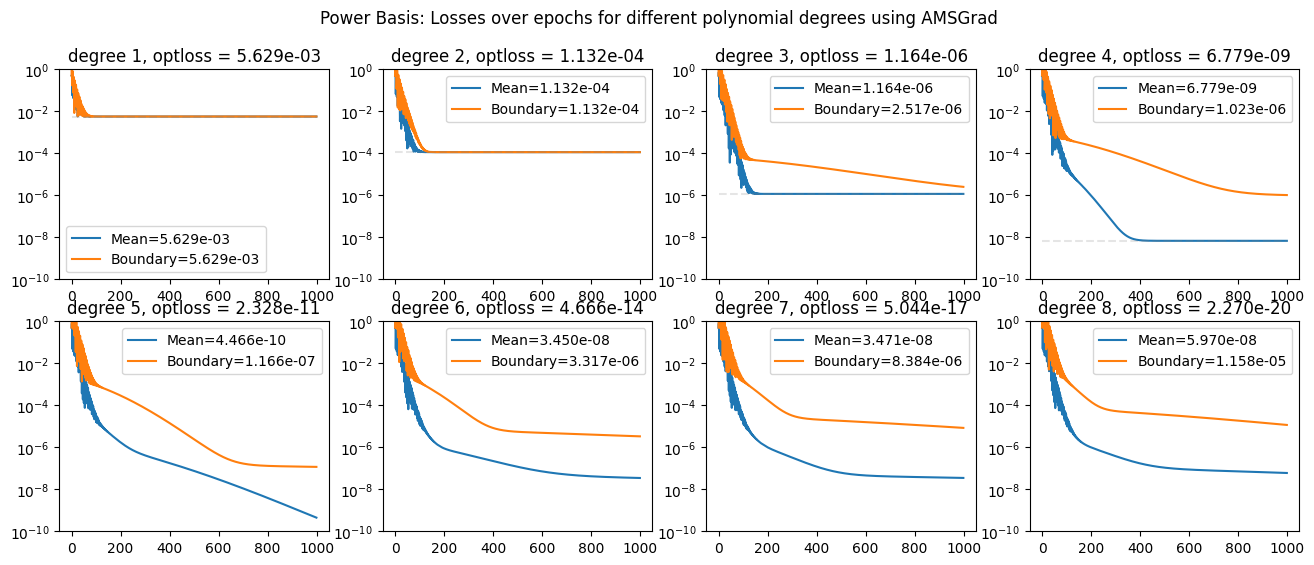

In [130]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Power Basis: Losses over epochs for different polynomial degrees using AMSGrad")

for i, d in enumerate(degrees):
    ax = axes[i]

    optcoeff = optcoeff = np.polyfit(xs, ys, d)[::-1]
    optloss = l2_sq_loss(optcoeff, xs, ys)

    ax.set_title("degree %d, optloss = %.3e" % (d, optloss))

    ax.semilogy(losses_mean[i], label="Mean=%.3e" % losses_mean[i][-1])
    ax.semilogy(losses_boundary[i], label="Boundary=%.3e" % losses_boundary[i][-1])

    ax.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color="gray", alpha=0.2)

    ax.set_ylim([1e-10, 1e-0])
    ax.legend(loc="best")

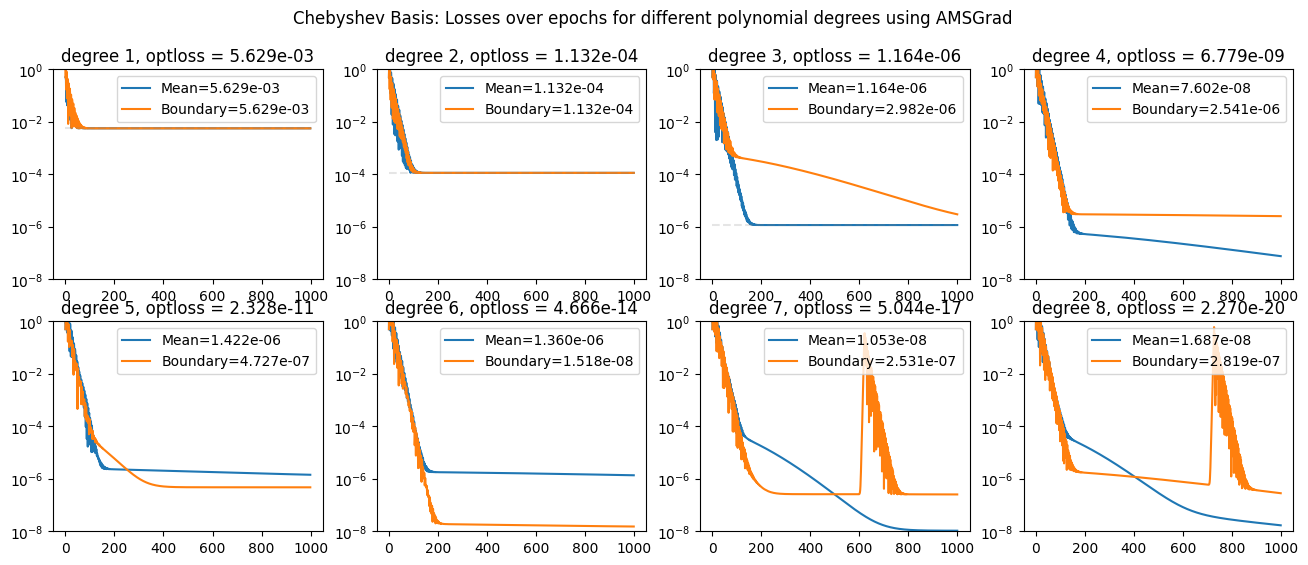

In [132]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Chebyshev Basis: Losses over epochs for different polynomial degrees using AMSGrad")

for i, d in enumerate(degrees):
    ax = axes[i]

    optcoeff = optcoeff = np.polyfit(xs, ys, d)[::-1]
    optloss = l2_sq_loss(optcoeff, xs, ys)

    ax.set_title("degree %d, optloss = %.3e" % (d, optloss))

    ax.semilogy(losses_chebyshev_mean[i], label="Mean=%.3e" % losses_chebyshev_mean[i][-1])
    ax.semilogy(losses_chebyshev_boundary[i], label="Boundary=%.3e" % losses_chebyshev_boundary[i][-1])

    ax.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color="gray", alpha=0.2)

    ax.set_ylim([1e-8, 1e-0])
    ax.legend(loc="best")

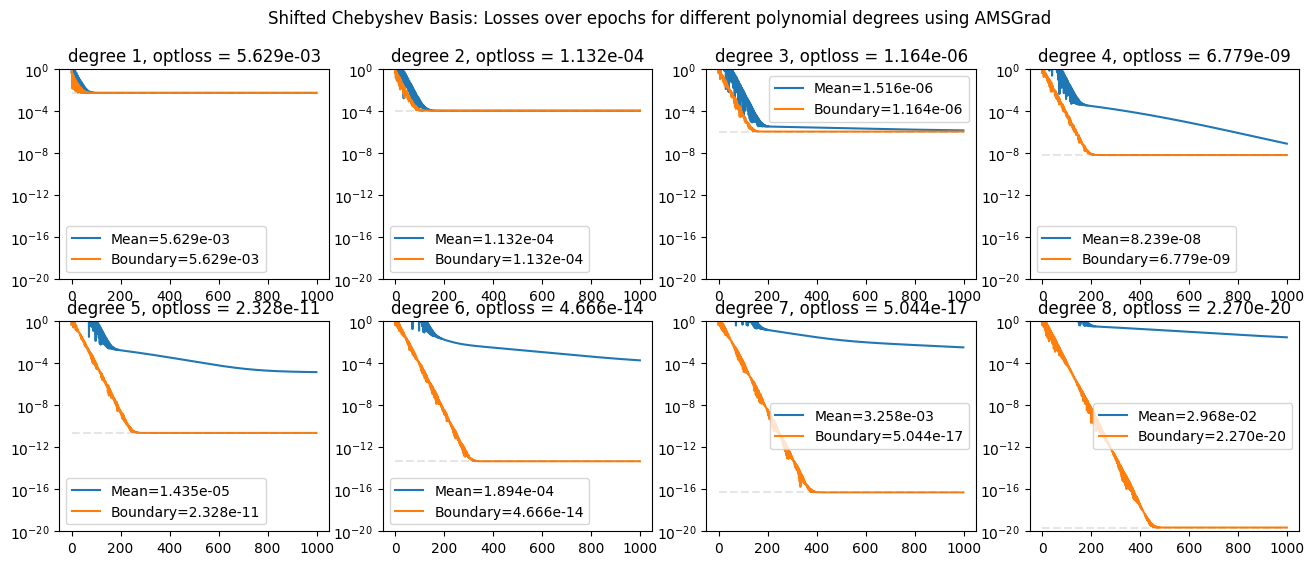

In [133]:
fig, axes = plt.subplots(2, (len(degrees) + 1) // 2)
axes = axes.flatten()
fig.set_figwidth(len(degrees) * 2)
fig.set_figheight(6)
fig.suptitle("Shifted Chebyshev Basis: Losses over epochs for different polynomial degrees using AMSGrad")

for i, d in enumerate(degrees):
    ax = axes[i]

    optcoeff = optcoeff = np.polyfit(xs, ys, d)[::-1]
    optloss = l2_sq_loss(optcoeff, xs, ys)

    ax.set_title("degree %d, optloss = %.3e" % (d, optloss))

    ax.semilogy(losses_shifted_chebyshev_mean[i], label="Mean=%.3e" % losses_shifted_chebyshev_mean[i][-1])
    ax.semilogy(losses_shifted_chebyshev_boundary[i], label="Boundary=%.3e" % losses_shifted_chebyshev_boundary[i][-1])

    ax.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color="gray", alpha=0.2)

    ax.set_ylim([1e-20, 1e-0])
    ax.legend(loc="best")

### Interpretation

Shifting to left boundary of segment:
- Power Basis: Degree 3
- Chebyshev Basis: Degree 2
- Shifted Chebyshev Basis: all

Shifting to mean of segment:
- Power Basis: Degrees 2, 3, 4 and possibly 5
- Chebyshev Basis: Degree 2, 3
- Shifted Chebyshev Basis: 1, 2

**For Power and Chebyshev Basis, shifting to the mean of the segment shows best results.
For Shifted Chebyshev Basis, shifting to the left boundary of the segment is the optimum.**

This is the expected behaviour, as Shifted Chebyshev Basis is a basis for polynomials over $\mathbb{R}$ on the interval [0, 1].
If we shift to the right, we are left with only half the interval.
The "standard" Chebyshev basis is a basis for polynomials over $\mathbb{R}$ on the interval [-1, 1],
which means we only work with half the interval anyway and then shift the center of that interval more into the direction of the center of our dataset.
With Power Basis, we work with polynomials with a "natural" center at x=0 that approximate our dataset only with their "right hand side".
If we shift the center to x=0.5, we can work with both sides around the development center of the polynomial.

**Since C^2-continuity is required for most cam applications and we want to keep polynomial oscillating low,
we should use a polynomial of degree 5 (or possibly 6).**